# SVM + word2vec

In [84]:
# word2vec預訓練模型
import gensim
word2vec_model = gensim.models.KeyedVectors.load_word2vec_format(
    './google_pre_vec/GoogleNews-vectors-negative300.bin.gz',
    binary=True) 

In [480]:
import pandas as pd
import numpy as np

#測試先讀入其中一個資料就好
aud_df = pd.read_csv("./Pre_data/move_window/AUD/AUD0.csv", index_col = 0)

In [481]:
aud_df

,date,word2vec_body,tfidf_body,bert_body,source_title,binary,ternary_1,ternary_2
0,2016-01-04,as markets reopen for the first week of invest...,market reopen first week investor focus asia c...,['as markets reopen for the first week of inve...,CNBC,0.0,0.0,0.0
1,2016-01-04,the global financial markets in were pulled be...,global financial market pull two oppose force ...,['the global financial markets in were pulled ...,Seeking Alpha,0.0,0.0,0.0
2,2016-01-04,exporters increase currency protection to lock...,exporter increase currency protection lock wea...,['exporters increase currency protection to lo...,Bloomberg Business,0.0,0.0,0.0
3,2016-01-05,stocks slide amid risk aversion after shiite c...,stock slide amid risk aversion shiite cleric e...,['stocks slide amid risk aversion after shiite...,Bloomberg Business,0.0,0.0,0.0
4,2016-01-05,the canadian and australian dollars rose after...,canadian australian dollar rise people bank ch...,['the canadian and australian dollars rose aft...,Bloomberg Business,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
13856,2020-12-30,online video platform biteable a startup that ...,online video platform biteable startup make ea...,['online video platform biteable a startup tha...,Yahoo Finance,1.0,1.0,1.0
13857,2020-12-31,in an eventful year for global markets some in...,eventful year global market individual one com...,['in an eventful year for global markets some ...,Financial Times,1.0,1.0,1.0
13858,2020-12-31,measure of attitudes about finances buying cli...,measure attitude finance buy climate also fall...,['measure of attitudes about finances buying c...,Bloomberg Business,1.0,1.0,1.0
13859,2020-12-31,buoyed by positive momentum for shares of inte...,buoy positive momentum share intel goldman sac...,['buoyed by positive momentum for shares of in...,MarketWatch,1.0,1.0,1.0


In [5]:
def text2averege_vec(text):
    wordvec = np.array([])
    word_list = text.split(" ")
    text_vec = np.array([])
                
    for word in word_list:
            
        try:
            #使向量全部併入1D中
            wordvec = np.append(wordvec, word2vec_model[word])

        except KeyError:
            #如果有看不懂的字直接跳過
            continue    
    #重塑1D->2D <字數，詞向量>
    word_dim = wordvec.shape[0]//300
    wordvec = wordvec.reshape(word_dim,300)
    
    #對col方向進行平均計算
    text_vec = np.mean(wordvec,axis=0)
    
    #重塑矩陣形狀為1一文本300文本向量(這是一個確保，以免形狀不對)
    return text_vec.reshape(1,300)

In [6]:
def text2_vec(text, max_word=100):
    wordvec = np.array([])
    word_list = text.split(" ")
    word_count = 0
            
    for word in word_list:
            
        try:
            wordvec = np.append(wordvec, word2vec_model[word])      #使用np.append以確定所有list都是以np.array的形式表現
            word_count+=1

        except KeyError:                                   #如果有看不懂的字，就跳過
            continue    
            
    wordvec = wordvec.reshape(word_count, 300)                       #重塑矩陣形狀
    
    if word_count > max_word:                              
        wordvec = wordvec[0 : max_word]                     #字多就砍，保留前面
    
    elif word_count < max_word:                             #字少就加，添加0向量，補足我們需要的大小
        pad_num = max_word - word_count
        filler = np.zeros((pad_num, 300))
        wordvec =np.append(wordvec,filler,axis=0)           #這用法很重要ㄟ，很好用!!!
    
    return wordvec

In [7]:
def get_word2vec_averege_vec(df):
    #設定變數
    df_len = df.shape[0] #新聞數
    vec = np.array([]) #新聞向量儲存

    #計算文本向量
    for i in range(df_len):
         vec = np.append(vec, text2averege_vec(df["word2vec_body"][i]))
    vec = vec.reshape(df_len,300) #使每篇文本有各自的向量
    print("done")
    
    return(vec)

In [8]:
aud1_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12099 entries, 0 to 12098
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           12099 non-null  object 
 1   word2vec_body  12099 non-null  object 
 2   tfidf_body     12099 non-null  object 
 3   bert_body      12099 non-null  object 
 4   source_title   12099 non-null  object 
 5   binary         12099 non-null  float64
 6   ternary_1      12099 non-null  float64
 7   ternary_2      12099 non-null  float64
dtypes: float64(3), object(5)
memory usage: 850.7+ KB


### 撰寫常用方法!!!

In [8]:
def split_df1(df1, vec, label="binary"):
    trainstr = 0
    trainend = df1[df1["date"]<"2020-01-01"].shape[0]
    teststr = trainend
    testend = df1[df1["date"]<"2020-07-01"].shape[0]
    
    #分割向量
    train_vec = vec[trainstr:trainend]
    test_vec = vec[teststr:testend]

    #label
    train_y = df1[label][trainstr:trainend]
    test_y = df1[label][teststr:testend]
    
    return train_vec, test_vec, train_y, test_y

In [9]:
def split_df2(df1, vec, label="binary"):
    trainstr = df1[df1['date'] < "2016-04-01"].shape[0]
    trainend = df1[df1["date"]<"2020-04-01"].shape[0]
    teststr = trainend
    testend = df1[df1["date"]<"2020-10-01"].shape[0]
    
    #分割向量
    train_vec = vec[trainstr:trainend]
    test_vec = vec[teststr:testend]

    #label
    train_y = df1[label][trainstr:trainend]
    test_y = df1[label][teststr:testend]
    
    return train_vec, test_vec, train_y, test_y

In [10]:
def split_df3(df1, vec, label="binary"):
    trainstr = df1[df1['date'] < "2016-07-01"].shape[0]
    trainend = df1[df1["date"]<"2020-07-01"].shape[0]
    teststr = trainend
    testend = df1[df1["date"]<"2021-01-01"].shape[0]
    
    #分割向量
    train_vec = vec[trainstr:trainend]
    test_vec = vec[teststr:testend]

    #label
    train_y = df1[label][trainstr:trainend]
    test_y = df1[label][teststr:testend]
    
    return train_vec, test_vec, train_y, test_y

In [11]:
def selecte_kernel(train_vec, test_vec, train_y, test_y):
    
    from sklearn import svm
    
    kernel= ["sigmoid", "linear", "rbf"]
    for k in kernel:
        train_score_his = []
        test_score_his = []
        
        for i in np.arange(0.5, 20, 0.2):
            clf = svm.SVC(kernel=k,C=i)
            clf.fit(train_vec,train_y)

            train_score = clf.score(train_vec, train_y) 
            test_score = clf.score(test_vec, test_y)

            train_score_his.append(train_score)
            test_score_his.append(test_score)
            
        #繪圖
        x = np.arange(0.5, 20, 0.2).tolist()
        plt.figure(figsize=(8,6))
        plt.plot(x, train_score_his, 'g:')     # green dimonds (no line)
        plt.plot(x, test_score_his, 'r:')     # red dotted line (no marker)
        title = "SVM_"+k
        path = './result/pre_study/SVM_'+ k +'.png'
        plt.title(title)
        plt.xlabel('C parameter')
        plt.ylabel('testingset accuracy')
        plt.legend(['train_score','test_score'])
        plt.savefig(path)#儲存圖片
        plt.show()
        

In [12]:
def SVM_hyperparameter(train_vec, test_vec, train_y, test_y):

    from sklearn import svm
    
    train_score_his = []
    test_score_his = []
    
    #調參
    for i in np.arange(1, 100, 0.2):
        clf = svm.SVC(kernel='rbf',C=i)
        clf.fit(train_vec,train_y)
        
        train_score = clf.score(train_vec, train_y) 
        test_score = clf.score(test_vec, test_y)
        
        train_score_his.append(train_score)
        test_score_his.append(test_score)
        
    return train_score_his, test_score_his

In [13]:
def get_best_Cparameter(test_score_his, test_score_his2, test_score_his3):
    #找出三個子集中表現最佳的參數
    testscore = np.array(test_score_his)+np.array(test_score_his2)+np.array(test_score_his3)
    testscore = testscore/3
    index = testscore.tolist().index(max(testscore))
    c = index*0.2+1
    
    return c, max(testscore)

In [174]:
def SVM_function(train_vec, test_vec, train_y, test_y, c):
    
    from sklearn import svm
    #from sklearn.metrics import classification_report
    
    clf = svm.SVC(kernel='rbf',C=c)
    clf.fit(train_vec,train_y)
    
    train_score = clf.score(train_vec, train_y) 
    test_score = clf.score(test_vec, test_y)
    #print(train_score, test_score)

    y_true, y_pred = test_y, clf.predict(test_vec)
    #print(classification_report(y_true, y_pred))
    
    return train_score, test_score

In [175]:
def KNN_function(train_vec, test_vec, train_y, test_y, K = 5):
    
    from sklearn.neighbors import KNeighborsClassifier as knn
    #from sklearn.metrics import classification_report

    clf = knn(n_neighbors=K)
    clf.fit(train_vec, train_y)
    
    train_score = clf.score(train_vec, train_y) 
    test_score = clf.score(test_vec, test_y)

    #print(train_score, test_score)

    y_true, y_pred = test_y, clf.predict(test_vec)
    #print(classification_report(y_true, y_pred))
    
    return train_score,test_score
    

In [176]:
def NB_function(train_vec, test_vec, train_y, test_y):
    from sklearn.naive_bayes import GaussianNB
    #from sklearn.metrics import classification_report
    
    clf=GaussianNB()                         # 這裡使用高斯貝氏分類器
    clf.fit(train_vec,train_y)
    
    train_score = clf.score(train_vec, train_y) 
    test_score = clf.score(test_vec, test_y)
    #print(train_score, test_score)

    y_true, y_pred = test_y, clf.predict(test_vec)
    #print(classification_report(y_true, y_pred))
    
    return train_score, test_score

In [217]:
def XGB_function(train_vec, test_vec, train_y, test_y):
    from xgboost.sklearn import XGBClassifier
    from sklearn.metrics import classification_report
    
    clf = XGBClassifier(
        n_estimators=50, #樹的個數
        learning_rate= 0.3,  # 如同學習率
        max_depth=5, # 構建樹的深度，越大越容易過擬合 
        subsample=1, # 隨機取樣訓練樣本 訓練例項的子取樣比
        gamma=0.2, # 用於控制是否後剪枝的引數,越大越保守，一般0.1、0.2這樣子
        reg_lambda=5, # 控制模型複雜度的權重值的L2正則化項引數，引數越大，模型越不容易過擬合。
        max_delta_step=0, #最大增量步長，我們允許每個樹的權重估計。
        colsample_bytree=1, # 生成樹時進行的列取樣 

        # 這個引數預設是 1，是每個葉子裡面 h 的和至少是多少，對正負樣本不均衡時的 0-1 分類而言
        # 假設 h 在 0.01 附近，min_child_weight 為 1 意味著葉子節點中最少需要包含 100 個樣本。
        #這個引數非常影響結果，控制葉子節點中二階導的和的最小值，該引數值越小，越容易 overfitting。
        min_child_weight=1, 
        
        seed=1000 #隨機種子
        
        # L1 正則項引數
        #reg_alpha=0,
        
        #如果取值大於0的話，在類別樣本不平衡的情況下有助於快速收斂。平衡正負權重
        #scale_pos_weight=1,
        
        #多分類的問題 指定學習任務和相應的學習目標
        #objective= 'multi:softmax', 
        
        # 類別數，多分類與 multisoftmax 並用
        #num_class=10,
        
        # 設定成1則沒有執行資訊輸出，最好是設定為0.是否在執行升級時列印訊息。
        #silent=0 ,
        # cpu 執行緒數 預設最大
        #nthread=4,
    
        #eval_metric= 'auc'
        )
    clf.fit(train_vec,train_y,eval_metric='rmse')
    train_score = clf.score(train_vec, train_y) 
    test_score = clf.score(test_vec, test_y)
    #print(train_score, test_score)

    y_true, y_pred = test_y, clf.predict(test_vec)
    #print(classification_report(y_true, y_pred))
    
    return train_score, test_score

In [16]:
def plot(train_score_his, test_score_his, label = "binary", data = "1"):
    #繪圖
    x = np.arange(1, 100, 0.2).tolist()
    plt.figure(figsize=(8,6))
    plt.plot(x, train_score_his, 'g:')     # green dimonds (no line)
    plt.plot(x, test_score_his, 'r:')     # red dotted line (no marker)
    title = "aud_"+ data +" "+ label+" SVM"
    path = './result/pre_study/'+label+'/aud_'+ data +' SVM.png'
    plt.title(title)
    plt.xlabel('C parameter')
    plt.ylabel('testingset accuracy')
    plt.legend(['train_score','test_score'])
    plt.savefig(path)#儲存圖片
    plt.show()

In [17]:
def train_score(train_score_his,train_score_his2,train_score_his3,c=1):
    trainscore = np.array(train_score_his)+np.array(train_score_his2)+np.array(train_score_his3)
    trainscore = trainscore/3
    index = (c-1)*5
    index = int(index)
    print(trainscore[index])

In [18]:
def get_single_sourcedate(df, source= "Yahoo Finance"):
    groupset = df.groupby("source_title") #分群
    sub_df = groupset.get_group(source) #取出YF
    sub_df = sub_df.reset_index(drop=True) #重設索引
    return sub_df

In [182]:
def avr_SVM_train_test_score(df,vec,Label = "binary",L1 = 1000):
    # 計算yahoo finance1
    X_train, X_test, y_train, y_test = split_df1(df, vec, label = Label)
    train_score,test_score = SVM_function(X_train, X_test, y_train, y_test, c=L1)
    # 計算yahoo finance2
    X_train, X_test, y_train, y_test = split_df2(df, vec, label = Label)
    train_score2,test_score2 = SVM_function(X_train, X_test, y_train, y_test, c=L1)
    # 計算yahoo finance3
    X_train, X_test, y_train, y_test = split_df3(df, vec, label = Label)
    train_score3,test_score3 = SVM_function(X_train, X_test, y_train, y_test, c=L1)
    #二分類平均
    score = (train_score+train_score2+train_score3)/3, (test_score+test_score2+test_score3)/3
    print(score)
    return score

def avr_KNN_train_test_score(df,vec,Label = "binary",n = 1):
    # 計算yahoo finance1
    X_train, X_test, y_train, y_test = split_df1(df, vec, label = Label)
    train_score,test_score = KNN_function(X_train, X_test, y_train, y_test, K=n)
    # 計算yahoo finance2
    X_train, X_test, y_train, y_test = split_df2(df, vec, label = Label)
    train_score2,test_score2 = KNN_function(X_train, X_test, y_train, y_test, K=n)
    # 計算yahoo finance3
    X_train, X_test, y_train, y_test = split_df3(df, vec, label = Label)
    train_score3,test_score3 = KNN_function(X_train, X_test, y_train, y_test, K=n)
    #二分類平均
    score = (train_score+train_score2+train_score3)/3, (test_score+test_score2+test_score3)/3
    print(score)
    return score

def avr_NB_train_test_score(df,vec,Label = "binary"):
    
    X_train, X_test, y_train, y_test = split_df1(df, vec, label = Label)
    train_score,test_score = NB_function(X_train, X_test, y_train, y_test)
    
    X_train, X_test, y_train, y_test = split_df2(df, vec, label = Label)
    train_score2,test_score2 = NB_function(X_train, X_test, y_train, y_test)
    
    X_train, X_test, y_train, y_test = split_df3(df, vec, label = Label)
    train_score3,test_score3 = NB_function(X_train, X_test, y_train, y_test)
    #二分類平均
    score = (train_score+train_score2+train_score3)/3, (test_score+test_score2+test_score3)/3
    print(score)
    return score

def avr_XGB_train_test_score(df,vec,Label = "binary"):
    
    X_train, X_test, y_train, y_test = split_df1(df, vec, label = Label)
    train_score,test_score = XGB_function(X_train, X_test, y_train, y_test)
    
    X_train, X_test, y_train, y_test = split_df2(df, vec, label = Label)
    train_score2,test_score2 = XGB_function(X_train, X_test, y_train, y_test)
    
    X_train, X_test, y_train, y_test = split_df3(df, vec, label = Label)
    train_score3,test_score3 = XGB_function(X_train, X_test, y_train, y_test)
    #二分類平均
    score = (train_score+train_score2+train_score3)/3, (test_score+test_score2+test_score3)/3
    print(score)
    return score

In [205]:
from transformers import TFBertModel, BertTokenizer
import tensorflow as tf

# download bert-base-uncased model 
bert_model = TFBertModel.from_pretrained('bert-base-uncased')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')


def text2averege_bertvec(text):
    wordvec = np.array([])
    text_vec = np.array([])
    word_count = 0
                
    for segment in eval(text):
        if(segment != "" and segment != " " and segment != "  " and segment != "   "):
            tokens = tokenizer.tokenize(segment)                #分割句字中的單字，看不懂得bert會補上萬用字元
            if len(tokens) >= 512:                              #避免句子過長
                tokens = tokens[0:511]
                
            token_ids = tokenizer.convert_tokens_to_ids(tokens) #將單字轉換為bert對應的詞id
            token_ids = tf.convert_to_tensor(token_ids)         #將id轉為tensor表示(詞數,)
            token_ids = tf.reshape(token_ids, [1, -1 ])         #reshape(1,詞數)

            output = bert_model(token_ids)                      #輸入至bert模型中\
            segment_vec = output[0][0].numpy()                  #將tensor轉為numpy，比較好用> <
            word_count += segment_vec.shape[0]                  #統計字數
            wordvec = np.append(wordvec, segment_vec)           #將所有句子append到一個np.array。缺點會全部變成一維表示

    wordvec = wordvec.reshape(word_count,768)               #重塑1D->2D <字數，詞向量>
    
    text_vec = np.mean(wordvec,axis=0)                      #對col方向進行平均計算
    
    return text_vec.reshape(1,768)                          #重塑矩陣形狀為1一文本300文本向量(這是一個確保，以免形狀不對)

def get_bert_averege_vec(df):
    
    #設定變數
    df_len = df.shape[0] #新聞數
    bertvec = np.array([]) #新聞向量儲存

    #計算文本向量
    for i in range(df_len):
        print("第",i,"文章")
        text2averege_bertvec(df["bert_body"][i])
        bertvec = np.append(bertvec, text2averege_bertvec(df["bert_body"][i]))
    bertvec = bertvec.reshape(df_len,768) #使每篇文本有各自的向量   
    
    print("done")
    
    return bertvec

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


### 各子集計算vec

In [492]:
# <aud 特定新聞獲取>
aud_YF = get_single_sourcedate(aud_df, source = "Yahoo Finance")
aud_BB = get_single_sourcedate(aud_df, source = "Bloomberg Business")
aud_SA = get_single_sourcedate(aud_df, source = "Seeking Alpha")

In [496]:
#先將 word2vec向量計算出來
aud_YA_vec = get_word2vec_averege_vec(aud_YF)
aud_BB_vec = get_word2vec_averege_vec(aud_BB)
aud_SA_vec = get_word2vec_averege_vec(aud_SA)

done
done
done


In [500]:
print(aud_YA_vec.shape,aud_BB_vec.shape,aud_SA_vec.shape)

(3452, 300) (2383, 300) (3572, 300)


#### 挑選kernel

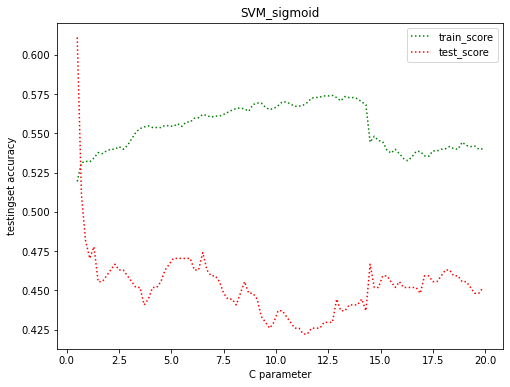

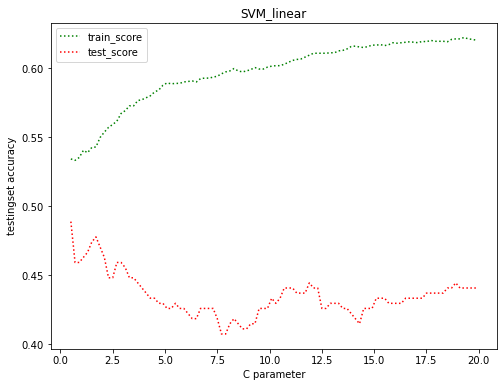

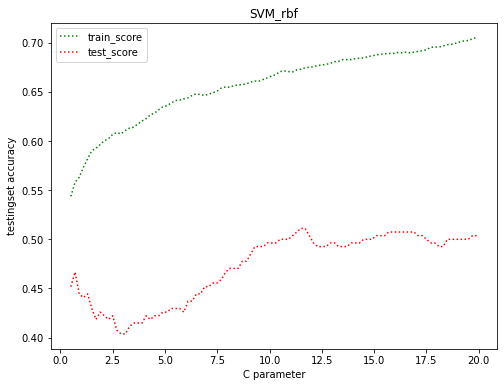

In [286]:
selecte_kernel(X_train, X_test, y_train, y_test)

In [291]:
# 選用rbf(效果最好)，對C調參，老師沒要做這個，就別做了ㄅ

# bi_train_his1, bi_test_his1 = SVM_hyperparameter(X_train, X_test, y_train, y_test) #調參function

# plot(bi_train_his1, bi_test_his1) #畫圖用

# SVM + Word2vec

### binary

In [200]:
avr_SVM_train_test_score(aud_YF, aud_YF_vec, Label = "binary",L1=1000)
avr_SVM_train_test_score(aud_YF, aud_YF_vec, Label = "binary",L1=1)
avr_SVM_train_test_score(aud_BB, aud_BB_vec, Label = "binary",L1=1000)
avr_SVM_train_test_score(aud_BB, aud_BB_vec, Label = "binary",L1=1)
avr_SVM_train_test_score(aud_SA, aud_SA_vec, Label = "binary",L1=1000)
avr_SVM_train_test_score(aud_SA, aud_SA_vec, Label = "binary",L1=1)

(0.9534754112809122, 0.5090965454384416)
(0.5620000942223614, 0.5116871094654015)
(0.9967851744861154, 0.47608110648367347)
(0.5520129448554888, 0.5833807637316113)
(0.9651243145825315, 0.4929055534131339)
(0.559094614023505, 0.5568731560155978)


(0.559094614023505, 0.5568731560155978)

### ternary01

In [201]:
avr_SVM_train_test_score(aud_YF, aud_YF_vec, Label = "ternary_1",L1=1000)
avr_SVM_train_test_score(aud_YF, aud_YF_vec, Label = "ternary_1",L1=1)
avr_SVM_train_test_score(aud_BB, aud_BB_vec, Label = "ternary_1",L1=1000)
avr_SVM_train_test_score(aud_BB, aud_BB_vec, Label = "ternary_1",L1=1)
avr_SVM_train_test_score(aud_SA, aud_SA_vec, Label = "ternary_1",L1=1000)
avr_SVM_train_test_score(aud_SA, aud_SA_vec, Label = "ternary_1",L1=1)

(0.9518885979351756, 0.3995602869706087)
(0.4447367785379825, 0.48924545929868773)
(0.9949766161212262, 0.3721059666469306)
(0.4728082311582639, 0.4865839267857381)
(0.966591693871063, 0.3661411799356336)
(0.47056464690715627, 0.45595271569944557)


(0.47056464690715627, 0.45595271569944557)

### ternary02

In [199]:
avr_SVM_train_test_score(aud_YF, aud_YF_vec, Label = "ternary_2",L1=1000)
avr_SVM_train_test_score(aud_YF, aud_YF_vec, Label = "ternary_2",L1=1)
avr_SVM_train_test_score(aud_BB, aud_BB_vec, Label = "ternary_2",L1=1000)
avr_SVM_train_test_score(aud_BB, aud_BB_vec, Label = "ternary_2",L1=1)
avr_SVM_train_test_score(aud_SA, aud_SA_vec, Label = "ternary_2",L1=1000)
avr_SVM_train_test_score(aud_SA, aud_SA_vec, Label = "ternary_2",L1=1)

(0.9530634732207588, 0.32622792506307124)
(0.4048815956816038, 0.2986194325159071)
(0.9943776680715075, 0.3278341324403261)
(0.3969526056732661, 0.4029752089746601)
(0.959861411219876, 0.31745279905540996)
(0.3954690548267545, 0.38072675596807887)


(0.3954690548267545, 0.38072675596807887)

# KNN + word2vec

### binary

In [202]:
avr_KNN_train_test_score(aud_YF, aud_YF_vec, Label = "binary",n=5)
avr_KNN_train_test_score(aud_YF, aud_YF_vec, Label = "binary",n=1)
avr_KNN_train_test_score(aud_BB, aud_BB_vec, Label = "binary",n=5)
avr_KNN_train_test_score(aud_BB, aud_BB_vec, Label = "binary",n=1)
avr_KNN_train_test_score(aud_SA, aud_SA_vec, Label = "binary",n=5)
avr_KNN_train_test_score(aud_SA, aud_SA_vec, Label = "binary",n=1)

(0.7013841417939762, 0.5071648366718953)
(1.0, 0.5295307727692207)
(0.6936774762448469, 0.5033798612528214)
(0.9991915128296349, 0.4976366783463952)
(0.693152567218049, 0.5093865838645069)
(0.9978870130513444, 0.48634239563742815)


(0.9978870130513444, 0.48634239563742815)

### ternary01 

In [203]:
avr_KNN_train_test_score(aud_YF, aud_YF_vec, Label = "ternary_1",n=5)
avr_KNN_train_test_score(aud_YF, aud_YF_vec, Label = "ternary_1",n=1)
avr_KNN_train_test_score(aud_BB, aud_BB_vec, Label = "ternary_1",n=5)
avr_KNN_train_test_score(aud_BB, aud_BB_vec, Label = "ternary_1",n=1)
avr_KNN_train_test_score(aud_SA, aud_SA_vec, Label = "ternary_1",n=5)
avr_KNN_train_test_score(aud_SA, aud_SA_vec, Label = "ternary_1",n=1)

(0.6040585682233939, 0.42776277782063477)
(1.0, 0.42125679640915314)
(0.6106273505500837, 0.4124051964460653)
(0.9979858072530421, 0.37819247124940486)
(0.6021236440778367, 0.41420133496036793)
(0.9968305195770166, 0.3574576832669769)


(0.9968305195770166, 0.3574576832669769)

### ternary02

In [204]:
avr_KNN_train_test_score(aud_YF, aud_YF_vec, Label = "ternary_2",n=5)
avr_KNN_train_test_score(aud_YF, aud_YF_vec, Label = "ternary_2",n=1)
avr_KNN_train_test_score(aud_BB, aud_BB_vec, Label = "ternary_2",n=5)
avr_KNN_train_test_score(aud_BB, aud_BB_vec, Label = "ternary_2",n=1)
avr_KNN_train_test_score(aud_SA, aud_SA_vec, Label = "ternary_2",n=5)
avr_KNN_train_test_score(aud_SA, aud_SA_vec, Label = "ternary_2",n=1)

(0.5755294353709336, 0.3370633226762209)
(1.0, 0.325936211610824)
(0.5667217547737061, 0.3434487802518877)
(0.9979858072530421, 0.34241327519493486)
(0.5621357828958177, 0.3394445825718672)
(0.996478355085574, 0.3237558677700659)


(0.996478355085574, 0.3237558677700659)

# SVM + Bert

In [518]:
aud_YF_bertvec = get_bert_averege_vec(aud_YF)
aud_BB_bertvec = get_bert_averege_vec(aud_BB)
aud_SA_bertvec = get_bert_averege_vec(aud_SA)

第 0 文章
第 1 文章
第 2 文章
第 3 文章
第 4 文章
第 5 文章
第 6 文章
第 7 文章
第 8 文章
第 9 文章
第 10 文章
第 11 文章
第 12 文章
第 13 文章
第 14 文章
第 15 文章
第 16 文章
第 17 文章
第 18 文章
第 19 文章
第 20 文章
第 21 文章
第 22 文章
第 23 文章
第 24 文章
第 25 文章
第 26 文章
第 27 文章
第 28 文章
第 29 文章
第 30 文章
第 31 文章
第 32 文章
第 33 文章
第 34 文章
第 35 文章
第 36 文章
第 37 文章
第 38 文章
第 39 文章
第 40 文章
第 41 文章
第 42 文章
第 43 文章
第 44 文章
第 45 文章
第 46 文章
第 47 文章
第 48 文章
第 49 文章
第 50 文章
第 51 文章
第 52 文章
第 53 文章
第 54 文章
第 55 文章
第 56 文章
第 57 文章
第 58 文章
第 59 文章
第 60 文章
第 61 文章
第 62 文章
第 63 文章
第 64 文章
第 65 文章
第 66 文章
第 67 文章
第 68 文章
第 69 文章
第 70 文章
第 71 文章
第 72 文章
第 73 文章
第 74 文章
第 75 文章
第 76 文章
第 77 文章
第 78 文章
第 79 文章
第 80 文章
第 81 文章
第 82 文章
第 83 文章
第 84 文章
第 85 文章
第 86 文章
第 87 文章
第 88 文章
第 89 文章
第 90 文章
第 91 文章
第 92 文章
第 93 文章
第 94 文章
第 95 文章
第 96 文章
第 97 文章
第 98 文章
第 99 文章
第 100 文章
第 101 文章
第 102 文章
第 103 文章
第 104 文章
第 105 文章
第 106 文章
第 107 文章
第 108 文章
第 109 文章
第 110 文章
第 111 文章
第 112 文章
第 113 文章
第 114 文章
第 115 文章
第 116 文章
第 117 文章
第 118 文章
第 119 文章
第 120 文章
第 121 文章
第 122 文章
第 1

第 923 文章
第 924 文章
第 925 文章
第 926 文章
第 927 文章
第 928 文章
第 929 文章
第 930 文章
第 931 文章
第 932 文章
第 933 文章
第 934 文章
第 935 文章
第 936 文章
第 937 文章
第 938 文章
第 939 文章
第 940 文章
第 941 文章
第 942 文章
第 943 文章
第 944 文章
第 945 文章
第 946 文章
第 947 文章
第 948 文章
第 949 文章
第 950 文章
第 951 文章
第 952 文章
第 953 文章
第 954 文章
第 955 文章
第 956 文章
第 957 文章
第 958 文章
第 959 文章
第 960 文章
第 961 文章
第 962 文章
第 963 文章
第 964 文章
第 965 文章
第 966 文章
第 967 文章
第 968 文章
第 969 文章
第 970 文章
第 971 文章
第 972 文章
第 973 文章
第 974 文章
第 975 文章
第 976 文章
第 977 文章
第 978 文章
第 979 文章
第 980 文章
第 981 文章
第 982 文章
第 983 文章
第 984 文章
第 985 文章
第 986 文章
第 987 文章
第 988 文章
第 989 文章
第 990 文章
第 991 文章
第 992 文章
第 993 文章
第 994 文章
第 995 文章
第 996 文章
第 997 文章
第 998 文章
第 999 文章
第 1000 文章
第 1001 文章
第 1002 文章
第 1003 文章
第 1004 文章
第 1005 文章
第 1006 文章
第 1007 文章
第 1008 文章
第 1009 文章
第 1010 文章
第 1011 文章
第 1012 文章
第 1013 文章
第 1014 文章
第 1015 文章
第 1016 文章
第 1017 文章
第 1018 文章
第 1019 文章
第 1020 文章
第 1021 文章
第 1022 文章
第 1023 文章
第 1024 文章
第 1025 文章
第 1026 文章
第 1027 文章
第 1028 文章
第 1029 文章
第 1030 

第 1750 文章
第 1751 文章
第 1752 文章
第 1753 文章
第 1754 文章
第 1755 文章
第 1756 文章
第 1757 文章
第 1758 文章
第 1759 文章
第 1760 文章
第 1761 文章
第 1762 文章
第 1763 文章
第 1764 文章
第 1765 文章
第 1766 文章
第 1767 文章
第 1768 文章
第 1769 文章
第 1770 文章
第 1771 文章
第 1772 文章
第 1773 文章
第 1774 文章
第 1775 文章
第 1776 文章
第 1777 文章
第 1778 文章
第 1779 文章
第 1780 文章
第 1781 文章
第 1782 文章
第 1783 文章
第 1784 文章
第 1785 文章
第 1786 文章
第 1787 文章
第 1788 文章
第 1789 文章
第 1790 文章
第 1791 文章
第 1792 文章
第 1793 文章
第 1794 文章
第 1795 文章
第 1796 文章
第 1797 文章
第 1798 文章
第 1799 文章
第 1800 文章
第 1801 文章
第 1802 文章
第 1803 文章
第 1804 文章
第 1805 文章
第 1806 文章
第 1807 文章
第 1808 文章
第 1809 文章
第 1810 文章
第 1811 文章
第 1812 文章
第 1813 文章
第 1814 文章
第 1815 文章
第 1816 文章
第 1817 文章
第 1818 文章
第 1819 文章
第 1820 文章
第 1821 文章
第 1822 文章
第 1823 文章
第 1824 文章
第 1825 文章
第 1826 文章
第 1827 文章
第 1828 文章
第 1829 文章
第 1830 文章
第 1831 文章
第 1832 文章
第 1833 文章
第 1834 文章
第 1835 文章
第 1836 文章
第 1837 文章
第 1838 文章
第 1839 文章
第 1840 文章
第 1841 文章
第 1842 文章
第 1843 文章
第 1844 文章
第 1845 文章
第 1846 文章
第 1847 文章
第 1848 文章
第 1849 文章


第 2570 文章
第 2571 文章
第 2572 文章
第 2573 文章
第 2574 文章
第 2575 文章
第 2576 文章
第 2577 文章
第 2578 文章
第 2579 文章
第 2580 文章
第 2581 文章
第 2582 文章
第 2583 文章
第 2584 文章
第 2585 文章
第 2586 文章
第 2587 文章
第 2588 文章
第 2589 文章
第 2590 文章
第 2591 文章
第 2592 文章
第 2593 文章
第 2594 文章
第 2595 文章
第 2596 文章
第 2597 文章
第 2598 文章
第 2599 文章
第 2600 文章
第 2601 文章
第 2602 文章
第 2603 文章
第 2604 文章
第 2605 文章
第 2606 文章
第 2607 文章
第 2608 文章
第 2609 文章
第 2610 文章
第 2611 文章
第 2612 文章
第 2613 文章
第 2614 文章
第 2615 文章
第 2616 文章
第 2617 文章
第 2618 文章
第 2619 文章
第 2620 文章
第 2621 文章
第 2622 文章
第 2623 文章
第 2624 文章
第 2625 文章
第 2626 文章
第 2627 文章
第 2628 文章
第 2629 文章
第 2630 文章
第 2631 文章
第 2632 文章
第 2633 文章
第 2634 文章
第 2635 文章
第 2636 文章
第 2637 文章
第 2638 文章
第 2639 文章
第 2640 文章
第 2641 文章
第 2642 文章
第 2643 文章
第 2644 文章
第 2645 文章
第 2646 文章
第 2647 文章
第 2648 文章
第 2649 文章
第 2650 文章
第 2651 文章
第 2652 文章
第 2653 文章
第 2654 文章
第 2655 文章
第 2656 文章
第 2657 文章
第 2658 文章
第 2659 文章
第 2660 文章
第 2661 文章
第 2662 文章
第 2663 文章
第 2664 文章
第 2665 文章
第 2666 文章
第 2667 文章
第 2668 文章
第 2669 文章


第 3390 文章
第 3391 文章
第 3392 文章
第 3393 文章
第 3394 文章
第 3395 文章
第 3396 文章
第 3397 文章
第 3398 文章
第 3399 文章
第 3400 文章
第 3401 文章
第 3402 文章
第 3403 文章
第 3404 文章
第 3405 文章
第 3406 文章
第 3407 文章
第 3408 文章
第 3409 文章
第 3410 文章
第 3411 文章
第 3412 文章
第 3413 文章
第 3414 文章
第 3415 文章
第 3416 文章
第 3417 文章
第 3418 文章
第 3419 文章
第 3420 文章
第 3421 文章
第 3422 文章
第 3423 文章
第 3424 文章
第 3425 文章
第 3426 文章
第 3427 文章
第 3428 文章
第 3429 文章
第 3430 文章
第 3431 文章
第 3432 文章
第 3433 文章
第 3434 文章
第 3435 文章
第 3436 文章
第 3437 文章
第 3438 文章
第 3439 文章
第 3440 文章
第 3441 文章
第 3442 文章
第 3443 文章
第 3444 文章
第 3445 文章
第 3446 文章
第 3447 文章
第 3448 文章
第 3449 文章
第 3450 文章
第 3451 文章
第 3452 文章
第 3453 文章
第 3454 文章
第 3455 文章
第 3456 文章
第 3457 文章
第 3458 文章
第 3459 文章
第 3460 文章
第 3461 文章
第 3462 文章
第 3463 文章
第 3464 文章
第 3465 文章
第 3466 文章
第 3467 文章
第 3468 文章
第 3469 文章
第 3470 文章
第 3471 文章
第 3472 文章
第 3473 文章
第 3474 文章
第 3475 文章
第 3476 文章
第 3477 文章
第 3478 文章
第 3479 文章
第 3480 文章
第 3481 文章
第 3482 文章
第 3483 文章
第 3484 文章
第 3485 文章
第 3486 文章
第 3487 文章
第 3488 文章
第 3489 文章


In [519]:
print(aud_YF_bertvec.shape, aud_BB_bertvec.shape, aud_SA_bertvec.shape)

(3452, 768) (2383, 768) (3572, 768)


### binary

In [206]:
avr_SVM_train_test_score(aud_YF, aud_YF_bertvec, Label = "binary",L1=1000)
avr_SVM_train_test_score(aud_YF, aud_YF_bertvec, Label = "binary",L1=1)
avr_SVM_train_test_score(aud_BB, aud_BB_bertvec, Label = "binary",L1=1000)
avr_SVM_train_test_score(aud_BB, aud_BB_bertvec, Label = "binary",L1=1)
avr_SVM_train_test_score(aud_SA, aud_SA_bertvec, Label = "binary",L1=1000)
avr_SVM_train_test_score(aud_SA, aud_SA_bertvec, Label = "binary",L1=1)

(0.963640194156845, 0.5363070391227455)
(0.553004671632679, 0.5563061248396434)
(0.9961823216978188, 0.5109623138037147)
(0.5367964639566888, 0.5933899460065258)
(0.9437234350422186, 0.4604363172753437)
(0.5457217366896584, 0.5429716900856685)


(0.5457217366896584, 0.5429716900856685)

### ternary01

In [207]:
avr_SVM_train_test_score(aud_YF, aud_YF_bertvec, Label = "ternary_1",L1=1000)
avr_SVM_train_test_score(aud_YF, aud_YF_bertvec, Label = "ternary_1",L1=1)
avr_SVM_train_test_score(aud_BB, aud_BB_bertvec, Label = "ternary_1",L1=1000)
avr_SVM_train_test_score(aud_BB, aud_BB_bertvec, Label = "ternary_1",L1=1)
avr_SVM_train_test_score(aud_SA, aud_SA_bertvec, Label = "ternary_1",L1=1000)
avr_SVM_train_test_score(aud_SA, aud_SA_bertvec, Label = "ternary_1",L1=1)

(0.9653035870833873, 0.42201879423201644)
(0.44977078384561614, 0.5135728183633761)
(0.9947799592874013, 0.42454541260984024)
(0.4649765847405387, 0.49779295907940013)
(0.9390716101554841, 0.3550071617662549)
(0.4593909245710945, 0.45319377166758873)


(0.4593909245710945, 0.45319377166758873)

### ternary02

In [208]:
avr_SVM_train_test_score(aud_YF, aud_YF_bertvec, Label = "ternary_2",L1=1000)
avr_SVM_train_test_score(aud_YF, aud_YF_bertvec, Label = "ternary_2",L1=1)
avr_SVM_train_test_score(aud_BB, aud_BB_bertvec, Label = "ternary_2",L1=1000)
avr_SVM_train_test_score(aud_BB, aud_BB_bertvec, Label = "ternary_2",L1=1)
avr_SVM_train_test_score(aud_SA, aud_SA_bertvec, Label = "ternary_2",L1=1000)
avr_SVM_train_test_score(aud_SA, aud_SA_bertvec, Label = "ternary_2",L1=1)

(0.9632274517806674, 0.3300156285267757)
(0.40431292903575367, 0.28613003962845823)
(0.9949766161212262, 0.35927186938987404)
(0.3854179717819033, 0.4222603318463655)
(0.9374976278307683, 0.30856908540267414)
(0.38110380443465425, 0.3814669081312873)


(0.38110380443465425, 0.3814669081312873)

# KNN + Bert

### binary

In [214]:
avr_KNN_train_test_score(aud_YF, aud_YF_bertvec, Label = "binary",n=5)
avr_KNN_train_test_score(aud_YF, aud_YF_bertvec, Label = "binary",n=1)
avr_KNN_train_test_score(aud_BB, aud_BB_bertvec, Label = "binary",n=5)
avr_KNN_train_test_score(aud_BB, aud_BB_bertvec, Label = "binary",n=1)
avr_KNN_train_test_score(aud_SA, aud_SA_bertvec, Label = "binary",n=5)
avr_KNN_train_test_score(aud_SA, aud_SA_bertvec, Label = "binary",n=1)

(0.7131930074903908, 0.5357696120868226)
(1.0, 0.5191625166785238)
(0.6930574359058382, 0.5148742912944639)
(0.9991915128296349, 0.483869766502601)
(0.6978401313856271, 0.507811885721686)
(0.9978870130513444, 0.4937438505021916)


(0.9978870130513444, 0.4937438505021916)

### ternary01

In [215]:
avr_KNN_train_test_score(aud_YF, aud_YF_bertvec, Label = "ternary_1",n=5)
avr_KNN_train_test_score(aud_YF, aud_YF_bertvec, Label = "ternary_1",n=1)
avr_KNN_train_test_score(aud_BB, aud_BB_bertvec, Label = "ternary_1",n=5)
avr_KNN_train_test_score(aud_BB, aud_BB_bertvec, Label = "ternary_1",n=1)
avr_KNN_train_test_score(aud_SA, aud_SA_bertvec, Label = "ternary_1",n=5)
avr_KNN_train_test_score(aud_SA, aud_SA_bertvec, Label = "ternary_1",n=1)

(0.6026832030389198, 0.4501478567204094)
(1.0, 0.40733169333801905)
(0.6031621186601285, 0.42030210924260025)
(0.9979858072530421, 0.3814901600213289)
(0.6022561982762126, 0.4053319095141598)
(0.9968305195770166, 0.37607949251592365)


(0.9968305195770166, 0.37607949251592365)

### ternary02

In [216]:
avr_KNN_train_test_score(aud_YF, aud_YF_bertvec, Label = "ternary_2",n=5)
avr_KNN_train_test_score(aud_YF, aud_YF_bertvec, Label = "ternary_2",n=1)
avr_KNN_train_test_score(aud_BB, aud_BB_bertvec, Label = "ternary_2",n=5)
avr_KNN_train_test_score(aud_BB, aud_BB_bertvec, Label = "ternary_2",n=1)
avr_KNN_train_test_score(aud_SA, aud_SA_bertvec, Label = "ternary_2",n=5)
avr_KNN_train_test_score(aud_SA, aud_SA_bertvec, Label = "ternary_2",n=1)

(0.5935994382900356, 0.31621823937645893)
(1.0, 0.33087562606963977)
(0.5639634862904904, 0.36351273785146826)
(0.9979858072530421, 0.34977922219061314)
(0.5586915352675744, 0.317025743135752)
(0.996478355085574, 0.32551229745389865)


(0.996478355085574, 0.32551229745389865)

In [608]:
#儲存辛苦得來的向量
np.save("./vec/AUD/SA/avr_SA_Word2vec.npy",aud_SA_vec)
np.save("./vec/AUD/BB/avr_BB_Word2vec.npy",aud_BB_vec)
np.save("./vec/AUD/YF/avr_YF_Word2vec.npy",aud_YA_vec)
np.save("./vec/AUD/SA/avr_SA_bertvec.npy",aud_SA_bertvec)
np.save("./vec/AUD/BB/avr_BB_bertvec.npy",aud_BB_bertvec)
np.save("./vec/AUD/YF/avr_YF_bertvec.npy",aud_YF_bertvec)

In [615]:
#載入向量的方法
a = np.load("./vec/Word2vec/AUD/YF/avr_YF_bertvec.npy")
print(a.shape)

(3452, 768)


# 情緒字典引入

In [183]:
def get_textsentiment(text_list):
    import pysentiment as ps
    import numpy as np
    
    lm = ps.LM()                    #引入情緒字典
    sentiment_list = np.array([])     #儲存文章分數
    
    for text in text_list:
        words = lm.tokenize(text)  #分詞
        score = lm.get_score(words) #計算正負面詞彙
        
        sentiment_list = np.append(sentiment_list,score["Polarity"])
        
    return sentiment_list.reshape(text_list.shape[0],1)

def concate_senti_vec(sentiscore, vec):
    sneti_vec = np.concatenate([vec,sentiscore],axis=1)
    
    return sneti_vec

In [21]:
import numpy as np
import pandas as pd
aud_df = pd.read_csv("./Pre_data/move_window/AUD/AUD0.csv", index_col = 0)
aud_YF = get_single_sourcedate(aud_df, source = "Yahoo Finance")
aud_BB = get_single_sourcedate(aud_df, source = "Bloomberg Business")
aud_SA = get_single_sourcedate(aud_df, source = "Seeking Alpha")

In [61]:
aud_YF_vec = np.load("./vec/AUD/YF/avr_YF_Word2vec.npy")
aud_BB_vec = np.load("./vec/AUD/BB/avr_BB_Word2vec.npy")
aud_SA_vec = np.load("./vec/AUD/SA/avr_SA_Word2vec.npy")
aud_YF_bertvec = np.load("./vec/AUD/YF/avr_YF_Bertvec.npy")
aud_BB_bertvec = np.load("./vec/AUD/BB/avr_BB_Bertvec.npy")
aud_SA_bertvec = np.load("./vec/AUD/SA/avr_SA_Bertvec.npy")

In [62]:
a = aud_YF["word2vec_body"]
score = get_textsentiment(a)
aud_YF_senti_vec = concate_senti_vec(score,aud_YF_vec)
aud_YF_senti_bertvec = concate_senti_vec(score,aud_YF_bertvec)

a = aud_BB["word2vec_body"]
score = get_textsentiment(a)
aud_BB_senti_vec = concate_senti_vec(score,aud_BB_vec)
aud_BB_senti_bertvec = concate_senti_vec(score,aud_BB_bertvec)

a = aud_SA["word2vec_body"]
score = get_textsentiment(a)
aud_SA_senti_vec = concate_senti_vec(score,aud_SA_vec)
aud_SA_senti_bertvec = concate_senti_vec(score,aud_SA_bertvec)

In [64]:
print(aud_YF_senti_vec.shape)
print(aud_BB_senti_vec.shape)
print(aud_SA_senti_vec.shape)
print(aud_YF_senti_bertvec.shape)
print(aud_BB_senti_bertvec.shape)
print(aud_SA_senti_bertvec.shape)

(3452, 301)
(2383, 301)
(3572, 301)
(3452, 769)
(2383, 769)
(3572, 769)


In [65]:
#儲存辛苦得來的向量
np.save("./vec/AUD/SA/avr_SA_senti_Word2vec.npy",aud_SA_senti_vec)
np.save("./vec/AUD/BB/avr_BB_senti_Word2vec.npy",aud_BB_senti_vec)
np.save("./vec/AUD/YF/avr_YF_senti_Word2vec.npy",aud_YF_senti_vec)
np.save("./vec/AUD/SA/avr_SA_senti_bertvec.npy",aud_SA_senti_bertvec)
np.save("./vec/AUD/BB/avr_BB_senti_bertvec.npy",aud_BB_senti_bertvec)
np.save("./vec/AUD/YF/avr_YF_senti_bertvec.npy",aud_YF_senti_bertvec)

In [80]:
SW_YF = avr_SVM_train_test_score(aud_YF, aud_YF_senti_vec)
SW_YF_df = avr_SVM_train_test_score(aud_YF, aud_YF_senti_vec, L1=1)
SW_BB = avr_SVM_train_test_score(aud_BB, aud_BB_senti_vec)
SW_BB_df = avr_SVM_train_test_score(aud_BB, aud_BB_senti_vec, L1=1)
SW_SA = avr_SVM_train_test_score(aud_SA, aud_SA_senti_vec)
SW_SA_df = avr_SVM_train_test_score(aud_SA, aud_SA_senti_vec, L1=1)

SB_YF = avr_SVM_train_test_score(aud_YF, aud_YF_senti_bertvec)
SB_YF_df = avr_SVM_train_test_score(aud_YF, aud_YF_senti_bertvec, L1=1)
SB_BB = avr_SVM_train_test_score(aud_BB, aud_BB_senti_bertvec)
SB_BB_df = avr_SVM_train_test_score(aud_BB, aud_BB_senti_bertvec, L1=1)
SB_SA = avr_SVM_train_test_score(aud_SA, aud_SA_senti_bertvec)
SB_SA_df = avr_SVM_train_test_score(aud_SA, aud_SA_senti_bertvec, L1=1)

KW_YF = avr_KNN_train_test_score(aud_YF, aud_YF_senti_vec)
KW_YF_df = avr_KNN_train_test_score(aud_YF, aud_YF_senti_vec, n=5)
KW_BB = avr_KNN_train_test_score(aud_BB, aud_BB_senti_vec)
KW_BB_df = avr_KNN_train_test_score(aud_BB, aud_BB_senti_vec, n=5)
KW_SA = avr_KNN_train_test_score(aud_SA, aud_SA_senti_vec)
KW_SA_df = avr_KNN_train_test_score(aud_SA, aud_SA_senti_vec, n=5)

KB_YF = avr_KNN_train_test_score(aud_YF, aud_YF_senti_bertvec)
KB_YF_df = avr_KNN_train_test_score(aud_YF, aud_YF_senti_bertvec, n=5)
KB_BB = avr_KNN_train_test_score(aud_BB, aud_BB_senti_bertvec)
KB_BB_df = avr_KNN_train_test_score(aud_BB, aud_BB_senti_bertvec, n=5)
KB_SA = avr_KNN_train_test_score(aud_SA, aud_SA_senti_bertvec)
KB_SA_df = avr_KNN_train_test_score(aud_SA, aud_SA_senti_bertvec, n=5)

0.9618585298196949 0.45925925925925926
              precision    recall  f1-score   support

         0.0       0.29      0.57      0.39        80
         1.0       0.70      0.41      0.52       190

    accuracy                           0.46       270
   macro avg       0.49      0.49      0.45       270
weighted avg       0.58      0.46      0.48       270

0.9617258176757133 0.47701149425287354
              precision    recall  f1-score   support

         0.0       0.36      0.59      0.45       185
         1.0       0.65      0.41      0.50       337

    accuracy                           0.48       522
   macro avg       0.50      0.50      0.48       522
weighted avg       0.55      0.48      0.48       522

0.9597812097812097 0.5469798657718121
              precision    recall  f1-score   support

         0.0       0.45      0.40      0.43       125
         1.0       0.60      0.65      0.63       173

    accuracy                           0.55       298
   macro avg

0.5395752895752896 0.6174496644295302
              precision    recall  f1-score   support

         0.0       0.65      0.19      0.30       125
         1.0       0.61      0.92      0.74       173

    accuracy                           0.62       298
   macro avg       0.63      0.56      0.52       298
weighted avg       0.63      0.62      0.55       298

0.9964601769911504 0.4793650793650794
              precision    recall  f1-score   support

         0.0       0.42      0.58      0.49       135
         1.0       0.56      0.41      0.47       180

    accuracy                           0.48       315
   macro avg       0.49      0.49      0.48       315
weighted avg       0.50      0.48      0.48       315

0.9957882069795427 0.5223097112860893
              precision    recall  f1-score   support

         0.0       0.39      0.49      0.43       143
         1.0       0.64      0.54      0.59       238

    accuracy                           0.52       381
   macro avg  

C:\Users\M0944018\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       135
         1.0       0.57      1.00      0.73       180

    accuracy                           0.57       315
   macro avg       0.29      0.50      0.36       315
weighted avg       0.33      0.57      0.42       315

0.5373044524669074 0.6194225721784777
              precision    recall  f1-score   support

         0.0       0.25      0.01      0.01       143
         1.0       0.62      0.99      0.76       238

    accuracy                           0.62       381
   macro avg       0.44      0.50      0.39       381
weighted avg       0.48      0.62      0.48       381

0.5391733497840839 0.5924932975871313


C:\Users\M0944018\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       152
         1.0       0.59      1.00      0.74       221

    accuracy                           0.59       373
   macro avg       0.30      0.50      0.37       373
weighted avg       0.35      0.59      0.44       373

0.9500378501135504 0.47288503253796094
              precision    recall  f1-score   support

         0.0       0.44      0.49      0.46       214
         1.0       0.51      0.46      0.48       247

    accuracy                           0.47       461
   macro avg       0.47      0.47      0.47       461
weighted avg       0.48      0.47      0.47       461

0.9450052210233205 0.4507874015748031
              precision    recall  f1-score   support

         0.0       0.35      0.54      0.42       189
         1.0       0.59      0.40      0.48       319

    accuracy                           0.45       508
   macro avg       0.47      0.47      0.45       5

0.6909154194222068 0.5511811023622047
              precision    recall  f1-score   support

         0.0       0.42      0.54      0.47       189
         1.0       0.67      0.55      0.61       319

    accuracy                           0.55       508
   macro avg       0.55      0.55      0.54       508
weighted avg       0.58      0.55      0.56       508

0.6928406466512702 0.5181236673773987
              precision    recall  f1-score   support

         0.0       0.44      0.40      0.42       202
         1.0       0.57      0.61      0.59       267

    accuracy                           0.52       469
   macro avg       0.50      0.50      0.50       469
weighted avg       0.51      0.52      0.52       469

1.0 0.5370370370370371
              precision    recall  f1-score   support

         0.0       0.29      0.38      0.32        80
         1.0       0.70      0.61      0.65       190

    accuracy                           0.54       270
   macro avg       0.49      

In [82]:
print(SW_YF) 
print(SW_YF_df) 
print(SW_BB)
print(SW_BB_df) 
print(SW_SA) 
print(SW_SA_df) 

print(SB_YF)
print(SB_YF_df) 
print(SB_BB) 
print(SB_BB_df) 
print(SB_SA)
print(SB_SA_df) 

print(KW_YF) 
print(KW_YF_df) 
print(KW_BB) 
print(KW_BB_df) 
print(KW_SA) 
print(KW_SA_df) 

print(KB_YF) 
print(KB_YF_df) 
print(KB_BB) 
print(KB_BB_df) 
print(KB_SA) 
print(KB_SA_df) 

(0.9611218524255394, 0.4944168730946483)
(0.5594687617003525, 0.5389401744566444)
(0.9959856648639939, 0.4817574970242214)
(0.5458326143750672, 0.5917671819172737)
(0.9697328858854172, 0.4819034553290027)
(0.5624208407834221, 0.5183916805054077)
(0.9667061685830561, 0.5359430401627424)
(0.5534832505361723, 0.5569446944437302)
(0.9961823216978188, 0.5036860562224182)
(0.5371936823629165, 0.5944481470647268)
(0.9465386064682564, 0.4614089350382988)
(0.5460881417558828, 0.5442593585537295)
(1.0, 0.5463167248093578)
(0.6951786654139859, 0.5749523572789792)
(0.9991915128296349, 0.5194508193178266)
(0.7008972588211808, 0.530866059079523)
(0.9978870130513444, 0.4934582199062783)
(0.6928947169525772, 0.5357552413954861)
(1.0, 0.5257642121022511)
(0.7116061941446542, 0.5486230039342744)
(0.9991915128296349, 0.48493210019882454)
(0.6926348534512807, 0.5244127325907318)
(0.9978870130513444, 0.5123457448804427)
(0.6969653473505296, 0.5023086834335432)


In [85]:
aud_ALL_vec = get_word2vec_averege_vec(aud_df)

done


In [88]:
aud_ALL_bertvec = get_bert_averege_vec(aud_df)

第 0 文章
第 1 文章
第 2 文章
第 3 文章
第 4 文章
第 5 文章
第 6 文章
第 7 文章
第 8 文章
第 9 文章
第 10 文章
第 11 文章
第 12 文章
第 13 文章
第 14 文章
第 15 文章
第 16 文章
第 17 文章
第 18 文章
第 19 文章
第 20 文章
第 21 文章
第 22 文章
第 23 文章
第 24 文章
第 25 文章
第 26 文章
第 27 文章
第 28 文章
第 29 文章
第 30 文章
第 31 文章
第 32 文章
第 33 文章
第 34 文章
第 35 文章
第 36 文章
第 37 文章
第 38 文章
第 39 文章
第 40 文章
第 41 文章
第 42 文章
第 43 文章
第 44 文章
第 45 文章
第 46 文章
第 47 文章
第 48 文章
第 49 文章
第 50 文章
第 51 文章
第 52 文章
第 53 文章
第 54 文章
第 55 文章
第 56 文章
第 57 文章
第 58 文章
第 59 文章
第 60 文章
第 61 文章
第 62 文章
第 63 文章
第 64 文章
第 65 文章
第 66 文章
第 67 文章
第 68 文章
第 69 文章
第 70 文章
第 71 文章
第 72 文章
第 73 文章
第 74 文章
第 75 文章
第 76 文章
第 77 文章
第 78 文章
第 79 文章
第 80 文章
第 81 文章
第 82 文章
第 83 文章
第 84 文章
第 85 文章
第 86 文章
第 87 文章
第 88 文章
第 89 文章
第 90 文章
第 91 文章
第 92 文章
第 93 文章
第 94 文章
第 95 文章
第 96 文章
第 97 文章
第 98 文章
第 99 文章
第 100 文章
第 101 文章
第 102 文章
第 103 文章
第 104 文章
第 105 文章
第 106 文章
第 107 文章
第 108 文章
第 109 文章
第 110 文章
第 111 文章
第 112 文章
第 113 文章
第 114 文章
第 115 文章
第 116 文章
第 117 文章
第 118 文章
第 119 文章
第 120 文章
第 121 文章
第 122 文章
第 1

第 923 文章
第 924 文章
第 925 文章
第 926 文章
第 927 文章
第 928 文章
第 929 文章
第 930 文章
第 931 文章
第 932 文章
第 933 文章
第 934 文章
第 935 文章
第 936 文章
第 937 文章
第 938 文章
第 939 文章
第 940 文章
第 941 文章
第 942 文章
第 943 文章
第 944 文章
第 945 文章
第 946 文章
第 947 文章
第 948 文章
第 949 文章
第 950 文章
第 951 文章
第 952 文章
第 953 文章
第 954 文章
第 955 文章
第 956 文章
第 957 文章
第 958 文章
第 959 文章
第 960 文章
第 961 文章
第 962 文章
第 963 文章
第 964 文章
第 965 文章
第 966 文章
第 967 文章
第 968 文章
第 969 文章
第 970 文章
第 971 文章
第 972 文章
第 973 文章
第 974 文章
第 975 文章
第 976 文章
第 977 文章
第 978 文章
第 979 文章
第 980 文章
第 981 文章
第 982 文章
第 983 文章
第 984 文章
第 985 文章
第 986 文章
第 987 文章
第 988 文章
第 989 文章
第 990 文章
第 991 文章
第 992 文章
第 993 文章
第 994 文章
第 995 文章
第 996 文章
第 997 文章
第 998 文章
第 999 文章
第 1000 文章
第 1001 文章
第 1002 文章
第 1003 文章
第 1004 文章
第 1005 文章
第 1006 文章
第 1007 文章
第 1008 文章
第 1009 文章
第 1010 文章
第 1011 文章
第 1012 文章
第 1013 文章
第 1014 文章
第 1015 文章
第 1016 文章
第 1017 文章
第 1018 文章
第 1019 文章
第 1020 文章
第 1021 文章
第 1022 文章
第 1023 文章
第 1024 文章
第 1025 文章
第 1026 文章
第 1027 文章
第 1028 文章
第 1029 文章
第 1030 

第 1750 文章
第 1751 文章
第 1752 文章
第 1753 文章
第 1754 文章
第 1755 文章
第 1756 文章
第 1757 文章
第 1758 文章
第 1759 文章
第 1760 文章
第 1761 文章
第 1762 文章
第 1763 文章
第 1764 文章
第 1765 文章
第 1766 文章
第 1767 文章
第 1768 文章
第 1769 文章
第 1770 文章
第 1771 文章
第 1772 文章
第 1773 文章
第 1774 文章
第 1775 文章
第 1776 文章
第 1777 文章
第 1778 文章
第 1779 文章
第 1780 文章
第 1781 文章
第 1782 文章
第 1783 文章
第 1784 文章
第 1785 文章
第 1786 文章
第 1787 文章
第 1788 文章
第 1789 文章
第 1790 文章
第 1791 文章
第 1792 文章
第 1793 文章
第 1794 文章
第 1795 文章
第 1796 文章
第 1797 文章
第 1798 文章
第 1799 文章
第 1800 文章
第 1801 文章
第 1802 文章
第 1803 文章
第 1804 文章
第 1805 文章
第 1806 文章
第 1807 文章
第 1808 文章
第 1809 文章
第 1810 文章
第 1811 文章
第 1812 文章
第 1813 文章
第 1814 文章
第 1815 文章
第 1816 文章
第 1817 文章
第 1818 文章
第 1819 文章
第 1820 文章
第 1821 文章
第 1822 文章
第 1823 文章
第 1824 文章
第 1825 文章
第 1826 文章
第 1827 文章
第 1828 文章
第 1829 文章
第 1830 文章
第 1831 文章
第 1832 文章
第 1833 文章
第 1834 文章
第 1835 文章
第 1836 文章
第 1837 文章
第 1838 文章
第 1839 文章
第 1840 文章
第 1841 文章
第 1842 文章
第 1843 文章
第 1844 文章
第 1845 文章
第 1846 文章
第 1847 文章
第 1848 文章
第 1849 文章


第 2570 文章
第 2571 文章
第 2572 文章
第 2573 文章
第 2574 文章
第 2575 文章
第 2576 文章
第 2577 文章
第 2578 文章
第 2579 文章
第 2580 文章
第 2581 文章
第 2582 文章
第 2583 文章
第 2584 文章
第 2585 文章
第 2586 文章
第 2587 文章
第 2588 文章
第 2589 文章
第 2590 文章
第 2591 文章
第 2592 文章
第 2593 文章
第 2594 文章
第 2595 文章
第 2596 文章
第 2597 文章
第 2598 文章
第 2599 文章
第 2600 文章
第 2601 文章
第 2602 文章
第 2603 文章
第 2604 文章
第 2605 文章
第 2606 文章
第 2607 文章
第 2608 文章
第 2609 文章
第 2610 文章
第 2611 文章
第 2612 文章
第 2613 文章
第 2614 文章
第 2615 文章
第 2616 文章
第 2617 文章
第 2618 文章
第 2619 文章
第 2620 文章
第 2621 文章
第 2622 文章
第 2623 文章
第 2624 文章
第 2625 文章
第 2626 文章
第 2627 文章
第 2628 文章
第 2629 文章
第 2630 文章
第 2631 文章
第 2632 文章
第 2633 文章
第 2634 文章
第 2635 文章
第 2636 文章
第 2637 文章
第 2638 文章
第 2639 文章
第 2640 文章
第 2641 文章
第 2642 文章
第 2643 文章
第 2644 文章
第 2645 文章
第 2646 文章
第 2647 文章
第 2648 文章
第 2649 文章
第 2650 文章
第 2651 文章
第 2652 文章
第 2653 文章
第 2654 文章
第 2655 文章
第 2656 文章
第 2657 文章
第 2658 文章
第 2659 文章
第 2660 文章
第 2661 文章
第 2662 文章
第 2663 文章
第 2664 文章
第 2665 文章
第 2666 文章
第 2667 文章
第 2668 文章
第 2669 文章


第 3390 文章
第 3391 文章
第 3392 文章
第 3393 文章
第 3394 文章
第 3395 文章
第 3396 文章
第 3397 文章
第 3398 文章
第 3399 文章
第 3400 文章
第 3401 文章
第 3402 文章
第 3403 文章
第 3404 文章
第 3405 文章
第 3406 文章
第 3407 文章
第 3408 文章
第 3409 文章
第 3410 文章
第 3411 文章
第 3412 文章
第 3413 文章
第 3414 文章
第 3415 文章
第 3416 文章
第 3417 文章
第 3418 文章
第 3419 文章
第 3420 文章
第 3421 文章
第 3422 文章
第 3423 文章
第 3424 文章
第 3425 文章
第 3426 文章
第 3427 文章
第 3428 文章
第 3429 文章
第 3430 文章
第 3431 文章
第 3432 文章
第 3433 文章
第 3434 文章
第 3435 文章
第 3436 文章
第 3437 文章
第 3438 文章
第 3439 文章
第 3440 文章
第 3441 文章
第 3442 文章
第 3443 文章
第 3444 文章
第 3445 文章
第 3446 文章
第 3447 文章
第 3448 文章
第 3449 文章
第 3450 文章
第 3451 文章
第 3452 文章
第 3453 文章
第 3454 文章
第 3455 文章
第 3456 文章
第 3457 文章
第 3458 文章
第 3459 文章
第 3460 文章
第 3461 文章
第 3462 文章
第 3463 文章
第 3464 文章
第 3465 文章
第 3466 文章
第 3467 文章
第 3468 文章
第 3469 文章
第 3470 文章
第 3471 文章
第 3472 文章
第 3473 文章
第 3474 文章
第 3475 文章
第 3476 文章
第 3477 文章
第 3478 文章
第 3479 文章
第 3480 文章
第 3481 文章
第 3482 文章
第 3483 文章
第 3484 文章
第 3485 文章
第 3486 文章
第 3487 文章
第 3488 文章
第 3489 文章


第 4210 文章
第 4211 文章
第 4212 文章
第 4213 文章
第 4214 文章
第 4215 文章
第 4216 文章
第 4217 文章
第 4218 文章
第 4219 文章
第 4220 文章
第 4221 文章
第 4222 文章
第 4223 文章
第 4224 文章
第 4225 文章
第 4226 文章
第 4227 文章
第 4228 文章
第 4229 文章
第 4230 文章
第 4231 文章
第 4232 文章
第 4233 文章
第 4234 文章
第 4235 文章
第 4236 文章
第 4237 文章
第 4238 文章
第 4239 文章
第 4240 文章
第 4241 文章
第 4242 文章
第 4243 文章
第 4244 文章
第 4245 文章
第 4246 文章
第 4247 文章
第 4248 文章
第 4249 文章
第 4250 文章
第 4251 文章
第 4252 文章
第 4253 文章
第 4254 文章
第 4255 文章
第 4256 文章
第 4257 文章
第 4258 文章
第 4259 文章
第 4260 文章
第 4261 文章
第 4262 文章
第 4263 文章
第 4264 文章
第 4265 文章
第 4266 文章
第 4267 文章
第 4268 文章
第 4269 文章
第 4270 文章
第 4271 文章
第 4272 文章
第 4273 文章
第 4274 文章
第 4275 文章
第 4276 文章
第 4277 文章
第 4278 文章
第 4279 文章
第 4280 文章
第 4281 文章
第 4282 文章
第 4283 文章
第 4284 文章
第 4285 文章
第 4286 文章
第 4287 文章
第 4288 文章
第 4289 文章
第 4290 文章
第 4291 文章
第 4292 文章
第 4293 文章
第 4294 文章
第 4295 文章
第 4296 文章
第 4297 文章
第 4298 文章
第 4299 文章
第 4300 文章
第 4301 文章
第 4302 文章
第 4303 文章
第 4304 文章
第 4305 文章
第 4306 文章
第 4307 文章
第 4308 文章
第 4309 文章


第 5030 文章
第 5031 文章
第 5032 文章
第 5033 文章
第 5034 文章
第 5035 文章
第 5036 文章
第 5037 文章
第 5038 文章
第 5039 文章
第 5040 文章
第 5041 文章
第 5042 文章
第 5043 文章
第 5044 文章
第 5045 文章
第 5046 文章
第 5047 文章
第 5048 文章
第 5049 文章
第 5050 文章
第 5051 文章
第 5052 文章
第 5053 文章
第 5054 文章
第 5055 文章
第 5056 文章
第 5057 文章
第 5058 文章
第 5059 文章
第 5060 文章
第 5061 文章
第 5062 文章
第 5063 文章
第 5064 文章
第 5065 文章
第 5066 文章
第 5067 文章
第 5068 文章
第 5069 文章
第 5070 文章
第 5071 文章
第 5072 文章
第 5073 文章
第 5074 文章
第 5075 文章
第 5076 文章
第 5077 文章
第 5078 文章
第 5079 文章
第 5080 文章
第 5081 文章
第 5082 文章
第 5083 文章
第 5084 文章
第 5085 文章
第 5086 文章
第 5087 文章
第 5088 文章
第 5089 文章
第 5090 文章
第 5091 文章
第 5092 文章
第 5093 文章
第 5094 文章
第 5095 文章
第 5096 文章
第 5097 文章
第 5098 文章
第 5099 文章
第 5100 文章
第 5101 文章
第 5102 文章
第 5103 文章
第 5104 文章
第 5105 文章
第 5106 文章
第 5107 文章
第 5108 文章
第 5109 文章
第 5110 文章
第 5111 文章
第 5112 文章
第 5113 文章
第 5114 文章
第 5115 文章
第 5116 文章
第 5117 文章
第 5118 文章
第 5119 文章
第 5120 文章
第 5121 文章
第 5122 文章
第 5123 文章
第 5124 文章
第 5125 文章
第 5126 文章
第 5127 文章
第 5128 文章
第 5129 文章


第 5850 文章
第 5851 文章
第 5852 文章
第 5853 文章
第 5854 文章
第 5855 文章
第 5856 文章
第 5857 文章
第 5858 文章
第 5859 文章
第 5860 文章
第 5861 文章
第 5862 文章
第 5863 文章
第 5864 文章
第 5865 文章
第 5866 文章
第 5867 文章
第 5868 文章
第 5869 文章
第 5870 文章
第 5871 文章
第 5872 文章
第 5873 文章
第 5874 文章
第 5875 文章
第 5876 文章
第 5877 文章
第 5878 文章
第 5879 文章
第 5880 文章
第 5881 文章
第 5882 文章
第 5883 文章
第 5884 文章
第 5885 文章
第 5886 文章
第 5887 文章
第 5888 文章
第 5889 文章
第 5890 文章
第 5891 文章
第 5892 文章
第 5893 文章
第 5894 文章
第 5895 文章
第 5896 文章
第 5897 文章
第 5898 文章
第 5899 文章
第 5900 文章
第 5901 文章
第 5902 文章
第 5903 文章
第 5904 文章
第 5905 文章
第 5906 文章
第 5907 文章
第 5908 文章
第 5909 文章
第 5910 文章
第 5911 文章
第 5912 文章
第 5913 文章
第 5914 文章
第 5915 文章
第 5916 文章
第 5917 文章
第 5918 文章
第 5919 文章
第 5920 文章
第 5921 文章
第 5922 文章
第 5923 文章
第 5924 文章
第 5925 文章
第 5926 文章
第 5927 文章
第 5928 文章
第 5929 文章
第 5930 文章
第 5931 文章
第 5932 文章
第 5933 文章
第 5934 文章
第 5935 文章
第 5936 文章
第 5937 文章
第 5938 文章
第 5939 文章
第 5940 文章
第 5941 文章
第 5942 文章
第 5943 文章
第 5944 文章
第 5945 文章
第 5946 文章
第 5947 文章
第 5948 文章
第 5949 文章


第 6670 文章
第 6671 文章
第 6672 文章
第 6673 文章
第 6674 文章
第 6675 文章
第 6676 文章
第 6677 文章
第 6678 文章
第 6679 文章
第 6680 文章
第 6681 文章
第 6682 文章
第 6683 文章
第 6684 文章
第 6685 文章
第 6686 文章
第 6687 文章
第 6688 文章
第 6689 文章
第 6690 文章
第 6691 文章
第 6692 文章
第 6693 文章
第 6694 文章
第 6695 文章
第 6696 文章
第 6697 文章
第 6698 文章
第 6699 文章
第 6700 文章
第 6701 文章
第 6702 文章
第 6703 文章
第 6704 文章
第 6705 文章
第 6706 文章
第 6707 文章
第 6708 文章
第 6709 文章
第 6710 文章
第 6711 文章
第 6712 文章
第 6713 文章
第 6714 文章
第 6715 文章
第 6716 文章
第 6717 文章
第 6718 文章
第 6719 文章
第 6720 文章
第 6721 文章
第 6722 文章
第 6723 文章
第 6724 文章
第 6725 文章
第 6726 文章
第 6727 文章
第 6728 文章
第 6729 文章
第 6730 文章
第 6731 文章
第 6732 文章
第 6733 文章
第 6734 文章
第 6735 文章
第 6736 文章
第 6737 文章
第 6738 文章
第 6739 文章
第 6740 文章
第 6741 文章
第 6742 文章
第 6743 文章
第 6744 文章
第 6745 文章
第 6746 文章
第 6747 文章
第 6748 文章
第 6749 文章
第 6750 文章
第 6751 文章
第 6752 文章
第 6753 文章
第 6754 文章
第 6755 文章
第 6756 文章
第 6757 文章
第 6758 文章
第 6759 文章
第 6760 文章
第 6761 文章
第 6762 文章
第 6763 文章
第 6764 文章
第 6765 文章
第 6766 文章
第 6767 文章
第 6768 文章
第 6769 文章


第 7490 文章
第 7491 文章
第 7492 文章
第 7493 文章
第 7494 文章
第 7495 文章
第 7496 文章
第 7497 文章
第 7498 文章
第 7499 文章
第 7500 文章
第 7501 文章
第 7502 文章
第 7503 文章
第 7504 文章
第 7505 文章
第 7506 文章
第 7507 文章
第 7508 文章
第 7509 文章
第 7510 文章
第 7511 文章
第 7512 文章
第 7513 文章
第 7514 文章
第 7515 文章
第 7516 文章
第 7517 文章
第 7518 文章
第 7519 文章
第 7520 文章
第 7521 文章
第 7522 文章
第 7523 文章
第 7524 文章
第 7525 文章
第 7526 文章
第 7527 文章
第 7528 文章
第 7529 文章
第 7530 文章
第 7531 文章
第 7532 文章
第 7533 文章
第 7534 文章
第 7535 文章
第 7536 文章
第 7537 文章
第 7538 文章
第 7539 文章
第 7540 文章
第 7541 文章
第 7542 文章
第 7543 文章
第 7544 文章
第 7545 文章
第 7546 文章
第 7547 文章
第 7548 文章
第 7549 文章
第 7550 文章
第 7551 文章
第 7552 文章
第 7553 文章
第 7554 文章
第 7555 文章
第 7556 文章
第 7557 文章
第 7558 文章
第 7559 文章
第 7560 文章
第 7561 文章
第 7562 文章
第 7563 文章
第 7564 文章
第 7565 文章
第 7566 文章
第 7567 文章
第 7568 文章
第 7569 文章
第 7570 文章
第 7571 文章
第 7572 文章
第 7573 文章
第 7574 文章
第 7575 文章
第 7576 文章
第 7577 文章
第 7578 文章
第 7579 文章
第 7580 文章
第 7581 文章
第 7582 文章
第 7583 文章
第 7584 文章
第 7585 文章
第 7586 文章
第 7587 文章
第 7588 文章
第 7589 文章


第 8310 文章
第 8311 文章
第 8312 文章
第 8313 文章
第 8314 文章
第 8315 文章
第 8316 文章
第 8317 文章
第 8318 文章
第 8319 文章
第 8320 文章
第 8321 文章
第 8322 文章
第 8323 文章
第 8324 文章
第 8325 文章
第 8326 文章
第 8327 文章
第 8328 文章
第 8329 文章
第 8330 文章
第 8331 文章
第 8332 文章
第 8333 文章
第 8334 文章
第 8335 文章
第 8336 文章
第 8337 文章
第 8338 文章
第 8339 文章
第 8340 文章
第 8341 文章
第 8342 文章
第 8343 文章
第 8344 文章
第 8345 文章
第 8346 文章
第 8347 文章
第 8348 文章
第 8349 文章
第 8350 文章
第 8351 文章
第 8352 文章
第 8353 文章
第 8354 文章
第 8355 文章
第 8356 文章
第 8357 文章
第 8358 文章
第 8359 文章
第 8360 文章
第 8361 文章
第 8362 文章
第 8363 文章
第 8364 文章
第 8365 文章
第 8366 文章
第 8367 文章
第 8368 文章
第 8369 文章
第 8370 文章
第 8371 文章
第 8372 文章
第 8373 文章
第 8374 文章
第 8375 文章
第 8376 文章
第 8377 文章
第 8378 文章
第 8379 文章
第 8380 文章
第 8381 文章
第 8382 文章
第 8383 文章
第 8384 文章
第 8385 文章
第 8386 文章
第 8387 文章
第 8388 文章
第 8389 文章
第 8390 文章
第 8391 文章
第 8392 文章
第 8393 文章
第 8394 文章
第 8395 文章
第 8396 文章
第 8397 文章
第 8398 文章
第 8399 文章
第 8400 文章
第 8401 文章
第 8402 文章
第 8403 文章
第 8404 文章
第 8405 文章
第 8406 文章
第 8407 文章
第 8408 文章
第 8409 文章


第 9130 文章
第 9131 文章
第 9132 文章
第 9133 文章
第 9134 文章
第 9135 文章
第 9136 文章
第 9137 文章
第 9138 文章
第 9139 文章
第 9140 文章
第 9141 文章
第 9142 文章
第 9143 文章
第 9144 文章
第 9145 文章
第 9146 文章
第 9147 文章
第 9148 文章
第 9149 文章
第 9150 文章
第 9151 文章
第 9152 文章
第 9153 文章
第 9154 文章
第 9155 文章
第 9156 文章
第 9157 文章
第 9158 文章
第 9159 文章
第 9160 文章
第 9161 文章
第 9162 文章
第 9163 文章
第 9164 文章
第 9165 文章
第 9166 文章
第 9167 文章
第 9168 文章
第 9169 文章
第 9170 文章
第 9171 文章
第 9172 文章
第 9173 文章
第 9174 文章
第 9175 文章
第 9176 文章
第 9177 文章
第 9178 文章
第 9179 文章
第 9180 文章
第 9181 文章
第 9182 文章
第 9183 文章
第 9184 文章
第 9185 文章
第 9186 文章
第 9187 文章
第 9188 文章
第 9189 文章
第 9190 文章
第 9191 文章
第 9192 文章
第 9193 文章
第 9194 文章
第 9195 文章
第 9196 文章
第 9197 文章
第 9198 文章
第 9199 文章
第 9200 文章
第 9201 文章
第 9202 文章
第 9203 文章
第 9204 文章
第 9205 文章
第 9206 文章
第 9207 文章
第 9208 文章
第 9209 文章
第 9210 文章
第 9211 文章
第 9212 文章
第 9213 文章
第 9214 文章
第 9215 文章
第 9216 文章
第 9217 文章
第 9218 文章
第 9219 文章
第 9220 文章
第 9221 文章
第 9222 文章
第 9223 文章
第 9224 文章
第 9225 文章
第 9226 文章
第 9227 文章
第 9228 文章
第 9229 文章


第 9950 文章
第 9951 文章
第 9952 文章
第 9953 文章
第 9954 文章
第 9955 文章
第 9956 文章
第 9957 文章
第 9958 文章
第 9959 文章
第 9960 文章
第 9961 文章
第 9962 文章
第 9963 文章
第 9964 文章
第 9965 文章
第 9966 文章
第 9967 文章
第 9968 文章
第 9969 文章
第 9970 文章
第 9971 文章
第 9972 文章
第 9973 文章
第 9974 文章
第 9975 文章
第 9976 文章
第 9977 文章
第 9978 文章
第 9979 文章
第 9980 文章
第 9981 文章
第 9982 文章
第 9983 文章
第 9984 文章
第 9985 文章
第 9986 文章
第 9987 文章
第 9988 文章
第 9989 文章
第 9990 文章
第 9991 文章
第 9992 文章
第 9993 文章
第 9994 文章
第 9995 文章
第 9996 文章
第 9997 文章
第 9998 文章
第 9999 文章
第 10000 文章
第 10001 文章
第 10002 文章
第 10003 文章
第 10004 文章
第 10005 文章
第 10006 文章
第 10007 文章
第 10008 文章
第 10009 文章
第 10010 文章
第 10011 文章
第 10012 文章
第 10013 文章
第 10014 文章
第 10015 文章
第 10016 文章
第 10017 文章
第 10018 文章
第 10019 文章
第 10020 文章
第 10021 文章
第 10022 文章
第 10023 文章
第 10024 文章
第 10025 文章
第 10026 文章
第 10027 文章
第 10028 文章
第 10029 文章
第 10030 文章
第 10031 文章
第 10032 文章
第 10033 文章
第 10034 文章
第 10035 文章
第 10036 文章
第 10037 文章
第 10038 文章
第 10039 文章
第 10040 文章
第 10041 文章
第 10042 文章
第 10043 文章
第 10044 文章
第 100

第 10700 文章
第 10701 文章
第 10702 文章
第 10703 文章
第 10704 文章
第 10705 文章
第 10706 文章
第 10707 文章
第 10708 文章
第 10709 文章
第 10710 文章
第 10711 文章
第 10712 文章
第 10713 文章
第 10714 文章
第 10715 文章
第 10716 文章
第 10717 文章
第 10718 文章
第 10719 文章
第 10720 文章
第 10721 文章
第 10722 文章
第 10723 文章
第 10724 文章
第 10725 文章
第 10726 文章
第 10727 文章
第 10728 文章
第 10729 文章
第 10730 文章
第 10731 文章
第 10732 文章
第 10733 文章
第 10734 文章
第 10735 文章
第 10736 文章
第 10737 文章
第 10738 文章
第 10739 文章
第 10740 文章
第 10741 文章
第 10742 文章
第 10743 文章
第 10744 文章
第 10745 文章
第 10746 文章
第 10747 文章
第 10748 文章
第 10749 文章
第 10750 文章
第 10751 文章
第 10752 文章
第 10753 文章
第 10754 文章
第 10755 文章
第 10756 文章
第 10757 文章
第 10758 文章
第 10759 文章
第 10760 文章
第 10761 文章
第 10762 文章
第 10763 文章
第 10764 文章
第 10765 文章
第 10766 文章
第 10767 文章
第 10768 文章
第 10769 文章
第 10770 文章
第 10771 文章
第 10772 文章
第 10773 文章
第 10774 文章
第 10775 文章
第 10776 文章
第 10777 文章
第 10778 文章
第 10779 文章
第 10780 文章
第 10781 文章
第 10782 文章
第 10783 文章
第 10784 文章
第 10785 文章
第 10786 文章
第 10787 文章
第 10788 文章
第 10789 文章
第 10790 文章

第 11445 文章
第 11446 文章
第 11447 文章
第 11448 文章
第 11449 文章
第 11450 文章
第 11451 文章
第 11452 文章
第 11453 文章
第 11454 文章
第 11455 文章
第 11456 文章
第 11457 文章
第 11458 文章
第 11459 文章
第 11460 文章
第 11461 文章
第 11462 文章
第 11463 文章
第 11464 文章
第 11465 文章
第 11466 文章
第 11467 文章
第 11468 文章
第 11469 文章
第 11470 文章
第 11471 文章
第 11472 文章
第 11473 文章
第 11474 文章
第 11475 文章
第 11476 文章
第 11477 文章
第 11478 文章
第 11479 文章
第 11480 文章
第 11481 文章
第 11482 文章
第 11483 文章
第 11484 文章
第 11485 文章
第 11486 文章
第 11487 文章
第 11488 文章
第 11489 文章
第 11490 文章
第 11491 文章
第 11492 文章
第 11493 文章
第 11494 文章
第 11495 文章
第 11496 文章
第 11497 文章
第 11498 文章
第 11499 文章
第 11500 文章
第 11501 文章
第 11502 文章
第 11503 文章
第 11504 文章
第 11505 文章
第 11506 文章
第 11507 文章
第 11508 文章
第 11509 文章
第 11510 文章
第 11511 文章
第 11512 文章
第 11513 文章
第 11514 文章
第 11515 文章
第 11516 文章
第 11517 文章
第 11518 文章
第 11519 文章
第 11520 文章
第 11521 文章
第 11522 文章
第 11523 文章
第 11524 文章
第 11525 文章
第 11526 文章
第 11527 文章
第 11528 文章
第 11529 文章
第 11530 文章
第 11531 文章
第 11532 文章
第 11533 文章
第 11534 文章
第 11535 文章

第 12190 文章
第 12191 文章
第 12192 文章
第 12193 文章
第 12194 文章
第 12195 文章
第 12196 文章
第 12197 文章
第 12198 文章
第 12199 文章
第 12200 文章
第 12201 文章
第 12202 文章
第 12203 文章
第 12204 文章
第 12205 文章
第 12206 文章
第 12207 文章
第 12208 文章
第 12209 文章
第 12210 文章
第 12211 文章
第 12212 文章
第 12213 文章
第 12214 文章
第 12215 文章
第 12216 文章
第 12217 文章
第 12218 文章
第 12219 文章
第 12220 文章
第 12221 文章
第 12222 文章
第 12223 文章
第 12224 文章
第 12225 文章
第 12226 文章
第 12227 文章
第 12228 文章
第 12229 文章
第 12230 文章
第 12231 文章
第 12232 文章
第 12233 文章
第 12234 文章
第 12235 文章
第 12236 文章
第 12237 文章
第 12238 文章
第 12239 文章
第 12240 文章
第 12241 文章
第 12242 文章
第 12243 文章
第 12244 文章
第 12245 文章
第 12246 文章
第 12247 文章
第 12248 文章
第 12249 文章
第 12250 文章
第 12251 文章
第 12252 文章
第 12253 文章
第 12254 文章
第 12255 文章
第 12256 文章
第 12257 文章
第 12258 文章
第 12259 文章
第 12260 文章
第 12261 文章
第 12262 文章
第 12263 文章
第 12264 文章
第 12265 文章
第 12266 文章
第 12267 文章
第 12268 文章
第 12269 文章
第 12270 文章
第 12271 文章
第 12272 文章
第 12273 文章
第 12274 文章
第 12275 文章
第 12276 文章
第 12277 文章
第 12278 文章
第 12279 文章
第 12280 文章

第 12935 文章
第 12936 文章
第 12937 文章
第 12938 文章
第 12939 文章
第 12940 文章
第 12941 文章
第 12942 文章
第 12943 文章
第 12944 文章
第 12945 文章
第 12946 文章
第 12947 文章
第 12948 文章
第 12949 文章
第 12950 文章
第 12951 文章
第 12952 文章
第 12953 文章
第 12954 文章
第 12955 文章
第 12956 文章
第 12957 文章
第 12958 文章
第 12959 文章
第 12960 文章
第 12961 文章
第 12962 文章
第 12963 文章
第 12964 文章
第 12965 文章
第 12966 文章
第 12967 文章
第 12968 文章
第 12969 文章
第 12970 文章
第 12971 文章
第 12972 文章
第 12973 文章
第 12974 文章
第 12975 文章
第 12976 文章
第 12977 文章
第 12978 文章
第 12979 文章
第 12980 文章
第 12981 文章
第 12982 文章
第 12983 文章
第 12984 文章
第 12985 文章
第 12986 文章
第 12987 文章
第 12988 文章
第 12989 文章
第 12990 文章
第 12991 文章
第 12992 文章
第 12993 文章
第 12994 文章
第 12995 文章
第 12996 文章
第 12997 文章
第 12998 文章
第 12999 文章
第 13000 文章
第 13001 文章
第 13002 文章
第 13003 文章
第 13004 文章
第 13005 文章
第 13006 文章
第 13007 文章
第 13008 文章
第 13009 文章
第 13010 文章
第 13011 文章
第 13012 文章
第 13013 文章
第 13014 文章
第 13015 文章
第 13016 文章
第 13017 文章
第 13018 文章
第 13019 文章
第 13020 文章
第 13021 文章
第 13022 文章
第 13023 文章
第 13024 文章
第 13025 文章

第 13680 文章
第 13681 文章
第 13682 文章
第 13683 文章
第 13684 文章
第 13685 文章
第 13686 文章
第 13687 文章
第 13688 文章
第 13689 文章
第 13690 文章
第 13691 文章
第 13692 文章
第 13693 文章
第 13694 文章
第 13695 文章
第 13696 文章
第 13697 文章
第 13698 文章
第 13699 文章
第 13700 文章
第 13701 文章
第 13702 文章
第 13703 文章
第 13704 文章
第 13705 文章
第 13706 文章
第 13707 文章
第 13708 文章
第 13709 文章
第 13710 文章
第 13711 文章
第 13712 文章
第 13713 文章
第 13714 文章
第 13715 文章
第 13716 文章
第 13717 文章
第 13718 文章
第 13719 文章
第 13720 文章
第 13721 文章
第 13722 文章
第 13723 文章
第 13724 文章
第 13725 文章
第 13726 文章
第 13727 文章
第 13728 文章
第 13729 文章
第 13730 文章
第 13731 文章
第 13732 文章
第 13733 文章
第 13734 文章
第 13735 文章
第 13736 文章
第 13737 文章
第 13738 文章
第 13739 文章
第 13740 文章
第 13741 文章
第 13742 文章
第 13743 文章
第 13744 文章
第 13745 文章
第 13746 文章
第 13747 文章
第 13748 文章
第 13749 文章
第 13750 文章
第 13751 文章
第 13752 文章
第 13753 文章
第 13754 文章
第 13755 文章
第 13756 文章
第 13757 文章
第 13758 文章
第 13759 文章
第 13760 文章
第 13761 文章
第 13762 文章
第 13763 文章
第 13764 文章
第 13765 文章
第 13766 文章
第 13767 文章
第 13768 文章
第 13769 文章
第 13770 文章

In [89]:
print(aud_ALL_vec.shape)
print(aud_ALL_bertvec.shape)

(13861, 300)
(13861, 768)


In [90]:
np.save("./vec/AUD/ALL/avr_ALL_Word2vec.npy",aud_ALL_vec)
np.save("./vec/AUD/ALL/avr_ALL_bertvec.npy",aud_ALL_bertvec)

In [91]:
a = aud_df["word2vec_body"]
score = get_textsentiment(a)
aud_ALL_senti_vec = concate_senti_vec(score,aud_ALL_vec)
aud_ALL_senti_bertvec = concate_senti_vec(score,aud_ALL_bertvec)

In [92]:
print(aud_ALL_senti_vec.shape)
print(aud_ALL_senti_bertvec.shape)

(13861, 301)
(13861, 769)


In [93]:
np.save("./vec/AUD/ALL/avr_ALL_senti_Word2vec.npy",aud_ALL_senti_vec)
np.save("./vec/AUD/ALL/avr_ALL_senti_bertvec.npy",aud_ALL_senti_bertvec)

In [94]:
SW_ALL = avr_SVM_train_test_score(aud_df, aud_ALL_vec)
SW_ALL_df = avr_SVM_train_test_score(aud_df, aud_ALL_vec, L1=1)
SW_ALL_senti = avr_SVM_train_test_score(aud_df, aud_ALL_senti_vec)
SW_ALL_senti_df = avr_SVM_train_test_score(aud_df, aud_ALL_senti_vec, L1=1)

KW_ALL = avr_KNN_train_test_score(aud_df, aud_ALL_vec)
KW_ALL_df = avr_KNN_train_test_score(aud_df, aud_ALL_vec, n=5)
KW_ALL_senti = avr_KNN_train_test_score(aud_df, aud_ALL_senti_vec)
KW_ALL_senti_df = avr_KNN_train_test_score(aud_df, aud_ALL_senti_vec, n=5)

SB_ALL = avr_SVM_train_test_score(aud_df, aud_ALL_bertvec)
SB_ALL_df = avr_SVM_train_test_score(aud_df, aud_ALL_bertvec, L1=1)
SB_ALL_senti = avr_SVM_train_test_score(aud_df, aud_ALL_senti_bertvec)
SB_ALL_senti_df = avr_SVM_train_test_score(aud_df, aud_ALL_senti_bertvec, L1=1)

KB_ALL = avr_KNN_train_test_score(aud_df, aud_ALL_bertvec)
KB_ALL_df = avr_KNN_train_test_score(aud_df, aud_ALL_bertvec, n=5)
KB_ALL_senti = avr_KNN_train_test_score(aud_df, aud_ALL_senti_bertvec)
KB_ALL_senti_df = avr_KNN_train_test_score(aud_df, aud_ALL_senti_bertvec, n=5)

0.9609284332688588 0.5105173393973849
              precision    recall  f1-score   support

         0.0       0.46      0.56      0.50       775
         1.0       0.58      0.47      0.52       984

    accuracy                           0.51      1759
   macro avg       0.52      0.52      0.51      1759
weighted avg       0.52      0.51      0.51      1759

0.9609896219421794 0.4965483234714004
              precision    recall  f1-score   support

         0.0       0.36      0.44      0.40       759
         1.0       0.61      0.53      0.57      1269

    accuracy                           0.50      2028
   macro avg       0.49      0.49      0.48      2028
weighted avg       0.52      0.50      0.50      2028

0.9588557301783507 0.5323496027241771
              precision    recall  f1-score   support

         0.0       0.45      0.40      0.42       752
         1.0       0.59      0.63      0.61      1010

    accuracy                           0.53      1762
   macro avg  

0.7071340279004061 0.5408626560726447
              precision    recall  f1-score   support

         0.0       0.46      0.42      0.44       752
         1.0       0.59      0.63      0.61      1010

    accuracy                           0.54      1762
   macro avg       0.53      0.53      0.53      1762
weighted avg       0.54      0.54      0.54      1762

0.9432301740812379 0.504263786242183
              precision    recall  f1-score   support

         0.0       0.44      0.51      0.47       775
         1.0       0.56      0.50      0.53       984

    accuracy                           0.50      1759
   macro avg       0.50      0.50      0.50      1759
weighted avg       0.51      0.50      0.51      1759

0.9434766493699036 0.5083826429980276
              precision    recall  f1-score   support

         0.0       0.38      0.49      0.43       759
         1.0       0.63      0.52      0.57      1269

    accuracy                           0.51      2028
   macro avg   

0.7118235730170497 0.5157790927021696
              precision    recall  f1-score   support

         0.0       0.38      0.45      0.41       759
         1.0       0.63      0.56      0.59      1269

    accuracy                           0.52      2028
   macro avg       0.50      0.50      0.50      2028
weighted avg       0.53      0.52      0.52      2028

0.7122549885219848 0.5204313280363224
              precision    recall  f1-score   support

         0.0       0.43      0.39      0.41       752
         1.0       0.58      0.62      0.60      1010

    accuracy                           0.52      1762
   macro avg       0.50      0.50      0.50      1762
weighted avg       0.51      0.52      0.52      1762



In [95]:
print(SW_ALL)
print(SW_ALL_df)
print(SW_ALL_senti)
print(SW_ALL_senti_df)

print(KW_ALL)
print(KW_ALL_df)
print(KW_ALL_senti)
print(KW_ALL_senti_df)

print(SB_ALL)
print(SB_ALL_df)
print(SB_ALL_senti)
print(SB_ALL_senti_df)

print(KB_ALL)
print(KB_ALL_df)
print(KB_ALL_senti)
print(KB_ALL_senti_df)

(0.9602579284631295, 0.5131384218643208)
(0.5597402012485578, 0.5680669998939981)
(0.9515716383772519, 0.5108580044210882)
(0.5581375033829828, 0.5640204467166869)
(0.9991698100964381, 0.49478023763992524)
(0.7089378867701499, 0.5206785368749433)
(0.9991698100964381, 0.5044912729628651)
(0.7065143086531437, 0.5279070454979963)
(0.9425758279594922, 0.5119718139086741)
(0.536064997686883, 0.5722954472233664)
(0.9457776041932325, 0.5095608236245625)
(0.5381838004820988, 0.581234604277503)
(0.9991698100964381, 0.50285603271713)
(0.7089293901573192, 0.5215603689873448)
(0.9991698100964381, 0.5055702953899563)
(0.7111532020088207, 0.5208819651466756)


In [123]:
def get_single_source_vec(index,ALL_vec,ALL_bertvec):
    vec = np.array([])
    bertvec = np.array([])
    
    for i in index:
        vec = np.append(vec,ALL_vec[i])
        bertvec = np.append(bertvec,ALL_bertvec[i])
    
    vec = vec.reshape(len(index),ALL_vec.shape[1])
    bertvec = bertvec.reshape(len(index),ALL_bertvec.shape[1])    
    
    return vec, bertvec

In [119]:
FTs = aud_df[aud_df["source_title"]=="Financial Times"].index
MWs = aud_df[aud_df["source_title"]=="MarketWatch"].index
CNBCs = aud_df[aud_df["source_title"]=="CNBC"].index

aud_FT_vec, aud_FT_bertvec = get_single_source_vec(FTs, aud_ALL_vec, aud_ALL_bertvec)
aud_MW_vec, aud_MW_bertvec = get_single_source_vec(MWs, aud_ALL_vec, aud_ALL_bertvec)
aud_CNBC_vec, aud_CNBC_bertvec = get_single_source_vec(CNBCs, aud_ALL_vec, aud_ALL_bertvec)

In [124]:
aud_FT_senti_vec, aud_FT_senti_bertvec = get_single_source_vec(FTs, aud_ALL_senti_vec, aud_ALL_senti_bertvec)
aud_MW_senti_vec, aud_MW_senti_bertvec = get_single_source_vec(MWs, aud_ALL_senti_vec, aud_ALL_senti_bertvec)
aud_CNBC_senti_vec, aud_CNBC_senti_bertvec = get_single_source_vec(CNBCs, aud_ALL_senti_vec, aud_ALL_senti_bertvec)

In [125]:
print(aud_FT_vec.shape, aud_FT_bertvec.shape)
print(aud_MW_vec.shape, aud_MW_bertvec.shape)
print(aud_CNBC_vec.shape, aud_CNBC_bertvec.shape) 
print(aud_FT_senti_vec.shape, aud_FT_senti_bertvec.shape)
print(aud_MW_senti_vec.shape, aud_MW_senti_bertvec.shape)
print(aud_CNBC_senti_vec.shape, aud_CNBC_senti_bertvec.shape) 

(1200, 300) (1200, 768)
(1599, 300) (1599, 768)
(1655, 300) (1655, 768)
(1200, 301) (1200, 769)
(1599, 301) (1599, 769)
(1655, 301) (1655, 769)


In [127]:
np.save("./vec/AUD/FT/avr_FT_Word2vec.npy",aud_FT_vec)
np.save("./vec/AUD/FT/avr_FT_bertvec.npy",aud_FT_bertvec)
np.save("./vec/AUD/MW/avr_MW_Word2vec.npy",aud_MW_vec)
np.save("./vec/AUD/MW/avr_MW_bertvec.npy",aud_MW_bertvec)
np.save("./vec/AUD/CNBC/avr_CNBC_Word2vec.npy",aud_CNBC_vec)
np.save("./vec/AUD/CNBC/avr_CNBC_bertvec.npy",aud_CNBC_bertvec)

np.save("./vec/AUD/FT/avr_FT_senti_Word2vec.npy",aud_FT_senti_vec)
np.save("./vec/AUD/FT/avr_FT_senti_bertvec.npy",aud_FT_senti_bertvec)
np.save("./vec/AUD/MW/avr_MW_senti_Word2vec.npy",aud_MW_senti_vec)
np.save("./vec/AUD/MW/avr_MW_senti_bertvec.npy",aud_MW_senti_bertvec)
np.save("./vec/AUD/CNBC/avr_CNBC_senti_Word2vec.npy",aud_CNBC_senti_vec)
np.save("./vec/AUD/CNBC/avr_CNBC_senti_bertvec.npy",aud_CNBC_senti_bertvec)

In [142]:
aud_FT = get_single_sourcedate(aud_df, source = "Financial Times")
aud_MW = get_single_sourcedate(aud_df, source = "MarketWatch")
aud_CNBC = get_single_sourcedate(aud_df, source = "CNBC")

In [146]:
SW_FT_df = avr_SVM_train_test_score(aud_FT, aud_FT_vec, L1=1)
SB_FT_df = avr_SVM_train_test_score(aud_FT, aud_FT_bertvec, L1=1)
SW_FT_senti_df = avr_SVM_train_test_score(aud_FT, aud_FT_senti_vec, L1=1)
SB_FT_senti_df = avr_SVM_train_test_score(aud_FT, aud_FT_senti_bertvec, L1=1)

KW_FT_df = avr_KNN_train_test_score(aud_FT, aud_FT_vec, n=5)
KB_FT_df = avr_KNN_train_test_score(aud_FT, aud_FT_bertvec, n=5)
KW_FT_senti_df = avr_KNN_train_test_score(aud_FT, aud_FT_senti_vec, n=5)
KB_FT_senti_df = avr_KNN_train_test_score(aud_FT, aud_FT_senti_bertvec, n=5)

SW_MW_df = avr_SVM_train_test_score(aud_MW, aud_MW_vec, L1=1)
SB_MW_df = avr_SVM_train_test_score(aud_MW, aud_MW_bertvec, L1=1)
SW_MW_senti_df = avr_SVM_train_test_score(aud_MW, aud_MW_senti_vec, L1=1)
SB_MW_senti_df = avr_SVM_train_test_score(aud_MW, aud_MW_senti_bertvec, L1=1)

KW_MW_df = avr_KNN_train_test_score(aud_MW, aud_MW_vec, n=5)
KB_MW_df = avr_KNN_train_test_score(aud_MW, aud_MW_bertvec, n=5)
KW_MW_senti_df = avr_KNN_train_test_score(aud_MW, aud_MW_senti_vec, n=5)
KB_MW_senti_df = avr_KNN_train_test_score(aud_MW, aud_MW_senti_bertvec, n=5)

SW_CNBC_df = avr_SVM_train_test_score(aud_CNBC, aud_CNBC_vec, L1=1)
SB_CNBC_df = avr_SVM_train_test_score(aud_CNBC, aud_CNBC_bertvec, L1=1)
SW_CNBC_senti_df = avr_SVM_train_test_score(aud_CNBC, aud_CNBC_senti_vec, L1=1)
SB_CNBC_senti_df = avr_SVM_train_test_score(aud_CNBC, aud_CNBC_senti_bertvec, L1=1)

KW_CNBC_df = avr_KNN_train_test_score(aud_CNBC, aud_CNBC_vec, n=5)
KB_CNBC_df = avr_KNN_train_test_score(aud_CNBC, aud_CNBC_bertvec, n=5)
KW_CNBC_senti_df = avr_KNN_train_test_score(aud_CNBC, aud_CNBC_senti_vec, n=5)
KB_CNBC_senti_df = avr_KNN_train_test_score(aud_CNBC, aud_CNBC_senti_bertvec, n=5)


0.5727170236753101 0.5195530726256983
              precision    recall  f1-score   support

         0.0       0.47      0.66      0.55        80
         1.0       0.60      0.40      0.48        99

    accuracy                           0.52       179
   macro avg       0.54      0.53      0.52       179
weighted avg       0.54      0.52      0.51       179

0.5848074921956296 0.4768211920529801
              precision    recall  f1-score   support

         0.0       0.38      0.73      0.50        55
         1.0       0.68      0.33      0.45        96

    accuracy                           0.48       151
   macro avg       0.53      0.53      0.48       151
weighted avg       0.57      0.48      0.47       151

0.5922705314009662 0.5074626865671642
              precision    recall  f1-score   support

         0.0       0.44      0.46      0.45        59
         1.0       0.56      0.55      0.55        75

    accuracy                           0.51       134
   macro avg  

0.6975845410628019 0.4925373134328358
              precision    recall  f1-score   support

         0.0       0.41      0.36      0.38        59
         1.0       0.54      0.60      0.57        75

    accuracy                           0.49       134
   macro avg       0.48      0.48      0.48       134
weighted avg       0.48      0.49      0.49       134

0.5521327014218009 0.5490196078431373
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       161
         1.0       0.55      1.00      0.71       196

    accuracy                           0.55       357
   macro avg       0.27      0.50      0.35       357
weighted avg       0.30      0.55      0.39       357



C:\Users\M0944018\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.5881081081081081 0.5869017632241813
              precision    recall  f1-score   support

         0.0       0.47      0.58      0.52       154
         1.0       0.69      0.59      0.64       243

    accuracy                           0.59       397
   macro avg       0.58      0.59      0.58       397
weighted avg       0.61      0.59      0.59       397

0.6111111111111112 0.6457286432160804
              precision    recall  f1-score   support

         0.0       0.60      0.51      0.55       171
         1.0       0.67      0.75      0.71       227

    accuracy                           0.65       398
   macro avg       0.64      0.63      0.63       398
weighted avg       0.64      0.65      0.64       398

0.5485781990521327 0.5490196078431373


C:\Users\M0944018\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       161
         1.0       0.55      1.00      0.71       196

    accuracy                           0.55       357
   macro avg       0.27      0.50      0.35       357
weighted avg       0.30      0.55      0.39       357

0.614054054054054 0.5088161209068011
              precision    recall  f1-score   support

         0.0       0.43      0.76      0.55       154
         1.0       0.70      0.35      0.47       243

    accuracy                           0.51       397
   macro avg       0.56      0.55      0.51       397
weighted avg       0.59      0.51      0.50       397

0.578544061302682 0.585427135678392
              precision    recall  f1-score   support

         0.0       0.62      0.09      0.16       171
         1.0       0.58      0.96      0.72       227

    accuracy                           0.59       398
   macro avg       0.60      0.52      0.44       398
w

0.5891055817081372 0.4666666666666667
              precision    recall  f1-score   support

         0.0       0.46      0.65      0.54        43
         1.0       0.48      0.30      0.37        47

    accuracy                           0.47        90
   macro avg       0.47      0.47      0.45        90
weighted avg       0.47      0.47      0.45        90

0.5569164265129684 0.4067796610169492
              precision    recall  f1-score   support

         0.0       0.50      0.14      0.22       105
         1.0       0.39      0.79      0.52        72

    accuracy                           0.41       177
   macro avg       0.44      0.47      0.37       177
weighted avg       0.45      0.41      0.34       177

0.5865063460253841 0.4927536231884058
              precision    recall  f1-score   support

         0.0       0.48      0.76      0.59        33
         1.0       0.53      0.25      0.34        36

    accuracy                           0.49        69
   macro avg  

In [221]:
NW_YF_df = avr_NB_train_test_score(aud_YF, aud_YF_vec)
NB_YF_df = avr_NB_train_test_score(aud_YF, aud_YF_bertvec)
NW_YF_senti_df = avr_NB_train_test_score(aud_YF, aud_YF_senti_vec)
NB_YF_senti_df = avr_NB_train_test_score(aud_YF, aud_YF_senti_bertvec)

NW_BB_df = avr_NB_train_test_score(aud_BB, aud_BB_vec)
NB_BB_df = avr_NB_train_test_score(aud_BB, aud_BB_bertvec)
NW_BB_senti_df = avr_NB_train_test_score(aud_BB, aud_BB_senti_vec)
NB_BB_senti_df = avr_NB_train_test_score(aud_BB, aud_BB_senti_bertvec)


NW_SA_df = avr_NB_train_test_score(aud_SA, aud_SA_vec)
NB_SA_df = avr_NB_train_test_score(aud_SA, aud_SA_bertvec)
NW_SA_senti_df = avr_NB_train_test_score(aud_SA, aud_SA_senti_vec)
NB_SA_senti_df = avr_NB_train_test_score(aud_SA, aud_SA_senti_bertvec)

NW_FT_df = avr_NB_train_test_score(aud_FT, aud_FT_vec)
NB_FT_df = avr_NB_train_test_score(aud_FT, aud_FT_bertvec)
NW_FT_senti_df = avr_NB_train_test_score(aud_FT, aud_FT_senti_vec)
NB_FT_senti_df = avr_NB_train_test_score(aud_FT, aud_FT_senti_bertvec)

NW_MW_df = avr_NB_train_test_score(aud_MW, aud_MW_vec)
NB_MW_df = avr_NB_train_test_score(aud_MW, aud_MW_bertvec)
NW_MW_senti_df = avr_NB_train_test_score(aud_MW, aud_MW_senti_vec)
NB_MW_senti_df = avr_NB_train_test_score(aud_MW, aud_MW_senti_bertvec)

NW_CNBC_df = avr_NB_train_test_score(aud_CNBC, aud_CNBC_vec)
NB_CNBC_df = avr_NB_train_test_score(aud_CNBC, aud_CNBC_bertvec)
NW_CNBC_senti_df = avr_NB_train_test_score(aud_CNBC, aud_CNBC_senti_vec)
NB_CNBC_senti_df = avr_NB_train_test_score(aud_CNBC, aud_CNBC_senti_bertvec)

NW_ALL_df = avr_NB_train_test_score(aud_df, aud_ALL_vec)
NB_ALL_df = avr_NB_train_test_score(aud_df, aud_ALL_bertvec)
NW_ALL_senti_df = avr_NB_train_test_score(aud_df, aud_ALL_senti_vec)
NB_ALL_senti_df = avr_NB_train_test_score(aud_df, aud_ALL_senti_bertvec)


(0.5409597761382425, 0.4889763172105222)
(0.5557948113129823, 0.49834200473712936)
(0.5401998909660503, 0.4892934591615452)
(0.5556788289423026, 0.49587286893466015)
(0.5855045091190121, 0.5040673088339381)
(0.6037950077811076, 0.4648823722771918)
(0.5869119443390959, 0.502298763146117)
(0.6034118397327894, 0.4659405733353929)
(0.5404519436101025, 0.5363990756295166)
(0.5575327277680682, 0.5234265980536549)
(0.5402442830086808, 0.5363321778095315)
(0.5578928920587185, 0.5234688283836958)
(0.5714886038153129, 0.520735973836099)
(0.6151112972128918, 0.5013164412132243)
(0.5701176840052784, 0.5188737764431753)
(0.6147106989237772, 0.5013164412132243)
(0.6000033993791144, 0.5415280652215065)
(0.6083558996159094, 0.5488473395678707)
(0.5982837486939464, 0.5476792694217796)
(0.6073223853040817, 0.5498772322619667)
(0.536122899656922, 0.4683997925707579)
(0.5458779243091431, 0.4923032833865553)
(0.5361069109439843, 0.46651655339938314)
(0.5447600942381815, 0.4923032833865553)
(0.5319924238764

In [222]:
XW_YF_df = avr_XGB_train_test_score(aud_YF, aud_YF_vec)
XB_YF_df = avr_XGB_train_test_score(aud_YF, aud_YF_bertvec)
XW_YF_senti_df = avr_XGB_train_test_score(aud_YF, aud_YF_senti_vec)
XB_YF_senti_df = avr_XGB_train_test_score(aud_YF, aud_YF_senti_bertvec)

XW_BB_df = avr_XGB_train_test_score(aud_BB, aud_BB_vec)
XB_BB_df = avr_XGB_train_test_score(aud_BB, aud_BB_bertvec)
XW_BB_senti_df = avr_XGB_train_test_score(aud_BB, aud_BB_senti_vec)
XB_BB_senti_df = avr_XGB_train_test_score(aud_BB, aud_BB_senti_bertvec)

XW_SA_df = avr_XGB_train_test_score(aud_SA, aud_SA_vec)
XB_SA_df = avr_XGB_train_test_score(aud_SA, aud_SA_bertvec)
XW_SA_senti_df = avr_XGB_train_test_score(aud_SA, aud_SA_senti_vec)
XB_SA_senti_df = avr_XGB_train_test_score(aud_SA, aud_SA_senti_bertvec)

XW_FT_df = avr_XGB_train_test_score(aud_FT, aud_FT_vec)
XB_FT_df = avr_XGB_train_test_score(aud_FT, aud_FT_bertvec)
XW_FT_senti_df = avr_XGB_train_test_score(aud_FT, aud_FT_senti_vec)
XB_FT_senti_df = avr_XGB_train_test_score(aud_FT, aud_FT_senti_bertvec)

XW_MW_df = avr_XGB_train_test_score(aud_MW, aud_MW_vec)
XB_MW_df = avr_XGB_train_test_score(aud_MW, aud_MW_bertvec)
XW_MW_senti_df = avr_XGB_train_test_score(aud_MW, aud_MW_senti_vec)
XB_MW_senti_df = avr_XGB_train_test_score(aud_MW, aud_MW_senti_bertvec)

XW_CNBC_df = avr_XGB_train_test_score(aud_CNBC, aud_CNBC_vec)
XB_CNBC_df = avr_XGB_train_test_score(aud_CNBC, aud_CNBC_bertvec)
XW_CNBC_senti_df = avr_XGB_train_test_score(aud_CNBC, aud_CNBC_senti_vec)
XB_CNBC_senti_df = avr_XGB_train_test_score(aud_CNBC, aud_CNBC_senti_bertvec)

XW_ALL_df = avr_XGB_train_test_score(aud_df, aud_ALL_vec)
XB_ALL_df = avr_XGB_train_test_score(aud_df, jpy_ALL_bertvec)
XW_ALL_senti_df = avr_XGB_train_test_score(aud_df, aud_ALL_senti_vec)
XB_ALL_senti_df = avr_XGB_train_test_score(aud_df, aud_ALL_senti_bertvec)

C:\Users\M0944018\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


(0.996850559308755, 0.5138528175633784)
(0.9993303025662107, 0.5353630418198806)
(0.9954802569675789, 0.5211207967977235)
(0.9991158023517105, 0.5273702075136928)
(0.9991915128296349, 0.5107769705730484)
(0.9991915128296349, 0.5202091919028442)
(0.9991915128296349, 0.5192155493521309)
(0.9991915128296349, 0.5106144573751337)
(0.9955985574390328, 0.5129065175332378)
(0.99720902071252, 0.4918128728340272)
(0.9959386258611964, 0.48839488375864176)
(0.9976610156050697, 0.5168279170287123)
(1.0, 0.5301913607072852)
(1.0, 0.5070099758339531)
(1.0, 0.5181318057314154)
(1.0, 0.4955757856542144)
(0.9982457649674515, 0.5297135710184061)
(0.9982457649674515, 0.5448738588127934)
(0.9982457649674515, 0.5434298887797676)
(0.9982457649674515, 0.5398360754374786)
(1.0, 0.5273861186167745)
(1.0, 0.5023554136302847)
(1.0, 0.4579819318212833)
(1.0, 0.4930019924124567)
(0.8849491155554897, 0.5265086223394115)
(0.9167623244037656, 0.5157199608192363)
(0.8841267796050646, 0.5223851005594292)
(0.918279353554

# JPY

In [96]:
#測試先讀入其中一個資料就好
jpy_df = pd.read_csv("./Pre_data/move_window/JPY/JPY0.csv", index_col = 0)

In [97]:
jpy_df

,date,word2vec_body,tfidf_body,bert_body,source_title,binary,ternary_1,ternary_2
0,2016-01-01,it is trades for the new year the fast money t...,trade new year fast money trader give trade ma...,"['it is ', ' trades for the new year the fast ...",CNBC,0.0,0.0,0.0
1,2016-01-02,investing is becoming more of a grind expect i...,investing become grind expect stay way analyst...,"['investing is becoming more of a grind', 'exp...",CNBC,0.0,0.0,0.0
2,2016-01-03,overseas investors cut holdings in even as top...,overseas investor cut holding even topix rally...,['overseas investors cut holdings in even as t...,Bloomberg Business,0.0,0.0,0.0
3,2016-01-04,offshore yuan falls most since august after ma...,offshore yuan fall since august manufacture da...,['offshore yuan falls most since august after ...,Bloomberg Business,0.0,0.0,0.0
4,2016-01-04,asian stocks headed toward the biggest drop in...,asian stock head toward big drop three month i...,['asian stocks headed toward the biggest drop ...,Bloomberg Business,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
26645,2020-12-30,emergingmarket hardcurrency bond sales are hea...,emergingmarket hardcurrency bond sale head ano...,['emergingmarket hardcurrency bond sales are h...,Bloomberg Business,0.0,0.0,0.0
26646,2020-12-30,imc board and the independent members of the t...,imc board independent member trichome board un...,['imc board and the independent members of the...,Yahoo Finance,0.0,0.0,0.0
26647,2020-12-31,us hundred dollar bills lie in a stashalena vi...,u hundred dollar bill lie stashalena vikhareva...,['us hundred dollar bills lie in a stashalena ...,CNBC,1.0,2.0,2.0
26648,2020-12-31,tokyo some major asian bourses were closed for...,tokyo major asian bourse close new year holida...,['tokyo some major asian bourses were closed f...,MarketWatch,1.0,2.0,2.0


In [98]:
jpy_ALL_vec = get_word2vec_averege_vec(jpy_df)
jpy_ALL_bertvec = get_bert_averege_vec(jpy_df)

done
第 0 文章
第 1 文章
第 2 文章
第 3 文章
第 4 文章
第 5 文章
第 6 文章
第 7 文章
第 8 文章
第 9 文章
第 10 文章
第 11 文章
第 12 文章
第 13 文章
第 14 文章
第 15 文章
第 16 文章
第 17 文章
第 18 文章
第 19 文章
第 20 文章
第 21 文章
第 22 文章
第 23 文章
第 24 文章
第 25 文章
第 26 文章
第 27 文章
第 28 文章
第 29 文章
第 30 文章
第 31 文章
第 32 文章
第 33 文章
第 34 文章
第 35 文章
第 36 文章
第 37 文章
第 38 文章
第 39 文章
第 40 文章
第 41 文章
第 42 文章
第 43 文章
第 44 文章
第 45 文章
第 46 文章
第 47 文章
第 48 文章
第 49 文章
第 50 文章
第 51 文章
第 52 文章
第 53 文章
第 54 文章
第 55 文章
第 56 文章
第 57 文章
第 58 文章
第 59 文章
第 60 文章
第 61 文章
第 62 文章
第 63 文章
第 64 文章
第 65 文章
第 66 文章
第 67 文章
第 68 文章
第 69 文章
第 70 文章
第 71 文章
第 72 文章
第 73 文章
第 74 文章
第 75 文章
第 76 文章
第 77 文章
第 78 文章
第 79 文章
第 80 文章
第 81 文章
第 82 文章
第 83 文章
第 84 文章
第 85 文章
第 86 文章
第 87 文章
第 88 文章
第 89 文章
第 90 文章
第 91 文章
第 92 文章
第 93 文章
第 94 文章
第 95 文章
第 96 文章
第 97 文章
第 98 文章
第 99 文章
第 100 文章
第 101 文章
第 102 文章
第 103 文章
第 104 文章
第 105 文章
第 106 文章
第 107 文章
第 108 文章
第 109 文章
第 110 文章
第 111 文章
第 112 文章
第 113 文章
第 114 文章
第 115 文章
第 116 文章
第 117 文章
第 118 文章
第 119 文章
第 120 文章
第 121 文章
第 122 文

第 922 文章
第 923 文章
第 924 文章
第 925 文章
第 926 文章
第 927 文章
第 928 文章
第 929 文章
第 930 文章
第 931 文章
第 932 文章
第 933 文章
第 934 文章
第 935 文章
第 936 文章
第 937 文章
第 938 文章
第 939 文章
第 940 文章
第 941 文章
第 942 文章
第 943 文章
第 944 文章
第 945 文章
第 946 文章
第 947 文章
第 948 文章
第 949 文章
第 950 文章
第 951 文章
第 952 文章
第 953 文章
第 954 文章
第 955 文章
第 956 文章
第 957 文章
第 958 文章
第 959 文章
第 960 文章
第 961 文章
第 962 文章
第 963 文章
第 964 文章
第 965 文章
第 966 文章
第 967 文章
第 968 文章
第 969 文章
第 970 文章
第 971 文章
第 972 文章
第 973 文章
第 974 文章
第 975 文章
第 976 文章
第 977 文章
第 978 文章
第 979 文章
第 980 文章
第 981 文章
第 982 文章
第 983 文章
第 984 文章
第 985 文章
第 986 文章
第 987 文章
第 988 文章
第 989 文章
第 990 文章
第 991 文章
第 992 文章
第 993 文章
第 994 文章
第 995 文章
第 996 文章
第 997 文章
第 998 文章
第 999 文章
第 1000 文章
第 1001 文章
第 1002 文章
第 1003 文章
第 1004 文章
第 1005 文章
第 1006 文章
第 1007 文章
第 1008 文章
第 1009 文章
第 1010 文章
第 1011 文章
第 1012 文章
第 1013 文章
第 1014 文章
第 1015 文章
第 1016 文章
第 1017 文章
第 1018 文章
第 1019 文章
第 1020 文章
第 1021 文章
第 1022 文章
第 1023 文章
第 1024 文章
第 1025 文章
第 1026 文章
第 1027 文章
第 1028 文章
第 1029 文

第 1750 文章
第 1751 文章
第 1752 文章
第 1753 文章
第 1754 文章
第 1755 文章
第 1756 文章
第 1757 文章
第 1758 文章
第 1759 文章
第 1760 文章
第 1761 文章
第 1762 文章
第 1763 文章
第 1764 文章
第 1765 文章
第 1766 文章
第 1767 文章
第 1768 文章
第 1769 文章
第 1770 文章
第 1771 文章
第 1772 文章
第 1773 文章
第 1774 文章
第 1775 文章
第 1776 文章
第 1777 文章
第 1778 文章
第 1779 文章
第 1780 文章
第 1781 文章
第 1782 文章
第 1783 文章
第 1784 文章
第 1785 文章
第 1786 文章
第 1787 文章
第 1788 文章
第 1789 文章
第 1790 文章
第 1791 文章
第 1792 文章
第 1793 文章
第 1794 文章
第 1795 文章
第 1796 文章
第 1797 文章
第 1798 文章
第 1799 文章
第 1800 文章
第 1801 文章
第 1802 文章
第 1803 文章
第 1804 文章
第 1805 文章
第 1806 文章
第 1807 文章
第 1808 文章
第 1809 文章
第 1810 文章
第 1811 文章
第 1812 文章
第 1813 文章
第 1814 文章
第 1815 文章
第 1816 文章
第 1817 文章
第 1818 文章
第 1819 文章
第 1820 文章
第 1821 文章
第 1822 文章
第 1823 文章
第 1824 文章
第 1825 文章
第 1826 文章
第 1827 文章
第 1828 文章
第 1829 文章
第 1830 文章
第 1831 文章
第 1832 文章
第 1833 文章
第 1834 文章
第 1835 文章
第 1836 文章
第 1837 文章
第 1838 文章
第 1839 文章
第 1840 文章
第 1841 文章
第 1842 文章
第 1843 文章
第 1844 文章
第 1845 文章
第 1846 文章
第 1847 文章
第 1848 文章
第 1849 文章


第 2570 文章
第 2571 文章
第 2572 文章
第 2573 文章
第 2574 文章
第 2575 文章
第 2576 文章
第 2577 文章
第 2578 文章
第 2579 文章
第 2580 文章
第 2581 文章
第 2582 文章
第 2583 文章
第 2584 文章
第 2585 文章
第 2586 文章
第 2587 文章
第 2588 文章
第 2589 文章
第 2590 文章
第 2591 文章
第 2592 文章
第 2593 文章
第 2594 文章
第 2595 文章
第 2596 文章
第 2597 文章
第 2598 文章
第 2599 文章
第 2600 文章
第 2601 文章
第 2602 文章
第 2603 文章
第 2604 文章
第 2605 文章
第 2606 文章
第 2607 文章
第 2608 文章
第 2609 文章
第 2610 文章
第 2611 文章
第 2612 文章
第 2613 文章
第 2614 文章
第 2615 文章
第 2616 文章
第 2617 文章
第 2618 文章
第 2619 文章
第 2620 文章
第 2621 文章
第 2622 文章
第 2623 文章
第 2624 文章
第 2625 文章
第 2626 文章
第 2627 文章
第 2628 文章
第 2629 文章
第 2630 文章
第 2631 文章
第 2632 文章
第 2633 文章
第 2634 文章
第 2635 文章
第 2636 文章
第 2637 文章
第 2638 文章
第 2639 文章
第 2640 文章
第 2641 文章
第 2642 文章
第 2643 文章
第 2644 文章
第 2645 文章
第 2646 文章
第 2647 文章
第 2648 文章
第 2649 文章
第 2650 文章
第 2651 文章
第 2652 文章
第 2653 文章
第 2654 文章
第 2655 文章
第 2656 文章
第 2657 文章
第 2658 文章
第 2659 文章
第 2660 文章
第 2661 文章
第 2662 文章
第 2663 文章
第 2664 文章
第 2665 文章
第 2666 文章
第 2667 文章
第 2668 文章
第 2669 文章


第 3390 文章
第 3391 文章
第 3392 文章
第 3393 文章
第 3394 文章
第 3395 文章
第 3396 文章
第 3397 文章
第 3398 文章
第 3399 文章
第 3400 文章
第 3401 文章
第 3402 文章
第 3403 文章
第 3404 文章
第 3405 文章
第 3406 文章
第 3407 文章
第 3408 文章
第 3409 文章
第 3410 文章
第 3411 文章
第 3412 文章
第 3413 文章
第 3414 文章
第 3415 文章
第 3416 文章
第 3417 文章
第 3418 文章
第 3419 文章
第 3420 文章
第 3421 文章
第 3422 文章
第 3423 文章
第 3424 文章
第 3425 文章
第 3426 文章
第 3427 文章
第 3428 文章
第 3429 文章
第 3430 文章
第 3431 文章
第 3432 文章
第 3433 文章
第 3434 文章
第 3435 文章
第 3436 文章
第 3437 文章
第 3438 文章
第 3439 文章
第 3440 文章
第 3441 文章
第 3442 文章
第 3443 文章
第 3444 文章
第 3445 文章
第 3446 文章
第 3447 文章
第 3448 文章
第 3449 文章
第 3450 文章
第 3451 文章
第 3452 文章
第 3453 文章
第 3454 文章
第 3455 文章
第 3456 文章
第 3457 文章
第 3458 文章
第 3459 文章
第 3460 文章
第 3461 文章
第 3462 文章
第 3463 文章
第 3464 文章
第 3465 文章
第 3466 文章
第 3467 文章
第 3468 文章
第 3469 文章
第 3470 文章
第 3471 文章
第 3472 文章
第 3473 文章
第 3474 文章
第 3475 文章
第 3476 文章
第 3477 文章
第 3478 文章
第 3479 文章
第 3480 文章
第 3481 文章
第 3482 文章
第 3483 文章
第 3484 文章
第 3485 文章
第 3486 文章
第 3487 文章
第 3488 文章
第 3489 文章


第 4210 文章
第 4211 文章
第 4212 文章
第 4213 文章
第 4214 文章
第 4215 文章
第 4216 文章
第 4217 文章
第 4218 文章
第 4219 文章
第 4220 文章
第 4221 文章
第 4222 文章
第 4223 文章
第 4224 文章
第 4225 文章
第 4226 文章
第 4227 文章
第 4228 文章
第 4229 文章
第 4230 文章
第 4231 文章
第 4232 文章
第 4233 文章
第 4234 文章
第 4235 文章
第 4236 文章
第 4237 文章
第 4238 文章
第 4239 文章
第 4240 文章
第 4241 文章
第 4242 文章
第 4243 文章
第 4244 文章
第 4245 文章
第 4246 文章
第 4247 文章
第 4248 文章
第 4249 文章
第 4250 文章
第 4251 文章
第 4252 文章
第 4253 文章
第 4254 文章
第 4255 文章
第 4256 文章
第 4257 文章
第 4258 文章
第 4259 文章
第 4260 文章
第 4261 文章
第 4262 文章
第 4263 文章
第 4264 文章
第 4265 文章
第 4266 文章
第 4267 文章
第 4268 文章
第 4269 文章
第 4270 文章
第 4271 文章
第 4272 文章
第 4273 文章
第 4274 文章
第 4275 文章
第 4276 文章
第 4277 文章
第 4278 文章
第 4279 文章
第 4280 文章
第 4281 文章
第 4282 文章
第 4283 文章
第 4284 文章
第 4285 文章
第 4286 文章
第 4287 文章
第 4288 文章
第 4289 文章
第 4290 文章
第 4291 文章
第 4292 文章
第 4293 文章
第 4294 文章
第 4295 文章
第 4296 文章
第 4297 文章
第 4298 文章
第 4299 文章
第 4300 文章
第 4301 文章
第 4302 文章
第 4303 文章
第 4304 文章
第 4305 文章
第 4306 文章
第 4307 文章
第 4308 文章
第 4309 文章


第 5030 文章
第 5031 文章
第 5032 文章
第 5033 文章
第 5034 文章
第 5035 文章
第 5036 文章
第 5037 文章
第 5038 文章
第 5039 文章
第 5040 文章
第 5041 文章
第 5042 文章
第 5043 文章
第 5044 文章
第 5045 文章
第 5046 文章
第 5047 文章
第 5048 文章
第 5049 文章
第 5050 文章
第 5051 文章
第 5052 文章
第 5053 文章
第 5054 文章
第 5055 文章
第 5056 文章
第 5057 文章
第 5058 文章
第 5059 文章
第 5060 文章
第 5061 文章
第 5062 文章
第 5063 文章
第 5064 文章
第 5065 文章
第 5066 文章
第 5067 文章
第 5068 文章
第 5069 文章
第 5070 文章
第 5071 文章
第 5072 文章
第 5073 文章
第 5074 文章
第 5075 文章
第 5076 文章
第 5077 文章
第 5078 文章
第 5079 文章
第 5080 文章
第 5081 文章
第 5082 文章
第 5083 文章
第 5084 文章
第 5085 文章
第 5086 文章
第 5087 文章
第 5088 文章
第 5089 文章
第 5090 文章
第 5091 文章
第 5092 文章
第 5093 文章
第 5094 文章
第 5095 文章
第 5096 文章
第 5097 文章
第 5098 文章
第 5099 文章
第 5100 文章
第 5101 文章
第 5102 文章
第 5103 文章
第 5104 文章
第 5105 文章
第 5106 文章
第 5107 文章
第 5108 文章
第 5109 文章
第 5110 文章
第 5111 文章
第 5112 文章
第 5113 文章
第 5114 文章
第 5115 文章
第 5116 文章
第 5117 文章
第 5118 文章
第 5119 文章
第 5120 文章
第 5121 文章
第 5122 文章
第 5123 文章
第 5124 文章
第 5125 文章
第 5126 文章
第 5127 文章
第 5128 文章
第 5129 文章


第 5850 文章
第 5851 文章
第 5852 文章
第 5853 文章
第 5854 文章
第 5855 文章
第 5856 文章
第 5857 文章
第 5858 文章
第 5859 文章
第 5860 文章
第 5861 文章
第 5862 文章
第 5863 文章
第 5864 文章
第 5865 文章
第 5866 文章
第 5867 文章
第 5868 文章
第 5869 文章
第 5870 文章
第 5871 文章
第 5872 文章
第 5873 文章
第 5874 文章
第 5875 文章
第 5876 文章
第 5877 文章
第 5878 文章
第 5879 文章
第 5880 文章
第 5881 文章
第 5882 文章
第 5883 文章
第 5884 文章
第 5885 文章
第 5886 文章
第 5887 文章
第 5888 文章
第 5889 文章
第 5890 文章
第 5891 文章
第 5892 文章
第 5893 文章
第 5894 文章
第 5895 文章
第 5896 文章
第 5897 文章
第 5898 文章
第 5899 文章
第 5900 文章
第 5901 文章
第 5902 文章
第 5903 文章
第 5904 文章
第 5905 文章
第 5906 文章
第 5907 文章
第 5908 文章
第 5909 文章
第 5910 文章
第 5911 文章
第 5912 文章
第 5913 文章
第 5914 文章
第 5915 文章
第 5916 文章
第 5917 文章
第 5918 文章
第 5919 文章
第 5920 文章
第 5921 文章
第 5922 文章
第 5923 文章
第 5924 文章
第 5925 文章
第 5926 文章
第 5927 文章
第 5928 文章
第 5929 文章
第 5930 文章
第 5931 文章
第 5932 文章
第 5933 文章
第 5934 文章
第 5935 文章
第 5936 文章
第 5937 文章
第 5938 文章
第 5939 文章
第 5940 文章
第 5941 文章
第 5942 文章
第 5943 文章
第 5944 文章
第 5945 文章
第 5946 文章
第 5947 文章
第 5948 文章
第 5949 文章


第 6670 文章
第 6671 文章
第 6672 文章
第 6673 文章
第 6674 文章
第 6675 文章
第 6676 文章
第 6677 文章
第 6678 文章
第 6679 文章
第 6680 文章
第 6681 文章
第 6682 文章
第 6683 文章
第 6684 文章
第 6685 文章
第 6686 文章
第 6687 文章
第 6688 文章
第 6689 文章
第 6690 文章
第 6691 文章
第 6692 文章
第 6693 文章
第 6694 文章
第 6695 文章
第 6696 文章
第 6697 文章
第 6698 文章
第 6699 文章
第 6700 文章
第 6701 文章
第 6702 文章
第 6703 文章
第 6704 文章
第 6705 文章
第 6706 文章
第 6707 文章
第 6708 文章
第 6709 文章
第 6710 文章
第 6711 文章
第 6712 文章
第 6713 文章
第 6714 文章
第 6715 文章
第 6716 文章
第 6717 文章
第 6718 文章
第 6719 文章
第 6720 文章
第 6721 文章
第 6722 文章
第 6723 文章
第 6724 文章
第 6725 文章
第 6726 文章
第 6727 文章
第 6728 文章
第 6729 文章
第 6730 文章
第 6731 文章
第 6732 文章
第 6733 文章
第 6734 文章
第 6735 文章
第 6736 文章
第 6737 文章
第 6738 文章
第 6739 文章
第 6740 文章
第 6741 文章
第 6742 文章
第 6743 文章
第 6744 文章
第 6745 文章
第 6746 文章
第 6747 文章
第 6748 文章
第 6749 文章
第 6750 文章
第 6751 文章
第 6752 文章
第 6753 文章
第 6754 文章
第 6755 文章
第 6756 文章
第 6757 文章
第 6758 文章
第 6759 文章
第 6760 文章
第 6761 文章
第 6762 文章
第 6763 文章
第 6764 文章
第 6765 文章
第 6766 文章
第 6767 文章
第 6768 文章
第 6769 文章


第 7490 文章
第 7491 文章
第 7492 文章
第 7493 文章
第 7494 文章
第 7495 文章
第 7496 文章
第 7497 文章
第 7498 文章
第 7499 文章
第 7500 文章
第 7501 文章
第 7502 文章
第 7503 文章
第 7504 文章
第 7505 文章
第 7506 文章
第 7507 文章
第 7508 文章
第 7509 文章
第 7510 文章
第 7511 文章
第 7512 文章
第 7513 文章
第 7514 文章
第 7515 文章
第 7516 文章
第 7517 文章
第 7518 文章
第 7519 文章
第 7520 文章
第 7521 文章
第 7522 文章
第 7523 文章
第 7524 文章
第 7525 文章
第 7526 文章
第 7527 文章
第 7528 文章
第 7529 文章
第 7530 文章
第 7531 文章
第 7532 文章
第 7533 文章
第 7534 文章
第 7535 文章
第 7536 文章
第 7537 文章
第 7538 文章
第 7539 文章
第 7540 文章
第 7541 文章
第 7542 文章
第 7543 文章
第 7544 文章
第 7545 文章
第 7546 文章
第 7547 文章
第 7548 文章
第 7549 文章
第 7550 文章
第 7551 文章
第 7552 文章
第 7553 文章
第 7554 文章
第 7555 文章
第 7556 文章
第 7557 文章
第 7558 文章
第 7559 文章
第 7560 文章
第 7561 文章
第 7562 文章
第 7563 文章
第 7564 文章
第 7565 文章
第 7566 文章
第 7567 文章
第 7568 文章
第 7569 文章
第 7570 文章
第 7571 文章
第 7572 文章
第 7573 文章
第 7574 文章
第 7575 文章
第 7576 文章
第 7577 文章
第 7578 文章
第 7579 文章
第 7580 文章
第 7581 文章
第 7582 文章
第 7583 文章
第 7584 文章
第 7585 文章
第 7586 文章
第 7587 文章
第 7588 文章
第 7589 文章


第 8310 文章
第 8311 文章
第 8312 文章
第 8313 文章
第 8314 文章
第 8315 文章
第 8316 文章
第 8317 文章
第 8318 文章
第 8319 文章
第 8320 文章
第 8321 文章
第 8322 文章
第 8323 文章
第 8324 文章
第 8325 文章
第 8326 文章
第 8327 文章
第 8328 文章
第 8329 文章
第 8330 文章
第 8331 文章
第 8332 文章
第 8333 文章
第 8334 文章
第 8335 文章
第 8336 文章
第 8337 文章
第 8338 文章
第 8339 文章
第 8340 文章
第 8341 文章
第 8342 文章
第 8343 文章
第 8344 文章
第 8345 文章
第 8346 文章
第 8347 文章
第 8348 文章
第 8349 文章
第 8350 文章
第 8351 文章
第 8352 文章
第 8353 文章
第 8354 文章
第 8355 文章
第 8356 文章
第 8357 文章
第 8358 文章
第 8359 文章
第 8360 文章
第 8361 文章
第 8362 文章
第 8363 文章
第 8364 文章
第 8365 文章
第 8366 文章
第 8367 文章
第 8368 文章
第 8369 文章
第 8370 文章
第 8371 文章
第 8372 文章
第 8373 文章
第 8374 文章
第 8375 文章
第 8376 文章
第 8377 文章
第 8378 文章
第 8379 文章
第 8380 文章
第 8381 文章
第 8382 文章
第 8383 文章
第 8384 文章
第 8385 文章
第 8386 文章
第 8387 文章
第 8388 文章
第 8389 文章
第 8390 文章
第 8391 文章
第 8392 文章
第 8393 文章
第 8394 文章
第 8395 文章
第 8396 文章
第 8397 文章
第 8398 文章
第 8399 文章
第 8400 文章
第 8401 文章
第 8402 文章
第 8403 文章
第 8404 文章
第 8405 文章
第 8406 文章
第 8407 文章
第 8408 文章
第 8409 文章


第 9130 文章
第 9131 文章
第 9132 文章
第 9133 文章
第 9134 文章
第 9135 文章
第 9136 文章
第 9137 文章
第 9138 文章
第 9139 文章
第 9140 文章
第 9141 文章
第 9142 文章
第 9143 文章
第 9144 文章
第 9145 文章
第 9146 文章
第 9147 文章
第 9148 文章
第 9149 文章
第 9150 文章
第 9151 文章
第 9152 文章
第 9153 文章
第 9154 文章
第 9155 文章
第 9156 文章
第 9157 文章
第 9158 文章
第 9159 文章
第 9160 文章
第 9161 文章
第 9162 文章
第 9163 文章
第 9164 文章
第 9165 文章
第 9166 文章
第 9167 文章
第 9168 文章
第 9169 文章
第 9170 文章
第 9171 文章
第 9172 文章
第 9173 文章
第 9174 文章
第 9175 文章
第 9176 文章
第 9177 文章
第 9178 文章
第 9179 文章
第 9180 文章
第 9181 文章
第 9182 文章
第 9183 文章
第 9184 文章
第 9185 文章
第 9186 文章
第 9187 文章
第 9188 文章
第 9189 文章
第 9190 文章
第 9191 文章
第 9192 文章
第 9193 文章
第 9194 文章
第 9195 文章
第 9196 文章
第 9197 文章
第 9198 文章
第 9199 文章
第 9200 文章
第 9201 文章
第 9202 文章
第 9203 文章
第 9204 文章
第 9205 文章
第 9206 文章
第 9207 文章
第 9208 文章
第 9209 文章
第 9210 文章
第 9211 文章
第 9212 文章
第 9213 文章
第 9214 文章
第 9215 文章
第 9216 文章
第 9217 文章
第 9218 文章
第 9219 文章
第 9220 文章
第 9221 文章
第 9222 文章
第 9223 文章
第 9224 文章
第 9225 文章
第 9226 文章
第 9227 文章
第 9228 文章
第 9229 文章


第 9950 文章
第 9951 文章
第 9952 文章
第 9953 文章
第 9954 文章
第 9955 文章
第 9956 文章
第 9957 文章
第 9958 文章
第 9959 文章
第 9960 文章
第 9961 文章
第 9962 文章
第 9963 文章
第 9964 文章
第 9965 文章
第 9966 文章
第 9967 文章
第 9968 文章
第 9969 文章
第 9970 文章
第 9971 文章
第 9972 文章
第 9973 文章
第 9974 文章
第 9975 文章
第 9976 文章
第 9977 文章
第 9978 文章
第 9979 文章
第 9980 文章
第 9981 文章
第 9982 文章
第 9983 文章
第 9984 文章
第 9985 文章
第 9986 文章
第 9987 文章
第 9988 文章
第 9989 文章
第 9990 文章
第 9991 文章
第 9992 文章
第 9993 文章
第 9994 文章
第 9995 文章
第 9996 文章
第 9997 文章
第 9998 文章
第 9999 文章
第 10000 文章
第 10001 文章
第 10002 文章
第 10003 文章
第 10004 文章
第 10005 文章
第 10006 文章
第 10007 文章
第 10008 文章
第 10009 文章
第 10010 文章
第 10011 文章
第 10012 文章
第 10013 文章
第 10014 文章
第 10015 文章
第 10016 文章
第 10017 文章
第 10018 文章
第 10019 文章
第 10020 文章
第 10021 文章
第 10022 文章
第 10023 文章
第 10024 文章
第 10025 文章
第 10026 文章
第 10027 文章
第 10028 文章
第 10029 文章
第 10030 文章
第 10031 文章
第 10032 文章
第 10033 文章
第 10034 文章
第 10035 文章
第 10036 文章
第 10037 文章
第 10038 文章
第 10039 文章
第 10040 文章
第 10041 文章
第 10042 文章
第 10043 文章
第 10044 文章
第 100

第 10700 文章
第 10701 文章
第 10702 文章
第 10703 文章
第 10704 文章
第 10705 文章
第 10706 文章
第 10707 文章
第 10708 文章
第 10709 文章
第 10710 文章
第 10711 文章
第 10712 文章
第 10713 文章
第 10714 文章
第 10715 文章
第 10716 文章
第 10717 文章
第 10718 文章
第 10719 文章
第 10720 文章
第 10721 文章
第 10722 文章
第 10723 文章
第 10724 文章
第 10725 文章
第 10726 文章
第 10727 文章
第 10728 文章
第 10729 文章
第 10730 文章
第 10731 文章
第 10732 文章
第 10733 文章
第 10734 文章
第 10735 文章
第 10736 文章
第 10737 文章
第 10738 文章
第 10739 文章
第 10740 文章
第 10741 文章
第 10742 文章
第 10743 文章
第 10744 文章
第 10745 文章
第 10746 文章
第 10747 文章
第 10748 文章
第 10749 文章
第 10750 文章
第 10751 文章
第 10752 文章
第 10753 文章
第 10754 文章
第 10755 文章
第 10756 文章
第 10757 文章
第 10758 文章
第 10759 文章
第 10760 文章
第 10761 文章
第 10762 文章
第 10763 文章
第 10764 文章
第 10765 文章
第 10766 文章
第 10767 文章
第 10768 文章
第 10769 文章
第 10770 文章
第 10771 文章
第 10772 文章
第 10773 文章
第 10774 文章
第 10775 文章
第 10776 文章
第 10777 文章
第 10778 文章
第 10779 文章
第 10780 文章
第 10781 文章
第 10782 文章
第 10783 文章
第 10784 文章
第 10785 文章
第 10786 文章
第 10787 文章
第 10788 文章
第 10789 文章
第 10790 文章

第 11445 文章
第 11446 文章
第 11447 文章
第 11448 文章
第 11449 文章
第 11450 文章
第 11451 文章
第 11452 文章
第 11453 文章
第 11454 文章
第 11455 文章
第 11456 文章
第 11457 文章
第 11458 文章
第 11459 文章
第 11460 文章
第 11461 文章
第 11462 文章
第 11463 文章
第 11464 文章
第 11465 文章
第 11466 文章
第 11467 文章
第 11468 文章
第 11469 文章
第 11470 文章
第 11471 文章
第 11472 文章
第 11473 文章
第 11474 文章
第 11475 文章
第 11476 文章
第 11477 文章
第 11478 文章
第 11479 文章
第 11480 文章
第 11481 文章
第 11482 文章
第 11483 文章
第 11484 文章
第 11485 文章
第 11486 文章
第 11487 文章
第 11488 文章
第 11489 文章
第 11490 文章
第 11491 文章
第 11492 文章
第 11493 文章
第 11494 文章
第 11495 文章
第 11496 文章
第 11497 文章
第 11498 文章
第 11499 文章
第 11500 文章
第 11501 文章
第 11502 文章
第 11503 文章
第 11504 文章
第 11505 文章
第 11506 文章
第 11507 文章
第 11508 文章
第 11509 文章
第 11510 文章
第 11511 文章
第 11512 文章
第 11513 文章
第 11514 文章
第 11515 文章
第 11516 文章
第 11517 文章
第 11518 文章
第 11519 文章
第 11520 文章
第 11521 文章
第 11522 文章
第 11523 文章
第 11524 文章
第 11525 文章
第 11526 文章
第 11527 文章
第 11528 文章
第 11529 文章
第 11530 文章
第 11531 文章
第 11532 文章
第 11533 文章
第 11534 文章
第 11535 文章

第 12190 文章
第 12191 文章
第 12192 文章
第 12193 文章
第 12194 文章
第 12195 文章
第 12196 文章
第 12197 文章
第 12198 文章
第 12199 文章
第 12200 文章
第 12201 文章
第 12202 文章
第 12203 文章
第 12204 文章
第 12205 文章
第 12206 文章
第 12207 文章
第 12208 文章
第 12209 文章
第 12210 文章
第 12211 文章
第 12212 文章
第 12213 文章
第 12214 文章
第 12215 文章
第 12216 文章
第 12217 文章
第 12218 文章
第 12219 文章
第 12220 文章
第 12221 文章
第 12222 文章
第 12223 文章
第 12224 文章
第 12225 文章
第 12226 文章
第 12227 文章
第 12228 文章
第 12229 文章
第 12230 文章
第 12231 文章
第 12232 文章
第 12233 文章
第 12234 文章
第 12235 文章
第 12236 文章
第 12237 文章
第 12238 文章
第 12239 文章
第 12240 文章
第 12241 文章
第 12242 文章
第 12243 文章
第 12244 文章
第 12245 文章
第 12246 文章
第 12247 文章
第 12248 文章
第 12249 文章
第 12250 文章
第 12251 文章
第 12252 文章
第 12253 文章
第 12254 文章
第 12255 文章
第 12256 文章
第 12257 文章
第 12258 文章
第 12259 文章
第 12260 文章
第 12261 文章
第 12262 文章
第 12263 文章
第 12264 文章
第 12265 文章
第 12266 文章
第 12267 文章
第 12268 文章
第 12269 文章
第 12270 文章
第 12271 文章
第 12272 文章
第 12273 文章
第 12274 文章
第 12275 文章
第 12276 文章
第 12277 文章
第 12278 文章
第 12279 文章
第 12280 文章

第 12935 文章
第 12936 文章
第 12937 文章
第 12938 文章
第 12939 文章
第 12940 文章
第 12941 文章
第 12942 文章
第 12943 文章
第 12944 文章
第 12945 文章
第 12946 文章
第 12947 文章
第 12948 文章
第 12949 文章
第 12950 文章
第 12951 文章
第 12952 文章
第 12953 文章
第 12954 文章
第 12955 文章
第 12956 文章
第 12957 文章
第 12958 文章
第 12959 文章
第 12960 文章
第 12961 文章
第 12962 文章
第 12963 文章
第 12964 文章
第 12965 文章
第 12966 文章
第 12967 文章
第 12968 文章
第 12969 文章
第 12970 文章
第 12971 文章
第 12972 文章
第 12973 文章
第 12974 文章
第 12975 文章
第 12976 文章
第 12977 文章
第 12978 文章
第 12979 文章
第 12980 文章
第 12981 文章
第 12982 文章
第 12983 文章
第 12984 文章
第 12985 文章
第 12986 文章
第 12987 文章
第 12988 文章
第 12989 文章
第 12990 文章
第 12991 文章
第 12992 文章
第 12993 文章
第 12994 文章
第 12995 文章
第 12996 文章
第 12997 文章
第 12998 文章
第 12999 文章
第 13000 文章
第 13001 文章
第 13002 文章
第 13003 文章
第 13004 文章
第 13005 文章
第 13006 文章
第 13007 文章
第 13008 文章
第 13009 文章
第 13010 文章
第 13011 文章
第 13012 文章
第 13013 文章
第 13014 文章
第 13015 文章
第 13016 文章
第 13017 文章
第 13018 文章
第 13019 文章
第 13020 文章
第 13021 文章
第 13022 文章
第 13023 文章
第 13024 文章
第 13025 文章

第 13680 文章
第 13681 文章
第 13682 文章
第 13683 文章
第 13684 文章
第 13685 文章
第 13686 文章
第 13687 文章
第 13688 文章
第 13689 文章
第 13690 文章
第 13691 文章
第 13692 文章
第 13693 文章
第 13694 文章
第 13695 文章
第 13696 文章
第 13697 文章
第 13698 文章
第 13699 文章
第 13700 文章
第 13701 文章
第 13702 文章
第 13703 文章
第 13704 文章
第 13705 文章
第 13706 文章
第 13707 文章
第 13708 文章
第 13709 文章
第 13710 文章
第 13711 文章
第 13712 文章
第 13713 文章
第 13714 文章
第 13715 文章
第 13716 文章
第 13717 文章
第 13718 文章
第 13719 文章
第 13720 文章
第 13721 文章
第 13722 文章
第 13723 文章
第 13724 文章
第 13725 文章
第 13726 文章
第 13727 文章
第 13728 文章
第 13729 文章
第 13730 文章
第 13731 文章
第 13732 文章
第 13733 文章
第 13734 文章
第 13735 文章
第 13736 文章
第 13737 文章
第 13738 文章
第 13739 文章
第 13740 文章
第 13741 文章
第 13742 文章
第 13743 文章
第 13744 文章
第 13745 文章
第 13746 文章
第 13747 文章
第 13748 文章
第 13749 文章
第 13750 文章
第 13751 文章
第 13752 文章
第 13753 文章
第 13754 文章
第 13755 文章
第 13756 文章
第 13757 文章
第 13758 文章
第 13759 文章
第 13760 文章
第 13761 文章
第 13762 文章
第 13763 文章
第 13764 文章
第 13765 文章
第 13766 文章
第 13767 文章
第 13768 文章
第 13769 文章
第 13770 文章

第 14425 文章
第 14426 文章
第 14427 文章
第 14428 文章
第 14429 文章
第 14430 文章
第 14431 文章
第 14432 文章
第 14433 文章
第 14434 文章
第 14435 文章
第 14436 文章
第 14437 文章
第 14438 文章
第 14439 文章
第 14440 文章
第 14441 文章
第 14442 文章
第 14443 文章
第 14444 文章
第 14445 文章
第 14446 文章
第 14447 文章
第 14448 文章
第 14449 文章
第 14450 文章
第 14451 文章
第 14452 文章
第 14453 文章
第 14454 文章
第 14455 文章
第 14456 文章
第 14457 文章
第 14458 文章
第 14459 文章
第 14460 文章
第 14461 文章
第 14462 文章
第 14463 文章
第 14464 文章
第 14465 文章
第 14466 文章
第 14467 文章
第 14468 文章
第 14469 文章
第 14470 文章
第 14471 文章
第 14472 文章
第 14473 文章
第 14474 文章
第 14475 文章
第 14476 文章
第 14477 文章
第 14478 文章
第 14479 文章
第 14480 文章
第 14481 文章
第 14482 文章
第 14483 文章
第 14484 文章
第 14485 文章
第 14486 文章
第 14487 文章
第 14488 文章
第 14489 文章
第 14490 文章
第 14491 文章
第 14492 文章
第 14493 文章
第 14494 文章
第 14495 文章
第 14496 文章
第 14497 文章
第 14498 文章
第 14499 文章
第 14500 文章
第 14501 文章
第 14502 文章
第 14503 文章
第 14504 文章
第 14505 文章
第 14506 文章
第 14507 文章
第 14508 文章
第 14509 文章
第 14510 文章
第 14511 文章
第 14512 文章
第 14513 文章
第 14514 文章
第 14515 文章

第 15170 文章
第 15171 文章
第 15172 文章
第 15173 文章
第 15174 文章
第 15175 文章
第 15176 文章
第 15177 文章
第 15178 文章
第 15179 文章
第 15180 文章
第 15181 文章
第 15182 文章
第 15183 文章
第 15184 文章
第 15185 文章
第 15186 文章
第 15187 文章
第 15188 文章
第 15189 文章
第 15190 文章
第 15191 文章
第 15192 文章
第 15193 文章
第 15194 文章
第 15195 文章
第 15196 文章
第 15197 文章
第 15198 文章
第 15199 文章
第 15200 文章
第 15201 文章
第 15202 文章
第 15203 文章
第 15204 文章
第 15205 文章
第 15206 文章
第 15207 文章
第 15208 文章
第 15209 文章
第 15210 文章
第 15211 文章
第 15212 文章
第 15213 文章
第 15214 文章
第 15215 文章
第 15216 文章
第 15217 文章
第 15218 文章
第 15219 文章
第 15220 文章
第 15221 文章
第 15222 文章
第 15223 文章
第 15224 文章
第 15225 文章
第 15226 文章
第 15227 文章
第 15228 文章
第 15229 文章
第 15230 文章
第 15231 文章
第 15232 文章
第 15233 文章
第 15234 文章
第 15235 文章
第 15236 文章
第 15237 文章
第 15238 文章
第 15239 文章
第 15240 文章
第 15241 文章
第 15242 文章
第 15243 文章
第 15244 文章
第 15245 文章
第 15246 文章
第 15247 文章
第 15248 文章
第 15249 文章
第 15250 文章
第 15251 文章
第 15252 文章
第 15253 文章
第 15254 文章
第 15255 文章
第 15256 文章
第 15257 文章
第 15258 文章
第 15259 文章
第 15260 文章

第 15915 文章
第 15916 文章
第 15917 文章
第 15918 文章
第 15919 文章
第 15920 文章
第 15921 文章
第 15922 文章
第 15923 文章
第 15924 文章
第 15925 文章
第 15926 文章
第 15927 文章
第 15928 文章
第 15929 文章
第 15930 文章
第 15931 文章
第 15932 文章
第 15933 文章
第 15934 文章
第 15935 文章
第 15936 文章
第 15937 文章
第 15938 文章
第 15939 文章
第 15940 文章
第 15941 文章
第 15942 文章
第 15943 文章
第 15944 文章
第 15945 文章
第 15946 文章
第 15947 文章
第 15948 文章
第 15949 文章
第 15950 文章
第 15951 文章
第 15952 文章
第 15953 文章
第 15954 文章
第 15955 文章
第 15956 文章
第 15957 文章
第 15958 文章
第 15959 文章
第 15960 文章
第 15961 文章
第 15962 文章
第 15963 文章
第 15964 文章
第 15965 文章
第 15966 文章
第 15967 文章
第 15968 文章
第 15969 文章
第 15970 文章
第 15971 文章
第 15972 文章
第 15973 文章
第 15974 文章
第 15975 文章
第 15976 文章
第 15977 文章
第 15978 文章
第 15979 文章
第 15980 文章
第 15981 文章
第 15982 文章
第 15983 文章
第 15984 文章
第 15985 文章
第 15986 文章
第 15987 文章
第 15988 文章
第 15989 文章
第 15990 文章
第 15991 文章
第 15992 文章
第 15993 文章
第 15994 文章
第 15995 文章
第 15996 文章
第 15997 文章
第 15998 文章
第 15999 文章
第 16000 文章
第 16001 文章
第 16002 文章
第 16003 文章
第 16004 文章
第 16005 文章

第 16660 文章
第 16661 文章
第 16662 文章
第 16663 文章
第 16664 文章
第 16665 文章
第 16666 文章
第 16667 文章
第 16668 文章
第 16669 文章
第 16670 文章
第 16671 文章
第 16672 文章
第 16673 文章
第 16674 文章
第 16675 文章
第 16676 文章
第 16677 文章
第 16678 文章
第 16679 文章
第 16680 文章
第 16681 文章
第 16682 文章
第 16683 文章
第 16684 文章
第 16685 文章
第 16686 文章
第 16687 文章
第 16688 文章
第 16689 文章
第 16690 文章
第 16691 文章
第 16692 文章
第 16693 文章
第 16694 文章
第 16695 文章
第 16696 文章
第 16697 文章
第 16698 文章
第 16699 文章
第 16700 文章
第 16701 文章
第 16702 文章
第 16703 文章
第 16704 文章
第 16705 文章
第 16706 文章
第 16707 文章
第 16708 文章
第 16709 文章
第 16710 文章
第 16711 文章
第 16712 文章
第 16713 文章
第 16714 文章
第 16715 文章
第 16716 文章
第 16717 文章
第 16718 文章
第 16719 文章
第 16720 文章
第 16721 文章
第 16722 文章
第 16723 文章
第 16724 文章
第 16725 文章
第 16726 文章
第 16727 文章
第 16728 文章
第 16729 文章
第 16730 文章
第 16731 文章
第 16732 文章
第 16733 文章
第 16734 文章
第 16735 文章
第 16736 文章
第 16737 文章
第 16738 文章
第 16739 文章
第 16740 文章
第 16741 文章
第 16742 文章
第 16743 文章
第 16744 文章
第 16745 文章
第 16746 文章
第 16747 文章
第 16748 文章
第 16749 文章
第 16750 文章

第 17405 文章
第 17406 文章
第 17407 文章
第 17408 文章
第 17409 文章
第 17410 文章
第 17411 文章
第 17412 文章
第 17413 文章
第 17414 文章
第 17415 文章
第 17416 文章
第 17417 文章
第 17418 文章
第 17419 文章
第 17420 文章
第 17421 文章
第 17422 文章
第 17423 文章
第 17424 文章
第 17425 文章
第 17426 文章
第 17427 文章
第 17428 文章
第 17429 文章
第 17430 文章
第 17431 文章
第 17432 文章
第 17433 文章
第 17434 文章
第 17435 文章
第 17436 文章
第 17437 文章
第 17438 文章
第 17439 文章
第 17440 文章
第 17441 文章
第 17442 文章
第 17443 文章
第 17444 文章
第 17445 文章
第 17446 文章
第 17447 文章
第 17448 文章
第 17449 文章
第 17450 文章
第 17451 文章
第 17452 文章
第 17453 文章
第 17454 文章
第 17455 文章
第 17456 文章
第 17457 文章
第 17458 文章
第 17459 文章
第 17460 文章
第 17461 文章
第 17462 文章
第 17463 文章
第 17464 文章
第 17465 文章
第 17466 文章
第 17467 文章
第 17468 文章
第 17469 文章
第 17470 文章
第 17471 文章
第 17472 文章
第 17473 文章
第 17474 文章
第 17475 文章
第 17476 文章
第 17477 文章
第 17478 文章
第 17479 文章
第 17480 文章
第 17481 文章
第 17482 文章
第 17483 文章
第 17484 文章
第 17485 文章
第 17486 文章
第 17487 文章
第 17488 文章
第 17489 文章
第 17490 文章
第 17491 文章
第 17492 文章
第 17493 文章
第 17494 文章
第 17495 文章

第 18150 文章
第 18151 文章
第 18152 文章
第 18153 文章
第 18154 文章
第 18155 文章
第 18156 文章
第 18157 文章
第 18158 文章
第 18159 文章
第 18160 文章
第 18161 文章
第 18162 文章
第 18163 文章
第 18164 文章
第 18165 文章
第 18166 文章
第 18167 文章
第 18168 文章
第 18169 文章
第 18170 文章
第 18171 文章
第 18172 文章
第 18173 文章
第 18174 文章
第 18175 文章
第 18176 文章
第 18177 文章
第 18178 文章
第 18179 文章
第 18180 文章
第 18181 文章
第 18182 文章
第 18183 文章
第 18184 文章
第 18185 文章
第 18186 文章
第 18187 文章
第 18188 文章
第 18189 文章
第 18190 文章
第 18191 文章
第 18192 文章
第 18193 文章
第 18194 文章
第 18195 文章
第 18196 文章
第 18197 文章
第 18198 文章
第 18199 文章
第 18200 文章
第 18201 文章
第 18202 文章
第 18203 文章
第 18204 文章
第 18205 文章
第 18206 文章
第 18207 文章
第 18208 文章
第 18209 文章
第 18210 文章
第 18211 文章
第 18212 文章
第 18213 文章
第 18214 文章
第 18215 文章
第 18216 文章
第 18217 文章
第 18218 文章
第 18219 文章
第 18220 文章
第 18221 文章
第 18222 文章
第 18223 文章
第 18224 文章
第 18225 文章
第 18226 文章
第 18227 文章
第 18228 文章
第 18229 文章
第 18230 文章
第 18231 文章
第 18232 文章
第 18233 文章
第 18234 文章
第 18235 文章
第 18236 文章
第 18237 文章
第 18238 文章
第 18239 文章
第 18240 文章

第 18895 文章
第 18896 文章
第 18897 文章
第 18898 文章
第 18899 文章
第 18900 文章
第 18901 文章
第 18902 文章
第 18903 文章
第 18904 文章
第 18905 文章
第 18906 文章
第 18907 文章
第 18908 文章
第 18909 文章
第 18910 文章
第 18911 文章
第 18912 文章
第 18913 文章
第 18914 文章
第 18915 文章
第 18916 文章
第 18917 文章
第 18918 文章
第 18919 文章
第 18920 文章
第 18921 文章
第 18922 文章
第 18923 文章
第 18924 文章
第 18925 文章
第 18926 文章
第 18927 文章
第 18928 文章
第 18929 文章
第 18930 文章
第 18931 文章
第 18932 文章
第 18933 文章
第 18934 文章
第 18935 文章
第 18936 文章
第 18937 文章
第 18938 文章
第 18939 文章
第 18940 文章
第 18941 文章
第 18942 文章
第 18943 文章
第 18944 文章
第 18945 文章
第 18946 文章
第 18947 文章
第 18948 文章
第 18949 文章
第 18950 文章
第 18951 文章
第 18952 文章
第 18953 文章
第 18954 文章
第 18955 文章
第 18956 文章
第 18957 文章
第 18958 文章
第 18959 文章
第 18960 文章
第 18961 文章
第 18962 文章
第 18963 文章
第 18964 文章
第 18965 文章
第 18966 文章
第 18967 文章
第 18968 文章
第 18969 文章
第 18970 文章
第 18971 文章
第 18972 文章
第 18973 文章
第 18974 文章
第 18975 文章
第 18976 文章
第 18977 文章
第 18978 文章
第 18979 文章
第 18980 文章
第 18981 文章
第 18982 文章
第 18983 文章
第 18984 文章
第 18985 文章

第 19640 文章
第 19641 文章
第 19642 文章
第 19643 文章
第 19644 文章
第 19645 文章
第 19646 文章
第 19647 文章
第 19648 文章
第 19649 文章
第 19650 文章
第 19651 文章
第 19652 文章
第 19653 文章
第 19654 文章
第 19655 文章
第 19656 文章
第 19657 文章
第 19658 文章
第 19659 文章
第 19660 文章
第 19661 文章
第 19662 文章
第 19663 文章
第 19664 文章
第 19665 文章
第 19666 文章
第 19667 文章
第 19668 文章
第 19669 文章
第 19670 文章
第 19671 文章
第 19672 文章
第 19673 文章
第 19674 文章
第 19675 文章
第 19676 文章
第 19677 文章
第 19678 文章
第 19679 文章
第 19680 文章
第 19681 文章
第 19682 文章
第 19683 文章
第 19684 文章
第 19685 文章
第 19686 文章
第 19687 文章
第 19688 文章
第 19689 文章
第 19690 文章
第 19691 文章
第 19692 文章
第 19693 文章
第 19694 文章
第 19695 文章
第 19696 文章
第 19697 文章
第 19698 文章
第 19699 文章
第 19700 文章
第 19701 文章
第 19702 文章
第 19703 文章
第 19704 文章
第 19705 文章
第 19706 文章
第 19707 文章
第 19708 文章
第 19709 文章
第 19710 文章
第 19711 文章
第 19712 文章
第 19713 文章
第 19714 文章
第 19715 文章
第 19716 文章
第 19717 文章
第 19718 文章
第 19719 文章
第 19720 文章
第 19721 文章
第 19722 文章
第 19723 文章
第 19724 文章
第 19725 文章
第 19726 文章
第 19727 文章
第 19728 文章
第 19729 文章
第 19730 文章

第 20385 文章
第 20386 文章
第 20387 文章
第 20388 文章
第 20389 文章
第 20390 文章
第 20391 文章
第 20392 文章
第 20393 文章
第 20394 文章
第 20395 文章
第 20396 文章
第 20397 文章
第 20398 文章
第 20399 文章
第 20400 文章
第 20401 文章
第 20402 文章
第 20403 文章
第 20404 文章
第 20405 文章
第 20406 文章
第 20407 文章
第 20408 文章
第 20409 文章
第 20410 文章
第 20411 文章
第 20412 文章
第 20413 文章
第 20414 文章
第 20415 文章
第 20416 文章
第 20417 文章
第 20418 文章
第 20419 文章
第 20420 文章
第 20421 文章
第 20422 文章
第 20423 文章
第 20424 文章
第 20425 文章
第 20426 文章
第 20427 文章
第 20428 文章
第 20429 文章
第 20430 文章
第 20431 文章
第 20432 文章
第 20433 文章
第 20434 文章
第 20435 文章
第 20436 文章
第 20437 文章
第 20438 文章
第 20439 文章
第 20440 文章
第 20441 文章
第 20442 文章
第 20443 文章
第 20444 文章
第 20445 文章
第 20446 文章
第 20447 文章
第 20448 文章
第 20449 文章
第 20450 文章
第 20451 文章
第 20452 文章
第 20453 文章
第 20454 文章
第 20455 文章
第 20456 文章
第 20457 文章
第 20458 文章
第 20459 文章
第 20460 文章
第 20461 文章
第 20462 文章
第 20463 文章
第 20464 文章
第 20465 文章
第 20466 文章
第 20467 文章
第 20468 文章
第 20469 文章
第 20470 文章
第 20471 文章
第 20472 文章
第 20473 文章
第 20474 文章
第 20475 文章

第 21130 文章
第 21131 文章
第 21132 文章
第 21133 文章
第 21134 文章
第 21135 文章
第 21136 文章
第 21137 文章
第 21138 文章
第 21139 文章
第 21140 文章
第 21141 文章
第 21142 文章
第 21143 文章
第 21144 文章
第 21145 文章
第 21146 文章
第 21147 文章
第 21148 文章
第 21149 文章
第 21150 文章
第 21151 文章
第 21152 文章
第 21153 文章
第 21154 文章
第 21155 文章
第 21156 文章
第 21157 文章
第 21158 文章
第 21159 文章
第 21160 文章
第 21161 文章
第 21162 文章
第 21163 文章
第 21164 文章
第 21165 文章
第 21166 文章
第 21167 文章
第 21168 文章
第 21169 文章
第 21170 文章
第 21171 文章
第 21172 文章
第 21173 文章
第 21174 文章
第 21175 文章
第 21176 文章
第 21177 文章
第 21178 文章
第 21179 文章
第 21180 文章
第 21181 文章
第 21182 文章
第 21183 文章
第 21184 文章
第 21185 文章
第 21186 文章
第 21187 文章
第 21188 文章
第 21189 文章
第 21190 文章
第 21191 文章
第 21192 文章
第 21193 文章
第 21194 文章
第 21195 文章
第 21196 文章
第 21197 文章
第 21198 文章
第 21199 文章
第 21200 文章
第 21201 文章
第 21202 文章
第 21203 文章
第 21204 文章
第 21205 文章
第 21206 文章
第 21207 文章
第 21208 文章
第 21209 文章
第 21210 文章
第 21211 文章
第 21212 文章
第 21213 文章
第 21214 文章
第 21215 文章
第 21216 文章
第 21217 文章
第 21218 文章
第 21219 文章
第 21220 文章

第 21875 文章
第 21876 文章
第 21877 文章
第 21878 文章
第 21879 文章
第 21880 文章
第 21881 文章
第 21882 文章
第 21883 文章
第 21884 文章
第 21885 文章
第 21886 文章
第 21887 文章
第 21888 文章
第 21889 文章
第 21890 文章
第 21891 文章
第 21892 文章
第 21893 文章
第 21894 文章
第 21895 文章
第 21896 文章
第 21897 文章
第 21898 文章
第 21899 文章
第 21900 文章
第 21901 文章
第 21902 文章
第 21903 文章
第 21904 文章
第 21905 文章
第 21906 文章
第 21907 文章
第 21908 文章
第 21909 文章
第 21910 文章
第 21911 文章
第 21912 文章
第 21913 文章
第 21914 文章
第 21915 文章
第 21916 文章
第 21917 文章
第 21918 文章
第 21919 文章
第 21920 文章
第 21921 文章
第 21922 文章
第 21923 文章
第 21924 文章
第 21925 文章
第 21926 文章
第 21927 文章
第 21928 文章
第 21929 文章
第 21930 文章
第 21931 文章
第 21932 文章
第 21933 文章
第 21934 文章
第 21935 文章
第 21936 文章
第 21937 文章
第 21938 文章
第 21939 文章
第 21940 文章
第 21941 文章
第 21942 文章
第 21943 文章
第 21944 文章
第 21945 文章
第 21946 文章
第 21947 文章
第 21948 文章
第 21949 文章
第 21950 文章
第 21951 文章
第 21952 文章
第 21953 文章
第 21954 文章
第 21955 文章
第 21956 文章
第 21957 文章
第 21958 文章
第 21959 文章
第 21960 文章
第 21961 文章
第 21962 文章
第 21963 文章
第 21964 文章
第 21965 文章

第 22620 文章
第 22621 文章
第 22622 文章
第 22623 文章
第 22624 文章
第 22625 文章
第 22626 文章
第 22627 文章
第 22628 文章
第 22629 文章
第 22630 文章
第 22631 文章
第 22632 文章
第 22633 文章
第 22634 文章
第 22635 文章
第 22636 文章
第 22637 文章
第 22638 文章
第 22639 文章
第 22640 文章
第 22641 文章
第 22642 文章
第 22643 文章
第 22644 文章
第 22645 文章
第 22646 文章
第 22647 文章
第 22648 文章
第 22649 文章
第 22650 文章
第 22651 文章
第 22652 文章
第 22653 文章
第 22654 文章
第 22655 文章
第 22656 文章
第 22657 文章
第 22658 文章
第 22659 文章
第 22660 文章
第 22661 文章
第 22662 文章
第 22663 文章
第 22664 文章
第 22665 文章
第 22666 文章
第 22667 文章
第 22668 文章
第 22669 文章
第 22670 文章
第 22671 文章
第 22672 文章
第 22673 文章
第 22674 文章
第 22675 文章
第 22676 文章
第 22677 文章
第 22678 文章
第 22679 文章
第 22680 文章
第 22681 文章
第 22682 文章
第 22683 文章
第 22684 文章
第 22685 文章
第 22686 文章
第 22687 文章
第 22688 文章
第 22689 文章
第 22690 文章
第 22691 文章
第 22692 文章
第 22693 文章
第 22694 文章
第 22695 文章
第 22696 文章
第 22697 文章
第 22698 文章
第 22699 文章
第 22700 文章
第 22701 文章
第 22702 文章
第 22703 文章
第 22704 文章
第 22705 文章
第 22706 文章
第 22707 文章
第 22708 文章
第 22709 文章
第 22710 文章

第 23365 文章
第 23366 文章
第 23367 文章
第 23368 文章
第 23369 文章
第 23370 文章
第 23371 文章
第 23372 文章
第 23373 文章
第 23374 文章
第 23375 文章
第 23376 文章
第 23377 文章
第 23378 文章
第 23379 文章
第 23380 文章
第 23381 文章
第 23382 文章
第 23383 文章
第 23384 文章
第 23385 文章
第 23386 文章
第 23387 文章
第 23388 文章
第 23389 文章
第 23390 文章
第 23391 文章
第 23392 文章
第 23393 文章
第 23394 文章
第 23395 文章
第 23396 文章
第 23397 文章
第 23398 文章
第 23399 文章
第 23400 文章
第 23401 文章
第 23402 文章
第 23403 文章
第 23404 文章
第 23405 文章
第 23406 文章
第 23407 文章
第 23408 文章
第 23409 文章
第 23410 文章
第 23411 文章
第 23412 文章
第 23413 文章
第 23414 文章
第 23415 文章
第 23416 文章
第 23417 文章
第 23418 文章
第 23419 文章
第 23420 文章
第 23421 文章
第 23422 文章
第 23423 文章
第 23424 文章
第 23425 文章
第 23426 文章
第 23427 文章
第 23428 文章
第 23429 文章
第 23430 文章
第 23431 文章
第 23432 文章
第 23433 文章
第 23434 文章
第 23435 文章
第 23436 文章
第 23437 文章
第 23438 文章
第 23439 文章
第 23440 文章
第 23441 文章
第 23442 文章
第 23443 文章
第 23444 文章
第 23445 文章
第 23446 文章
第 23447 文章
第 23448 文章
第 23449 文章
第 23450 文章
第 23451 文章
第 23452 文章
第 23453 文章
第 23454 文章
第 23455 文章

第 24110 文章
第 24111 文章
第 24112 文章
第 24113 文章
第 24114 文章
第 24115 文章
第 24116 文章
第 24117 文章
第 24118 文章
第 24119 文章
第 24120 文章
第 24121 文章
第 24122 文章
第 24123 文章
第 24124 文章
第 24125 文章
第 24126 文章
第 24127 文章
第 24128 文章
第 24129 文章
第 24130 文章
第 24131 文章
第 24132 文章
第 24133 文章
第 24134 文章
第 24135 文章
第 24136 文章
第 24137 文章
第 24138 文章
第 24139 文章
第 24140 文章
第 24141 文章
第 24142 文章
第 24143 文章
第 24144 文章
第 24145 文章
第 24146 文章
第 24147 文章
第 24148 文章
第 24149 文章
第 24150 文章
第 24151 文章
第 24152 文章
第 24153 文章
第 24154 文章
第 24155 文章
第 24156 文章
第 24157 文章
第 24158 文章
第 24159 文章
第 24160 文章
第 24161 文章
第 24162 文章
第 24163 文章
第 24164 文章
第 24165 文章
第 24166 文章
第 24167 文章
第 24168 文章
第 24169 文章
第 24170 文章
第 24171 文章
第 24172 文章
第 24173 文章
第 24174 文章
第 24175 文章
第 24176 文章
第 24177 文章
第 24178 文章
第 24179 文章
第 24180 文章
第 24181 文章
第 24182 文章
第 24183 文章
第 24184 文章
第 24185 文章
第 24186 文章
第 24187 文章
第 24188 文章
第 24189 文章
第 24190 文章
第 24191 文章
第 24192 文章
第 24193 文章
第 24194 文章
第 24195 文章
第 24196 文章
第 24197 文章
第 24198 文章
第 24199 文章
第 24200 文章

第 24855 文章
第 24856 文章
第 24857 文章
第 24858 文章
第 24859 文章
第 24860 文章
第 24861 文章
第 24862 文章
第 24863 文章
第 24864 文章
第 24865 文章
第 24866 文章
第 24867 文章
第 24868 文章
第 24869 文章
第 24870 文章
第 24871 文章
第 24872 文章
第 24873 文章
第 24874 文章
第 24875 文章
第 24876 文章
第 24877 文章
第 24878 文章
第 24879 文章
第 24880 文章
第 24881 文章
第 24882 文章
第 24883 文章
第 24884 文章
第 24885 文章
第 24886 文章
第 24887 文章
第 24888 文章
第 24889 文章
第 24890 文章
第 24891 文章
第 24892 文章
第 24893 文章
第 24894 文章
第 24895 文章
第 24896 文章
第 24897 文章
第 24898 文章
第 24899 文章
第 24900 文章
第 24901 文章
第 24902 文章
第 24903 文章
第 24904 文章
第 24905 文章
第 24906 文章
第 24907 文章
第 24908 文章
第 24909 文章
第 24910 文章
第 24911 文章
第 24912 文章
第 24913 文章
第 24914 文章
第 24915 文章
第 24916 文章
第 24917 文章
第 24918 文章
第 24919 文章
第 24920 文章
第 24921 文章
第 24922 文章
第 24923 文章
第 24924 文章
第 24925 文章
第 24926 文章
第 24927 文章
第 24928 文章
第 24929 文章
第 24930 文章
第 24931 文章
第 24932 文章
第 24933 文章
第 24934 文章
第 24935 文章
第 24936 文章
第 24937 文章
第 24938 文章
第 24939 文章
第 24940 文章
第 24941 文章
第 24942 文章
第 24943 文章
第 24944 文章
第 24945 文章

第 25600 文章
第 25601 文章
第 25602 文章
第 25603 文章
第 25604 文章
第 25605 文章
第 25606 文章
第 25607 文章
第 25608 文章
第 25609 文章
第 25610 文章
第 25611 文章
第 25612 文章
第 25613 文章
第 25614 文章
第 25615 文章
第 25616 文章
第 25617 文章
第 25618 文章
第 25619 文章
第 25620 文章
第 25621 文章
第 25622 文章
第 25623 文章
第 25624 文章
第 25625 文章
第 25626 文章
第 25627 文章
第 25628 文章
第 25629 文章
第 25630 文章
第 25631 文章
第 25632 文章
第 25633 文章
第 25634 文章
第 25635 文章
第 25636 文章
第 25637 文章
第 25638 文章
第 25639 文章
第 25640 文章
第 25641 文章
第 25642 文章
第 25643 文章
第 25644 文章
第 25645 文章
第 25646 文章
第 25647 文章
第 25648 文章
第 25649 文章
第 25650 文章
第 25651 文章
第 25652 文章
第 25653 文章
第 25654 文章
第 25655 文章
第 25656 文章
第 25657 文章
第 25658 文章
第 25659 文章
第 25660 文章
第 25661 文章
第 25662 文章
第 25663 文章
第 25664 文章
第 25665 文章
第 25666 文章
第 25667 文章
第 25668 文章
第 25669 文章
第 25670 文章
第 25671 文章
第 25672 文章
第 25673 文章
第 25674 文章
第 25675 文章
第 25676 文章
第 25677 文章
第 25678 文章
第 25679 文章
第 25680 文章
第 25681 文章
第 25682 文章
第 25683 文章
第 25684 文章
第 25685 文章
第 25686 文章
第 25687 文章
第 25688 文章
第 25689 文章
第 25690 文章

第 26345 文章
第 26346 文章
第 26347 文章
第 26348 文章
第 26349 文章
第 26350 文章
第 26351 文章
第 26352 文章
第 26353 文章
第 26354 文章
第 26355 文章
第 26356 文章
第 26357 文章
第 26358 文章
第 26359 文章
第 26360 文章
第 26361 文章
第 26362 文章
第 26363 文章
第 26364 文章
第 26365 文章
第 26366 文章
第 26367 文章
第 26368 文章
第 26369 文章
第 26370 文章
第 26371 文章
第 26372 文章
第 26373 文章
第 26374 文章
第 26375 文章
第 26376 文章
第 26377 文章
第 26378 文章
第 26379 文章
第 26380 文章
第 26381 文章
第 26382 文章
第 26383 文章
第 26384 文章
第 26385 文章
第 26386 文章
第 26387 文章
第 26388 文章
第 26389 文章
第 26390 文章
第 26391 文章
第 26392 文章
第 26393 文章
第 26394 文章
第 26395 文章
第 26396 文章
第 26397 文章
第 26398 文章
第 26399 文章
第 26400 文章
第 26401 文章
第 26402 文章
第 26403 文章
第 26404 文章
第 26405 文章
第 26406 文章
第 26407 文章
第 26408 文章
第 26409 文章
第 26410 文章
第 26411 文章
第 26412 文章
第 26413 文章
第 26414 文章
第 26415 文章
第 26416 文章
第 26417 文章
第 26418 文章
第 26419 文章
第 26420 文章
第 26421 文章
第 26422 文章
第 26423 文章
第 26424 文章
第 26425 文章
第 26426 文章
第 26427 文章
第 26428 文章
第 26429 文章
第 26430 文章
第 26431 文章
第 26432 文章
第 26433 文章
第 26434 文章
第 26435 文章

In [99]:
np.save("./vec/JPY/ALL/avr_ALL_Word2vec.npy",jpy_ALL_vec)
np.save("./vec/JPY/ALL/avr_ALL_bertvec.npy",jpy_ALL_bertvec)

In [128]:
FTs = jpy_df[jpy_df["source_title"]=="Financial Times"].index
MWs = jpy_df[jpy_df["source_title"]=="MarketWatch"].index
CNBCs = jpy_df[jpy_df["source_title"]=="CNBC"].index
YFs = jpy_df[jpy_df["source_title"]=="Yahoo Finance"].index
BBs = jpy_df[jpy_df["source_title"]=="Bloomberg Business"].index
SAs = jpy_df[jpy_df["source_title"]=="Seeking Alpha"].index

In [129]:
jpy_FT_vec, jpy_FT_bertvec = get_single_source_vec(FTs, jpy_ALL_vec, jpy_ALL_bertvec)
jpy_MW_vec, jpy_MW_bertvec = get_single_source_vec(MWs, jpy_ALL_vec, jpy_ALL_bertvec)
jpy_CNBC_vec, jpy_CNBC_bertvec = get_single_source_vec(CNBCs, jpy_ALL_vec, jpy_ALL_bertvec)
jpy_YF_vec, jpy_YF_bertvec = get_single_source_vec(YFs, jpy_ALL_vec, jpy_ALL_bertvec)
jpy_BB_vec, jpy_BB_bertvec = get_single_source_vec(BBs, jpy_ALL_vec, jpy_ALL_bertvec)
jpy_SA_vec, jpy_SA_bertvec = get_single_source_vec(SAs, jpy_ALL_vec, jpy_ALL_bertvec)

In [137]:
print(jpy_FT_vec.shape, jpy_FT_bertvec.shape)
print(jpy_MW_vec.shape, jpy_MW_bertvec.shape)
print(jpy_CNBC_vec.shape, jpy_CNBC_bertvec.shape)
print(jpy_YF_vec.shape, jpy_YF_bertvec.shape)
print(jpy_BB_vec.shape, jpy_BB_bertvec.shape)
print(jpy_SA_vec.shape, jpy_SA_bertvec.shape)

(2179, 300) (2179, 768)
(3096, 300) (3096, 768)
(5737, 300) (5737, 768)
(5412, 300) (5412, 768)
(5204, 300) (5204, 768)
(5022, 300) (5022, 768)


In [133]:
np.save("./vec/JPY/FT/avr_FT_Word2vec.npy",jpy_FT_vec)
np.save("./vec/JPY/FT/avr_FT_bertvec.npy",jpy_FT_bertvec)
np.save("./vec/JPY/MW/avr_MW_Word2vec.npy",jpy_MW_vec)
np.save("./vec/JPY/MW/avr_MW_bertvec.npy",jpy_MW_bertvec)
np.save("./vec/JPY/CNBC/avr_CNBC_Word2vec.npy",jpy_CNBC_vec)
np.save("./vec/JPY/CNBC/avr_CNBC_bertvec.npy",jpy_CNBC_bertvec)
np.save("./vec/JPY/YF/avr_YF_Word2vec.npy",jpy_YF_vec)
np.save("./vec/JPY/YF/avr_YF_bertvec.npy",jpy_YF_bertvec)
np.save("./vec/JPY/BB/avr_BB_Word2vec.npy",jpy_BB_vec)
np.save("./vec/JPY/BB/avr_BB_bertvec.npy",jpy_BB_bertvec)
np.save("./vec/JPY/SA/avr_SA_Word2vec.npy",jpy_SA_vec)
np.save("./vec/JPY/SA/avr_SA_bertvec.npy",jpy_SA_bertvec)

In [134]:
a = jpy_df["word2vec_body"]
score = get_textsentiment(a)
jpy_ALL_senti_vec = concate_senti_vec(score,jpy_ALL_vec)
jpy_ALL_senti_bertvec = concate_senti_vec(score,jpy_ALL_bertvec)

In [141]:
np.save("./vec/JPY/ALL/avr_ALL_senti_Word2vec.npy",jpy_ALL_senti_vec)
np.save("./vec/JPY/ALL/avr_ALL_senti_bertvec.npy",jpy_ALL_senti_bertvec)

In [135]:
print(jpy_ALL_senti_vec.shape)
print(jpy_ALL_senti_bertvec.shape)

(26650, 301)
(26650, 769)


In [138]:
jpy_FT_senti_vec, jpy_FT_senti_bertvec = get_single_source_vec(FTs, jpy_ALL_senti_vec, jpy_ALL_senti_bertvec)
jpy_MW_senti_vec, jpy_MW_senti_bertvec = get_single_source_vec(MWs, jpy_ALL_senti_vec, jpy_ALL_senti_bertvec)
jpy_CNBC_senti_vec, jpy_CNBC_senti_bertvec = get_single_source_vec(CNBCs, jpy_ALL_senti_vec, jpy_ALL_senti_bertvec)
jpy_YF_senti_vec, jpy_YF_senti_bertvec = get_single_source_vec(YFs, jpy_ALL_senti_vec, jpy_ALL_senti_bertvec)
jpy_BB_senti_vec, jpy_BB_senti_bertvec = get_single_source_vec(BBs, jpy_ALL_senti_vec, jpy_ALL_senti_bertvec)
jpy_SA_senti_vec, jpy_SA_senti_bertvec = get_single_source_vec(SAs, jpy_ALL_senti_vec, jpy_ALL_senti_bertvec)

In [139]:
print(jpy_FT_senti_vec.shape, jpy_FT_senti_bertvec.shape)
print(jpy_MW_senti_vec.shape, jpy_MW_senti_bertvec.shape)
print(jpy_CNBC_senti_vec.shape, jpy_CNBC_senti_bertvec.shape)
print(jpy_YF_senti_vec.shape, jpy_YF_senti_bertvec.shape)
print(jpy_BB_senti_vec.shape, jpy_BB_senti_bertvec.shape)
print(jpy_SA_senti_vec.shape, jpy_SA_senti_bertvec.shape)

(2179, 301) (2179, 769)
(3096, 301) (3096, 769)
(5737, 301) (5737, 769)
(5412, 301) (5412, 769)
(5204, 301) (5204, 769)
(5022, 301) (5022, 769)


In [140]:
np.save("./vec/JPY/FT/avr_FT_senti_Word2vec.npy",jpy_FT_senti_vec)
np.save("./vec/JPY/FT/avr_FT_senti_bertvec.npy",jpy_FT_senti_bertvec)
np.save("./vec/JPY/MW/avr_MW_senti_Word2vec.npy",jpy_MW_senti_vec)
np.save("./vec/JPY/MW/avr_MW_senti_bertvec.npy",jpy_MW_senti_bertvec)
np.save("./vec/JPY/CNBC/avr_CNBC_senti_Word2vec.npy",jpy_CNBC_senti_vec)
np.save("./vec/JPY/CNBC/avr_CNBC_senti_bertvec.npy",jpy_CNBC_senti_bertvec)
np.save("./vec/JPY/YF/avr_YF_senti_Word2vec.npy",jpy_YF_senti_vec)
np.save("./vec/JPY/YF/avr_YF_senti_bertvec.npy",jpy_YF_senti_bertvec)
np.save("./vec/JPY/BB/avr_BB_senti_Word2vec.npy",jpy_BB_senti_vec)
np.save("./vec/JPY/BB/avr_BB_senti_bertvec.npy",jpy_BB_senti_bertvec)
np.save("./vec/JPY/SA/avr_SA_senti_Word2vec.npy",jpy_SA_senti_vec)
np.save("./vec/JPY/SA/avr_SA_senti_bertvec.npy",jpy_SA_senti_bertvec)

In [148]:
jpy_YF = get_single_sourcedate(jpy_df, source = "Yahoo Finance")
jpy_BB = get_single_sourcedate(jpy_df, source = "Bloomberg Business")
jpy_SA = get_single_sourcedate(jpy_df, source = "Seeking Alpha")
jpy_FT = get_single_sourcedate(jpy_df, source = "Financial Times")
jpy_MW = get_single_sourcedate(jpy_df, source = "MarketWatch")
jpy_CNBC = get_single_sourcedate(jpy_df, source = "CNBC")

In [155]:
SW_YF_df = avr_SVM_train_test_score(jpy_YF, jpy_YF_vec, L1=100)
SB_YF_df = avr_SVM_train_test_score(jpy_YF, jpy_YF_bertvec, L1=100)
SW_YF_senti_df = avr_SVM_train_test_score(jpy_YF, jpy_YF_senti_vec, L1=100)
SB_YF_senti_df = avr_SVM_train_test_score(jpy_YF, jpy_YF_senti_bertvec, L1=100)

KW_YF_df = avr_KNN_train_test_score(jpy_YF, jpy_YF_vec, n=3)
KB_YF_df = avr_KNN_train_test_score(jpy_YF, jpy_YF_bertvec, n=3)
KW_YF_senti_df = avr_KNN_train_test_score(jpy_YF, jpy_YF_senti_vec, n=3)
KB_YF_senti_df = avr_KNN_train_test_score(jpy_YF, jpy_YF_senti_bertvec, n=3)

SW_BB_df = avr_SVM_train_test_score(jpy_BB, jpy_BB_vec, L1=100)
SB_BB_df = avr_SVM_train_test_score(jpy_BB, jpy_BB_bertvec, L1=100)
SW_BB_senti_df = avr_SVM_train_test_score(jpy_BB, jpy_BB_senti_vec, L1=100)
SB_BB_senti_df = avr_SVM_train_test_score(jpy_BB, jpy_BB_senti_bertvec, L1=100)

KW_BB_df = avr_KNN_train_test_score(jpy_BB, jpy_BB_vec, n=3)
KB_BB_df = avr_KNN_train_test_score(jpy_BB, jpy_BB_bertvec, n=3)
KW_BB_senti_df = avr_KNN_train_test_score(jpy_BB, jpy_BB_senti_vec, n=3)
KB_BB_senti_df = avr_KNN_train_test_score(jpy_BB, jpy_BB_senti_bertvec, n=3)

SW_SA_df = avr_SVM_train_test_score(jpy_SA, jpy_SA_vec, L1=100)
SB_SA_df = avr_SVM_train_test_score(jpy_SA, jpy_SA_bertvec, L1=100)
SW_SA_senti_df = avr_SVM_train_test_score(jpy_SA, jpy_SA_senti_vec, L1=100)
SB_SA_senti_df = avr_SVM_train_test_score(jpy_SA, jpy_SA_senti_bertvec, L1=100)

KW_SA_df = avr_KNN_train_test_score(jpy_SA, jpy_SA_vec, n=3)
KB_SA_df = avr_KNN_train_test_score(jpy_SA, jpy_SA_bertvec, n=3)
KW_SA_senti_df = avr_KNN_train_test_score(jpy_SA, jpy_SA_senti_vec, n=3)
KB_SA_senti_df = avr_KNN_train_test_score(jpy_SA, jpy_SA_senti_bertvec, n=3)

SW_FT_df = avr_SVM_train_test_score(jpy_FT, jpy_FT_vec, L1=100)
SB_FT_df = avr_SVM_train_test_score(jpy_FT, jpy_FT_bertvec, L1=100)
SW_FT_senti_df = avr_SVM_train_test_score(jpy_FT, jpy_FT_senti_vec, L1=100)
SB_FT_senti_df = avr_SVM_train_test_score(jpy_FT, jpy_FT_senti_bertvec, L1=100)

KW_FT_df = avr_KNN_train_test_score(jpy_FT, jpy_FT_vec, n=3)
KB_FT_df = avr_KNN_train_test_score(jpy_FT, jpy_FT_bertvec, n=3)
KW_FT_senti_df = avr_KNN_train_test_score(jpy_FT, jpy_FT_senti_vec, n=3)
KB_FT_senti_df = avr_KNN_train_test_score(jpy_FT, jpy_FT_senti_bertvec, n=3)

SW_MW_df = avr_SVM_train_test_score(jpy_MW, jpy_MW_vec, L1=100)
SB_MW_df = avr_SVM_train_test_score(jpy_MW, jpy_MW_bertvec, L1=100)
SW_MW_senti_df = avr_SVM_train_test_score(jpy_MW, jpy_MW_senti_vec, L1=100)
SB_MW_senti_df = avr_SVM_train_test_score(jpy_MW, jpy_MW_senti_bertvec, L1=100)

KW_MW_df = avr_KNN_train_test_score(jpy_MW, jpy_MW_vec, n=3)
KB_MW_df = avr_KNN_train_test_score(jpy_MW, jpy_MW_bertvec, n=3)
KW_MW_senti_df = avr_KNN_train_test_score(jpy_MW, jpy_MW_senti_vec, n=3)
KB_MW_senti_df = avr_KNN_train_test_score(jpy_MW, jpy_MW_senti_bertvec, n=3)

SW_CNBC_df = avr_SVM_train_test_score(jpy_CNBC, jpy_CNBC_vec, L1=100)
SB_CNBC_df = avr_SVM_train_test_score(jpy_CNBC, jpy_CNBC_bertvec, L1=100)
SW_CNBC_senti_df = avr_SVM_train_test_score(jpy_CNBC, jpy_CNBC_senti_vec, L1=100)
SB_CNBC_senti_df = avr_SVM_train_test_score(jpy_CNBC, jpy_CNBC_senti_bertvec, L1=100)

KW_CNBC_df = avr_KNN_train_test_score(jpy_CNBC, jpy_CNBC_vec, n=3)
KB_CNBC_df = avr_KNN_train_test_score(jpy_CNBC, jpy_CNBC_bertvec, n=3)
KW_CNBC_senti_df = avr_KNN_train_test_score(jpy_CNBC, jpy_CNBC_senti_vec, n=3)
KB_CNBC_senti_df = avr_KNN_train_test_score(jpy_CNBC, jpy_CNBC_senti_bertvec, n=3)

SW_ALL_df = avr_SVM_train_test_score(jpy_df, jpy_ALL_vec, L1=100)
SB_ALL_df = avr_SVM_train_test_score(jpy_df, jpy_ALL_bertvec, L1=100)
SW_ALL_senti_df = avr_SVM_train_test_score(jpy_df, jpy_ALL_senti_vec, L1=100)
SB_ALL_senti_df = avr_SVM_train_test_score(jpy_df, jpy_ALL_senti_bertvec, L1=100)

KW_ALL_df = avr_KNN_train_test_score(jpy_df, jpy_ALL_vec, n=3)
KB_ALL_df = avr_KNN_train_test_score(jpy_df, jpy_ALL_bertvec, n=3)
KW_ALL_senti_df = avr_KNN_train_test_score(jpy_df, jpy_ALL_senti_vec, n=3)
KB_ALL_senti_df = avr_KNN_train_test_score(jpy_df, jpy_ALL_senti_bertvec, n=3)

0.8311273391145596 0.5274261603375527
              precision    recall  f1-score   support

         0.0       0.50      0.81      0.62       222
         1.0       0.62      0.28      0.38       252

    accuracy                           0.53       474
   macro avg       0.56      0.54      0.50       474
weighted avg       0.57      0.53      0.49       474

0.8296537299558447 0.5226293103448276
              precision    recall  f1-score   support

         0.0       0.52      0.78      0.62       476
         1.0       0.52      0.26      0.34       452

    accuracy                           0.52       928
   macro avg       0.52      0.52      0.48       928
weighted avg       0.52      0.52      0.49       928

0.8237122557726465 0.4802158273381295
              precision    recall  f1-score   support

         0.0       0.50      0.48      0.49       290
         1.0       0.46      0.48      0.47       266

    accuracy                           0.48       556
   macro avg  

0.7950710479573713 0.49640287769784175
              precision    recall  f1-score   support

         0.0       0.52      0.54      0.53       290
         1.0       0.47      0.45      0.46       266

    accuracy                           0.50       556
   macro avg       0.49      0.49      0.49       556
weighted avg       0.50      0.50      0.50       556

0.845467032967033 0.5048076923076923
              precision    recall  f1-score   support

         0.0       0.52      0.61      0.56       216
         1.0       0.48      0.40      0.43       200

    accuracy                           0.50       416
   macro avg       0.50      0.50      0.50       416
weighted avg       0.50      0.50      0.50       416

0.8568939771030364 0.5467289719626168
              precision    recall  f1-score   support

         0.0       0.56      0.63      0.60       226
         1.0       0.52      0.45      0.48       202

    accuracy                           0.55       428
   macro avg  

0.7580886012941762 0.4929906542056075
              precision    recall  f1-score   support

         0.0       0.52      0.47      0.49       226
         1.0       0.47      0.52      0.49       202

    accuracy                           0.49       428
   macro avg       0.49      0.49      0.49       428
weighted avg       0.50      0.49      0.49       428

0.7640034119988627 0.5
              precision    recall  f1-score   support

         0.0       0.49      0.47      0.48       206
         1.0       0.51      0.53      0.52       214

    accuracy                           0.50       420
   macro avg       0.50      0.50      0.50       420
weighted avg       0.50      0.50      0.50       420

0.7620131512392514 0.48928571428571427
              precision    recall  f1-score   support

         0.0       0.50      0.58      0.54       289
         1.0       0.47      0.39      0.43       271

    accuracy                           0.49       560
   macro avg       0.49     

0.7526555386949925 0.46964285714285714
              precision    recall  f1-score   support

         0.0       0.49      0.48      0.48       289
         1.0       0.45      0.46      0.46       271

    accuracy                           0.47       560
   macro avg       0.47      0.47      0.47       560
weighted avg       0.47      0.47      0.47       560

0.7519582245430809 0.45733788395904434
              precision    recall  f1-score   support

         0.0       0.48      0.43      0.45       305
         1.0       0.44      0.49      0.46       281

    accuracy                           0.46       586
   macro avg       0.46      0.46      0.46       586
weighted avg       0.46      0.46      0.46       586

0.7496538994000923 0.484251968503937
              precision    recall  f1-score   support

         0.0       0.46      0.49      0.48       242
         1.0       0.51      0.48      0.49       266

    accuracy                           0.48       508
   macro avg 

0.7873376623376623 0.5099337748344371
              precision    recall  f1-score   support

         0.0       0.51      0.55      0.53        76
         1.0       0.51      0.47      0.49        75

    accuracy                           0.51       151
   macro avg       0.51      0.51      0.51       151
weighted avg       0.51      0.51      0.51       151

0.7988069414316703 0.5217391304347826
              precision    recall  f1-score   support

         0.0       0.54      0.57      0.56        96
         1.0       0.50      0.47      0.48        88

    accuracy                           0.52       184
   macro avg       0.52      0.52      0.52       184
weighted avg       0.52      0.52      0.52       184

0.8004212743549236 0.5064102564102564
              precision    recall  f1-score   support

         0.0       0.55      0.54      0.54        85
         1.0       0.46      0.46      0.46        71

    accuracy                           0.51       156
   macro avg  

0.7541717541717542 0.53125
              precision    recall  f1-score   support

         0.0       0.57      0.62      0.59       106
         1.0       0.47      0.42      0.44        86

    accuracy                           0.53       192
   macro avg       0.52      0.52      0.52       192
weighted avg       0.53      0.53      0.53       192

0.7565577542567878 0.49514563106796117
              precision    recall  f1-score   support

         0.0       0.55      0.57      0.56       115
         1.0       0.42      0.40      0.41        91

    accuracy                           0.50       206
   macro avg       0.48      0.48      0.48       206
weighted avg       0.49      0.50      0.49       206

0.7731310140636566 0.42021276595744683
              precision    recall  f1-score   support

         0.0       0.44      0.47      0.46        97
         1.0       0.39      0.36      0.38        91

    accuracy                           0.42       188
   macro avg       0.42

0.823541167066347 0.48547008547008547
              precision    recall  f1-score   support

         0.0       0.54      0.52      0.53       328
         1.0       0.42      0.45      0.43       257

    accuracy                           0.49       585
   macro avg       0.48      0.48      0.48       585
weighted avg       0.49      0.49      0.49       585

0.8276310896243957 0.5217391304347826
              precision    recall  f1-score   support

         0.0       0.55      0.54      0.54        85
         1.0       0.49      0.50      0.50        76

    accuracy                           0.52       161
   macro avg       0.52      0.52      0.52       161
weighted avg       0.52      0.52      0.52       161

0.8291801407646947 0.5
              precision    recall  f1-score   support

         0.0       0.53      0.44      0.48        78
         1.0       0.48      0.57      0.52        70

    accuracy                           0.50       148
   macro avg       0.50      

0.7974853233485878 0.4922071392659628
              precision    recall  f1-score   support

         0.0       0.50      0.49      0.49      1007
         1.0       0.49      0.49      0.49       982

    accuracy                           0.49      1989
   macro avg       0.49      0.49      0.49      1989
weighted avg       0.49      0.49      0.49      1989

0.7805787723555316 0.4943913585375987
              precision    recall  f1-score   support

         0.0       0.51      0.56      0.53      1248
         1.0       0.47      0.43      0.45      1159

    accuracy                           0.49      2407
   macro avg       0.49      0.49      0.49      2407
weighted avg       0.49      0.49      0.49      2407

0.7840398778516257 0.5112199102407181
              precision    recall  f1-score   support

         0.0       0.53      0.52      0.53      1283
         1.0       0.49      0.50      0.49      1168

    accuracy                           0.51      2451
   macro avg  

In [218]:
NW_YF_df = avr_NB_train_test_score(jpy_YF, jpy_YF_vec)
NB_YF_df = avr_NB_train_test_score(jpy_YF, jpy_YF_bertvec)
NW_YF_senti_df = avr_NB_train_test_score(jpy_YF, jpy_YF_senti_vec)
NB_YF_senti_df = avr_NB_train_test_score(jpy_YF, jpy_YF_senti_bertvec)

NW_BB_df = avr_NB_train_test_score(jpy_BB, jpy_BB_vec)
NB_BB_df = avr_NB_train_test_score(jpy_BB, jpy_BB_bertvec)
NW_BB_senti_df = avr_NB_train_test_score(jpy_BB, jpy_BB_senti_vec)
NB_BB_senti_df = avr_NB_train_test_score(jpy_BB, jpy_BB_senti_bertvec)


NW_SA_df = avr_NB_train_test_score(jpy_SA, jpy_SA_vec)
NB_SA_df = avr_NB_train_test_score(jpy_SA, jpy_SA_bertvec)
NW_SA_senti_df = avr_NB_train_test_score(jpy_SA, jpy_SA_senti_vec)
NB_SA_senti_df = avr_NB_train_test_score(jpy_SA, jpy_SA_senti_bertvec)

NW_FT_df = avr_NB_train_test_score(jpy_FT, jpy_FT_vec)
NB_FT_df = avr_NB_train_test_score(jpy_FT, jpy_FT_bertvec)
NW_FT_senti_df = avr_NB_train_test_score(jpy_FT, jpy_FT_senti_vec)
NB_FT_senti_df = avr_NB_train_test_score(jpy_FT, jpy_FT_senti_bertvec)

NW_MW_df = avr_NB_train_test_score(jpy_MW, jpy_MW_vec)
NB_MW_df = avr_NB_train_test_score(jpy_MW, jpy_MW_bertvec)
NW_MW_senti_df = avr_NB_train_test_score(jpy_MW, jpy_MW_senti_vec)
NB_MW_senti_df = avr_NB_train_test_score(jpy_MW, jpy_MW_senti_bertvec)


NW_CNBC_df = avr_NB_train_test_score(jpy_CNBC, jpy_CNBC_vec)
NB_CNBC_df = avr_NB_train_test_score(jpy_CNBC, jpy_CNBC_bertvec)
NW_CNBC_senti_df = avr_NB_train_test_score(jpy_CNBC, jpy_CNBC_senti_vec)
NB_CNBC_senti_df = avr_NB_train_test_score(jpy_CNBC, jpy_CNBC_senti_bertvec)

NW_ALL_df = avr_NB_train_test_score(jpy_df, jpy_ALL_vec)
NB_ALL_df = avr_NB_train_test_score(jpy_df, jpy_ALL_bertvec)
NW_ALL_senti_df = avr_NB_train_test_score(jpy_df, jpy_ALL_senti_vec)
NB_ALL_senti_df = avr_NB_train_test_score(jpy_df, jpy_ALL_senti_bertvec)


(0.5413669168365223, 0.5358595380352199)
(0.5461031447910389, 0.5082464037499813)
(0.5417384235990848, 0.5353814722120166)
(0.5467290488968511, 0.5084689886676429)
(0.5431059815116126, 0.50786996622277)
(0.5637648339326797, 0.4936418786301964)
(0.5415629784442193, 0.5094352298791551)
(0.5631358681523065, 0.4952219768808554)
(0.5241469656898686, 0.4806437804489456)
(0.5472708575678116, 0.5163719189538168)
(0.5243917178118352, 0.4835143313997013)
(0.5469344110588409, 0.5169671570490548)
(0.5660895908258946, 0.5250925331187353)
(0.5798599646547647, 0.5219360094108151)
(0.566641969842821, 0.5214693447129382)
(0.5791376813945205, 0.5219360094108151)
(0.5476793222660823, 0.5093917119970621)
(0.5614616824658895, 0.5272104305813766)
(0.5474325914494033, 0.5093917119970621)
(0.5615217471699957, 0.5271734920470977)
(0.5575018473011893, 0.525499460282069)
(0.5561111864097549, 0.5086561716996499)
(0.5589106940734162, 0.525526410309019)
(0.5570854454732307, 0.5086561716996499)
(0.5250999663037882, 

In [220]:
XW_YF_df = avr_XGB_train_test_score(jpy_YF, jpy_YF_vec)
XB_YF_df = avr_XGB_train_test_score(jpy_YF, jpy_YF_bertvec)
XW_YF_senti_df = avr_XGB_train_test_score(jpy_YF, jpy_YF_senti_vec)
XB_YF_senti_df = avr_XGB_train_test_score(jpy_YF, jpy_YF_senti_bertvec)

XW_BB_df = avr_XGB_train_test_score(jpy_BB, jpy_BB_vec)
XB_BB_df = avr_XGB_train_test_score(jpy_BB, jpy_BB_bertvec)
XW_BB_senti_df = avr_XGB_train_test_score(jpy_BB, jpy_BB_senti_vec)
XB_BB_senti_df = avr_XGB_train_test_score(jpy_BB, jpy_BB_senti_bertvec)

XW_SA_df = avr_XGB_train_test_score(jpy_SA, jpy_SA_vec)
XB_SA_df = avr_XGB_train_test_score(jpy_SA, jpy_SA_bertvec)
XW_SA_senti_df = avr_XGB_train_test_score(jpy_SA, jpy_SA_senti_vec)
XB_SA_senti_df = avr_XGB_train_test_score(jpy_SA, jpy_SA_senti_bertvec)

XW_FT_df = avr_XGB_train_test_score(jpy_FT, jpy_FT_vec)
XB_FT_df = avr_XGB_train_test_score(jpy_FT, jpy_FT_bertvec)
XW_FT_senti_df = avr_XGB_train_test_score(jpy_FT, jpy_FT_senti_vec)
XB_FT_senti_df = avr_XGB_train_test_score(jpy_FT, jpy_FT_senti_bertvec)

XW_MW_df = avr_XGB_train_test_score(jpy_MW, jpy_MW_vec)
XB_MW_df = avr_XGB_train_test_score(jpy_MW, jpy_MW_bertvec)
XW_MW_senti_df = avr_XGB_train_test_score(jpy_MW, jpy_MW_senti_vec)
XB_MW_senti_df = avr_XGB_train_test_score(jpy_MW, jpy_MW_senti_bertvec)

XW_CNBC_df = avr_XGB_train_test_score(jpy_CNBC, jpy_CNBC_vec)
XB_CNBC_df = avr_XGB_train_test_score(jpy_CNBC, jpy_CNBC_bertvec)
XW_CNBC_senti_df = avr_XGB_train_test_score(jpy_CNBC, jpy_CNBC_senti_vec)
XB_CNBC_senti_df = avr_XGB_train_test_score(jpy_CNBC, jpy_CNBC_senti_bertvec)

XW_ALL_df = avr_XGB_train_test_score(jpy_df, jpy_ALL_vec)
XB_ALL_df = avr_XGB_train_test_score(jpy_df, jpy_ALL_bertvec)
XW_ALL_senti_df = avr_XGB_train_test_score(jpy_df, jpy_ALL_senti_vec)
XB_ALL_senti_df = avr_XGB_train_test_score(jpy_df, jpy_ALL_senti_bertvec)

(0.9866358980257486, 0.5170192087273001)
(0.9954705583940275, 0.5225994128311493)
(0.9864146195867282, 0.5187619655475968)
(0.9940763198769398, 0.5066833482144882)
(0.9904096379476911, 0.5283955530450858)
(0.9958303427918781, 0.5354714405532163)
(0.9897068415024134, 0.5076597143770041)
(0.9961725234368736, 0.5155606335512878)
(0.9870780243951517, 0.5053529838207084)
(0.9927892714192293, 0.488546285596553)
(0.9849934132770701, 0.5119534226310448)
(0.9926723214643106, 0.4931842510727115)
(1.0, 0.475011751213882)
(1.0, 0.5416355967032616)
(1.0, 0.48130910983631975)
(1.0, 0.5204074287359631)
(0.9989584415932429, 0.5633743315201175)
(0.9998766345916605, 0.5140664090293557)
(0.9990007753392901, 0.5424886387110102)
(0.9997532691833211, 0.534272863159586)
(0.9860629201897456, 0.5100462383071079)
(0.9947674990227222, 0.5049207592685854)
(0.9873474685758162, 0.5215674824370476)
(0.9941491165341767, 0.4825800956235738)
(0.8042777094810633, 0.5224680550408546)
(0.8263629173827222, 0.49918324478146

# EUR

In [223]:
eur_df = pd.read_csv("./Pre_data/move_window/EUR/EUR0.csv", index_col = 0)

In [224]:
eur_ALL_vec = np.load("./vec/EUR/ALL/eur_ALL_Word2vec.npy")
eur_ALL_bertvec = np.load("./vec/EUR/ALL/eur_ALL_bertvec.npy")

In [225]:
a = eur_df["word2vec_body"]
score = get_textsentiment(a)
eur_ALL_senti_vec = concate_senti_vec(score,eur_ALL_vec)
eur_ALL_senti_bertvec = concate_senti_vec(score,eur_ALL_bertvec)

In [226]:
eur_ALL_senti_vec.shape

(74875, 301)

In [227]:
eur_ALL_senti_bertvec.shape

(74875, 769)

In [228]:
np.save("./vec/EUR/ALL/eur_ALL_senti_Word2vec.npy",eur_ALL_senti_vec)
np.save("./vec/EUR/ALL/eur_ALL_senti_bertvec.npy",eur_ALL_senti_bertvec)

In [229]:
eur_YF = get_single_sourcedate(eur_df, source = "Yahoo Finance")
eur_BB = get_single_sourcedate(eur_df, source = "Bloomberg Business")
eur_SA = get_single_sourcedate(eur_df, source = "Seeking Alpha")
eur_FT = get_single_sourcedate(eur_df, source = "Financial Times")
eur_MW = get_single_sourcedate(eur_df, source = "MarketWatch")
eur_CNBC = get_single_sourcedate(eur_df, source = "CNBC")

In [230]:
FTs = eur_df[eur_df["source_title"]=="Financial Times"].index
MWs = eur_df[eur_df["source_title"]=="MarketWatch"].index
CNBCs = eur_df[eur_df["source_title"]=="CNBC"].index
YFs = eur_df[eur_df["source_title"]=="Yahoo Finance"].index
BBs = eur_df[eur_df["source_title"]=="Bloomberg Business"].index
SAs = eur_df[eur_df["source_title"]=="Seeking Alpha"].index
eur_FT_vec, eur_FT_bertvec = get_single_source_vec(FTs, eur_ALL_vec, eur_ALL_bertvec)
eur_MW_vec, eur_MW_bertvec = get_single_source_vec(MWs, eur_ALL_vec, eur_ALL_bertvec)
eur_CNBC_vec, eur_CNBC_bertvec = get_single_source_vec(CNBCs, eur_ALL_vec, eur_ALL_bertvec)
eur_YF_vec, eur_YF_bertvec = get_single_source_vec(YFs, eur_ALL_vec, eur_ALL_bertvec)
eur_BB_vec, eur_BB_bertvec = get_single_source_vec(BBs, eur_ALL_vec, eur_ALL_bertvec)
eur_SA_vec, eur_SA_bertvec = get_single_source_vec(SAs, eur_ALL_vec, eur_ALL_bertvec)

In [231]:
eur_FT_senti_vec, eur_FT_senti_bertvec = get_single_source_vec(FTs, eur_ALL_senti_vec, eur_ALL_senti_bertvec)
eur_MW_senti_vec, eur_MW_senti_bertvec = get_single_source_vec(MWs, eur_ALL_senti_vec, eur_ALL_senti_bertvec)
eur_CNBC_senti_vec, eur_CNBC_senti_bertvec = get_single_source_vec(CNBCs, eur_ALL_senti_vec, eur_ALL_senti_bertvec)
eur_YF_senti_vec, eur_YF_senti_bertvec = get_single_source_vec(YFs, eur_ALL_senti_vec, eur_ALL_senti_bertvec)
eur_BB_senti_vec, eur_BB_senti_bertvec = get_single_source_vec(BBs, eur_ALL_senti_vec, eur_ALL_senti_bertvec)
eur_SA_senti_vec, eur_SA_senti_bertvec = get_single_source_vec(SAs, eur_ALL_senti_vec, eur_ALL_senti_bertvec)

In [232]:
print(eur_FT_vec.shape, eur_FT_bertvec.shape)
print(eur_MW_vec.shape, eur_MW_bertvec.shape)
print(eur_CNBC_vec.shape, eur_CNBC_bertvec.shape)
print(eur_YF_vec.shape, eur_YF_bertvec.shape)
print(eur_BB_vec.shape, eur_BB_bertvec.shape)
print(eur_SA_vec.shape, eur_SA_bertvec.shape)
print(eur_FT_senti_vec.shape, eur_FT_senti_bertvec.shape)
print(eur_MW_senti_vec.shape, eur_MW_senti_bertvec.shape)
print(eur_CNBC_senti_vec.shape, eur_CNBC_senti_bertvec.shape)
print(eur_YF_senti_vec.shape, eur_YF_senti_bertvec.shape)
print(eur_BB_senti_vec.shape, eur_BB_senti_bertvec.shape)
print(eur_SA_senti_vec.shape, eur_SA_senti_bertvec.shape)

(14607, 300) (14607, 768)
(7456, 300) (7456, 768)
(10369, 300) (10369, 768)
(12612, 300) (12612, 768)
(16174, 300) (16174, 768)
(13657, 300) (13657, 768)
(14607, 301) (14607, 769)
(7456, 301) (7456, 769)
(10369, 301) (10369, 769)
(12612, 301) (12612, 769)
(16174, 301) (16174, 769)
(13657, 301) (13657, 769)


In [233]:
np.save("./vec/EUR/FT/eur_FT_Word2vec.npy",eur_FT_vec)
np.save("./vec/EUR/FT/eur_FT_bertvec.npy",eur_FT_bertvec)
np.save("./vec/EUR/MW/eur_MW_Word2vec.npy",eur_MW_vec)
np.save("./vec/EUR/MW/eur_MW_bertvec.npy",eur_MW_bertvec)
np.save("./vec/EUR/CNBC/eur_CNBC_Word2vec.npy",eur_CNBC_vec)
np.save("./vec/EUR/CNBC/eur_CNBC_bertvec.npy",eur_CNBC_bertvec)
np.save("./vec/EUR/YF/eur_YF_Word2vec.npy",eur_YF_vec)
np.save("./vec/EUR/YF/eur_YF_bertvec.npy",eur_YF_bertvec)
np.save("./vec/EUR/BB/eur_BB_Word2vec.npy",eur_BB_vec)
np.save("./vec/EUR/BB/eur_BB_bertvec.npy",eur_BB_bertvec)
np.save("./vec/EUR/SA/eur_SA_Word2vec.npy",eur_SA_vec)
np.save("./vec/EUR/SA/eur_SA_bertvec.npy",eur_SA_bertvec)

np.save("./vec/EUR/FT/eur_FT_senti_Word2vec.npy",eur_FT_senti_vec)
np.save("./vec/EUR/FT/eur_FT_senti_bertvec.npy",eur_FT_senti_bertvec)
np.save("./vec/EUR/MW/eur_MW_senti_Word2vec.npy",eur_MW_senti_vec)
np.save("./vec/EUR/MW/eur_MW_senti_bertvec.npy",eur_MW_senti_bertvec)
np.save("./vec/EUR/CNBC/eur_CNBC_senti_Word2vec.npy",eur_CNBC_senti_vec)
np.save("./vec/EUR/CNBC/eur_CNBC_senti_bertvec.npy",eur_CNBC_senti_bertvec)
np.save("./vec/EUR/YF/eur_YF_senti_Word2vec.npy",eur_YF_senti_vec)
np.save("./vec/EUR/YF/eur_YF_senti_bertvec.npy",eur_YF_senti_bertvec)
np.save("./vec/EUR/BB/eur_BB_senti_Word2vec.npy",eur_BB_senti_vec)
np.save("./vec/EUR/BB/eur_BB_senti_bertvec.npy",eur_BB_senti_bertvec)
np.save("./vec/EUR/SA/eur_SA_senti_Word2vec.npy",eur_SA_senti_vec)
np.save("./vec/EUR/SA/eur_SA_senti_bertvec.npy",eur_SA_senti_bertvec)

In [ ]:
SW_YF_df = avr_SVM_train_test_score(eur_YF, eur_YF_vec, L1=1)
SB_YF_df = avr_SVM_train_test_score(eur_YF, eur_YF_vec, L1=1)
SW_YF_senti_df = avr_SVM_train_test_score(eur_YF, eur_YF_senti_vec, L1=1)
SB_YF_senti_df = avr_SVM_train_test_score(eur_YF, eur_YF_senti_vec, L1=1)

KW_YF_df = avr_KNN_train_test_score(eur_YF, eur_YF_vec, n=5)
KB_YF_df = avr_KNN_train_test_score(eur_YF, eur_YF_bertvec, n=5)
KW_YF_senti_df = avr_KNN_train_test_score(eur_YF, eur_YF_senti_vec, n=5)
KB_YF_senti_df = avr_KNN_train_test_score(eur_YF, eur_YF_senti_bertvec, n=5)

SW_BB_df = avr_SVM_train_test_score(eur_BB, eur_BB_vec, L1=1)
SB_BB_df = avr_SVM_train_test_score(eur_BB, eur_BB_bertvec, L1=1)
SW_BB_senti_df = avr_SVM_train_test_score(eur_BB, eur_BB_senti_vec, L1=1)
SB_BB_senti_df = avr_SVM_train_test_score(eur_BB, eur_BB_senti_bertvec, L1=1)

KW_BB_df = avr_KNN_train_test_score(eur_BB, eur_BB_vec, n=5)
KB_BB_df = avr_KNN_train_test_score(eur_BB, eur_BB_bertvec, n=5)
KW_BB_senti_df = avr_KNN_train_test_score(eur_BB, eur_BB_senti_vec, n=5)
KB_BB_senti_df = avr_KNN_train_test_score(eur_BB, eur_BB_senti_bertvec, n=5)

SW_SA_df = avr_SVM_train_test_score(eur_SA, eur_SA_vec, L1=1)
SB_SA_df = avr_SVM_train_test_score(eur_SA, eur_SA_bertvec, L1=1)
SW_SA_senti_df = avr_SVM_train_test_score(eur_SA, eur_SA_senti_vec, L1=1)
SB_SA_senti_df = avr_SVM_train_test_score(eur_SA, eur_SA_senti_bertvec, L1=1)

KW_SA_df = avr_KNN_train_test_score(eur_SA, eur_SA_vec, n=5)
KB_SA_df = avr_KNN_train_test_score(eur_SA, eur_SA_bertvec, n=5)
KW_SA_senti_df = avr_KNN_train_test_score(eur_SA, eur_SA_senti_vec, n=5)
KB_SA_senti_df = avr_KNN_train_test_score(eur_SA, eur_SA_senti_bertvec, n=5)

SW_FT_df = avr_SVM_train_test_score(eur_FT, eur_FT_vec, L1=1)
SB_FT_df = avr_SVM_train_test_score(eur_FT, eur_FT_bertvec, L1=1)
SW_FT_senti_df = avr_SVM_train_test_score(eur_FT, eur_FT_senti_vec, L1=1)
SB_FT_senti_df = avr_SVM_train_test_score(eur_FT, eur_FT_senti_bertvec, L1=1)

KW_FT_df = avr_KNN_train_test_score(eur_FT, eur_FT_vec, n=5)
KB_FT_df = avr_KNN_train_test_score(eur_FT, eur_FT_bertvec, n=5)
KW_FT_senti_df = avr_KNN_train_test_score(eur_FT, eur_FT_senti_vec, n=5)
KB_FT_senti_df = avr_KNN_train_test_score(eur_FT, eur_FT_senti_bertvec, n=5)

SW_MW_df = avr_SVM_train_test_score(eur_MW, eur_MW_vec, L1=1)
SB_MW_df = avr_SVM_train_test_score(eur_MW, eur_MW_bertvec, L1=1)
SW_MW_senti_df = avr_SVM_train_test_score(eur_MW, eur_MW_senti_vec, L1=1)
SB_MW_senti_df = avr_SVM_train_test_score(eur_MW, eur_MW_senti_bertvec, L1=1)

KW_MW_df = avr_KNN_train_test_score(eur_MW, eur_MW_vec, n=5)
KB_MW_df = avr_KNN_train_test_score(eur_MW, eur_MW_bertvec, n=5)
KW_MW_senti_df = avr_KNN_train_test_score(eur_MW, eur_MW_senti_vec, n=5)
KB_MW_senti_df = avr_KNN_train_test_score(eur_MW, eur_MW_senti_bertvec, n=5)

SW_CNBC_df = avr_SVM_train_test_score(eur_CNBC, eur_CNBC_vec, L1=1)
SB_CNBC_df = avr_SVM_train_test_score(eur_CNBC, eur_CNBC_bertvec, L1=1)
SW_CNBC_senti_df = avr_SVM_train_test_score(eur_CNBC, eur_CNBC_senti_vec, L1=1)
SB_CNBC_senti_df = avr_SVM_train_test_score(eur_CNBC, eur_CNBC_senti_bertvec, L1=1)

KW_CNBC_df = avr_KNN_train_test_score(eur_CNBC, eur_CNBC_vec, n=5)
KB_CNBC_df = avr_KNN_train_test_score(eur_CNBC, eur_CNBC_bertvec, n=5)
KW_CNBC_senti_df = avr_KNN_train_test_score(eur_CNBC, eur_CNBC_senti_vec, n=5)
KB_CNBC_senti_df = avr_KNN_train_test_score(eur_CNBC, eur_CNBC_senti_bertvec, n=5)

SW_ALL_df = avr_SVM_train_test_score(eur_df, eur_ALL_vec, L1=1)
SB_ALL_df = avr_SVM_train_test_score(eur_df, eur_ALL_bertvec, L1=1)
SW_ALL_senti_df = avr_SVM_train_test_score(eur_df, eur_ALL_senti_vec, L1=1)
SB_ALL_senti_df = avr_SVM_train_test_score(eur_df, eur_ALL_senti_bertvec, L1=1)

KW_ALL_df = avr_KNN_train_test_score(eur_df, eur_ALL_vec, n=5)
KB_ALL_df = avr_KNN_train_test_score(eur_df, eur_ALL_bertvec, n=5)
KW_ALL_senti_df = avr_KNN_train_test_score(eur_df, eur_ALL_senti_vec, n=5)
KB_ALL_senti_df = avr_KNN_train_test_score(eur_df, eur_ALL_senti_bertvec, n=5)

(0.5557953777309609, 0.5786136279838132)
(0.5557953777309609, 0.5786136279838132)
(0.550081768428502, 0.580763480873218)
(0.550081768428502, 0.580763480873218)
(0.7178118598780826, 0.5331593890647781)
(0.7157897190771502, 0.525012801694306)
(0.7079559403706225, 0.5362131351825049)
(0.7213246376458572, 0.5275479647564492)
(0.539880061267486, 0.5321150418753641)
(0.5289903239735763, 0.5330861068060567)
(0.5363226574252025, 0.5327567983710041)
(0.5290073032764143, 0.5325579377592359)
(0.6879477216260786, 0.4984779205685095)
(0.692853281743226, 0.49787057719900246)
(0.69172852332943, 0.508086353179578)
(0.6928551040028529, 0.48895462657002814)
(0.5548223903073748, 0.5049048432216375)
(0.5471662108850138, 0.5166177969268234)
(0.557810469651092, 0.5063603929140352)
(0.5480872186042719, 0.5176502205776473)
(0.6941341200563863, 0.5028491275838846)
(0.6906451238355101, 0.4930700838524071)
(0.6939931639907618, 0.4997172630797803)
(0.6927319660796445, 0.499199163011484)
(0.5540910122251042, 0.478

In [ ]:
NW_YF_df = avr_NB_train_test_score(eur_YF, eur_YF_vec)
NB_YF_df = avr_NB_train_test_score(eur_YF, eur_YF_bertvec)
NW_YF_senti_df = avr_NB_train_test_score(eur_YF, eur_YF_senti_vec)
NB_YF_senti_df = avr_NB_train_test_score(eur_YF, eur_YF_senti_bertvec)

NW_BB_df = avr_NB_train_test_score(eur_BB, eur_BB_vec)
NB_BB_df = avr_NB_train_test_score(eur_BB, eur_BB_bertvec)
NW_BB_senti_df = avr_NB_train_test_score(eur_BB, eur_BB_senti_vec)
NB_BB_senti_df = avr_NB_train_test_score(eur_BB, eur_BB_senti_bertvec)


NW_SA_df = avr_NB_train_test_score(eur_SA, eur_A_vec)
NB_SA_df = avr_NB_train_test_score(eur_SA, eur_SA_bertvec)
NW_SA_senti_df = avr_NB_train_test_score(eur_SA, eur_SA_senti_vec)
NB_SA_senti_df = avr_NB_train_test_score(eur_SA, eur_SA_senti_bertvec)

NW_FT_df = avr_NB_train_test_score(eur_FT, eur_FT_vec)
NB_FT_df = avr_NB_train_test_score(eur_FT, eur_FT_bertvec)
NW_FT_senti_df = avr_NB_train_test_score(eur_FT, eur_FT_senti_vec)
NB_FT_senti_df = avr_NB_train_test_score(eur_FT, eur_FT_senti_bertvec)

NW_MW_df = avr_NB_train_test_score(eur_MW, eur_MW_vec)
NB_MW_df = avr_NB_train_test_score(eur_MW, eur_MW_bertvec)
NW_MW_senti_df = avr_NB_train_test_score(eur_MW, eur_MW_senti_vec)
NB_MW_senti_df = avr_NB_train_test_score(eur_MW, eur_MW_senti_bertvec)


NW_CNBC_df = avr_NB_train_test_score(eur_CNBC, eur_CNBC_vec)
NB_CNBC_df = avr_NB_train_test_score(eur_CNBC, eur_CNBC_bertvec)
NW_CNBC_senti_df = avr_NB_train_test_score(eur_CNBC, eur_CNBC_senti_vec)
NB_CNBC_senti_df = avr_NB_train_test_score(eur_CNBC, eur_CNBC_senti_bertvec)

NW_ALL_df = avr_NB_train_test_score(eur_df, eur_ALL_vec)
NB_ALL_df = avr_NB_train_test_score(eur_df, eur_ALL_bertvec)
NW_ALL_senti_df = avr_NB_train_test_score(eur_df, eur_ALL_senti_vec)
NB_ALL_senti_df = avr_NB_train_test_score(eur_df, eur_ALL_senti_bertvec)

In [ ]:
XW_YF_df = avr_XGB_train_test_score(eur_YF, eur_YF_vec)
XB_YF_df = avr_XGB_train_test_score(eur_YF, eur_YF_bertvec)
XW_YF_senti_df = avr_XGB_train_test_score(eur_YF, eur_YF_senti_vec)
XB_YF_senti_df = avr_XGB_train_test_score(eur_YF, eur_YF_senti_bertvec)

XW_BB_df = avr_XGB_train_test_score(eur_BB, eur_BB_vec)
XB_BB_df = avr_XGB_train_test_score(eur_BB, eur_BB_bertvec)
XW_BB_senti_df = avr_XGB_train_test_score(eur_BB, eur_BB_senti_vec)
XB_BB_senti_df = avr_XGB_train_test_score(eur_BB, eur_BB_senti_bertvec)

XW_SA_df = avr_XGB_train_test_score(eur_SA, eur_SA_vec)
XB_SA_df = avr_XGB_train_test_score(eur_SA, eur_SA_bertvec)
XW_SA_senti_df = avr_XGB_train_test_score(eur_SA, eur_SA_senti_vec)
XB_SA_senti_df = avr_XGB_train_test_score(eur_SA, eur_SA_senti_bertvec)

XW_FT_df = avr_XGB_train_test_score(eur_FT, eur_FT_vec)
XB_FT_df = avr_XGB_train_test_score(eur_FT, eur_FT_bertvec)
XW_FT_senti_df = avr_XGB_train_test_score(eur_FT, eur_FT_senti_vec)
XB_FT_senti_df = avr_XGB_train_test_score(eur_FT, eur_FT_senti_bertvec)

XW_MW_df = avr_XGB_train_test_score(eur_MW, eur_MW_vec)
XB_MW_df = avr_XGB_train_test_score(eur_MW, eur_MW_bertvec)
XW_MW_senti_df = avr_XGB_train_test_score(eur_MW, eur_MW_senti_vec)
XB_MW_senti_df = avr_XGB_train_test_score(eur_MW, eur_MW_senti_bertvec)

XW_CNBC_df = avr_XGB_train_test_score(eur_CNBC, eur_CNBC_vec)
XB_CNBC_df = avr_XGB_train_test_score(eur_CNBC, eur_CNBC_bertvec)
XW_CNBC_senti_df = avr_XGB_train_test_score(eur_CNBC, eur_CNBC_senti_vec)
XB_CNBC_senti_df = avr_XGB_train_test_score(eur_CNBC, eur_CNBC_senti_bertvec)

XW_ALL_df = avr_XGB_train_test_score(eur_df, eur_ALL_vec)
XB_ALL_df = avr_XGB_train_test_score(eur_df, eur_ALL_bertvec)
XW_ALL_senti_df = avr_XGB_train_test_score(eur_df, eur_ALL_senti_vec)
XB_ALL_senti_df = avr_XGB_train_test_score(eur_df, eur_ALL_senti_bertvec)